In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

from sklearn.preprocessing import StandardScaler

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


To Do:
- linear equivariance (*)
- L-depend train size tests (*)
- chi-square (*)
- explore important coeff
    - remove corner js to see if 4 spikes disapear
    - J dependent L
- multimodality application
- no combing curve attribution (angio gram) [filament/curve detector paper]
- compute
    - Cosmology
- PR
    - imrotate

WU:
- WSTkymatio on MNIST
- half dyadic j (test)
- rotMNIST
- parallel dropout
- WISE (clustering)

X HW

x watch your train error as a function of the number of large eval you keep in the matrix.

x repeat experiments above on multi-angle dataset

X explore different linear methods (could do more rigorously/more comparisons with LDA)
    - MSE Least Squares solns
        - implement one-hot encoding and classification plots
        
x learn rot angle (revisit with equivariance tests)

In [2]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [4]:
mnist_DHC_out_sizetrain = hd5_open('../../DHC/scratch_AKS/mnist_DHC_out_rot7pi_8.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../../DHC/scratch_AKS/mnist_DHC_out_rot7pi_8_test.h5','main/data')
mnist_DHC_out_sizetest_iso = DHC_iso_vec(mnist_DHC_out_sizetest,6,8)
mnist_DHC_out_sizetrain_iso = DHC_iso_vec(mnist_DHC_out_sizetrain,6,8)

In [3]:
mnist_train_y = hd5_open('../../DHC/scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../../DHC/scratch_AKS/mnist_test_y.h5','main/data')

In [45]:
X_tr = mnist_DHC_out_sizetrain_iso
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest_iso 

In [7]:
X_tr.shape

(60000, 310)

In [16]:
Y.shape,Y_test.shape

((9900,), (10000,))

In [51]:
eval_list =[]
test_prec =[]
train_prec =[]
rank = []

for n in range(100,10000,100):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    test_prec.append(np.mean(np.square(np.clip(np.matmul(X_test,est),-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))

Text(0.5, 1.0, 'MNIST Error')

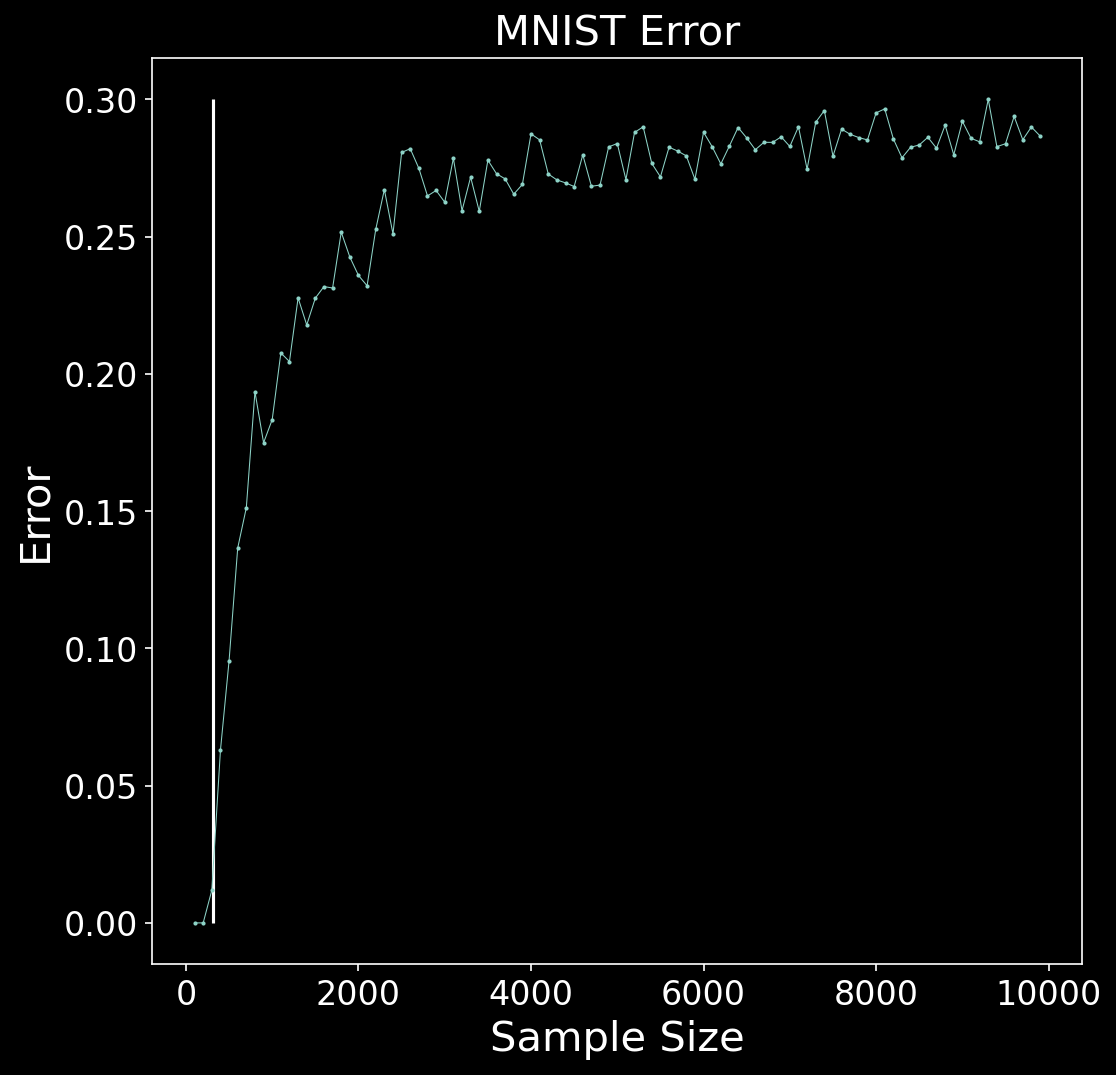

In [52]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],train_prec, 
        linestyle='-', 
        marker='o',
        label='train',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.yscale('log')
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w')
plt.title('MNIST Error')

Text(0.5, 1.0, 'MNIST Error')

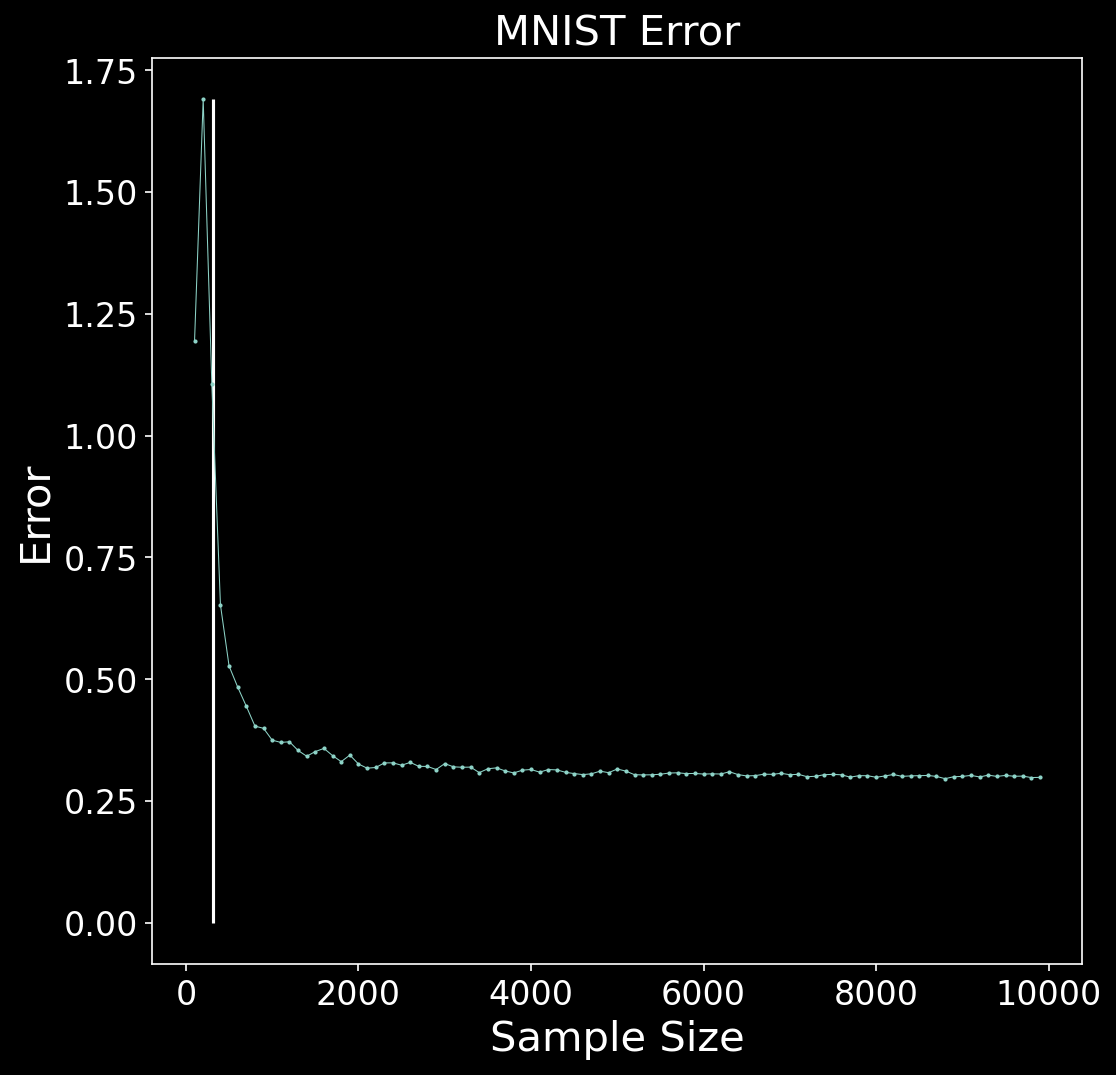

In [53]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w')
plt.title('MNIST Error')

In [56]:
np.min(test_prec)

0.2959618372710396

Text(0.5, 1.0, 'MNIST Rank')

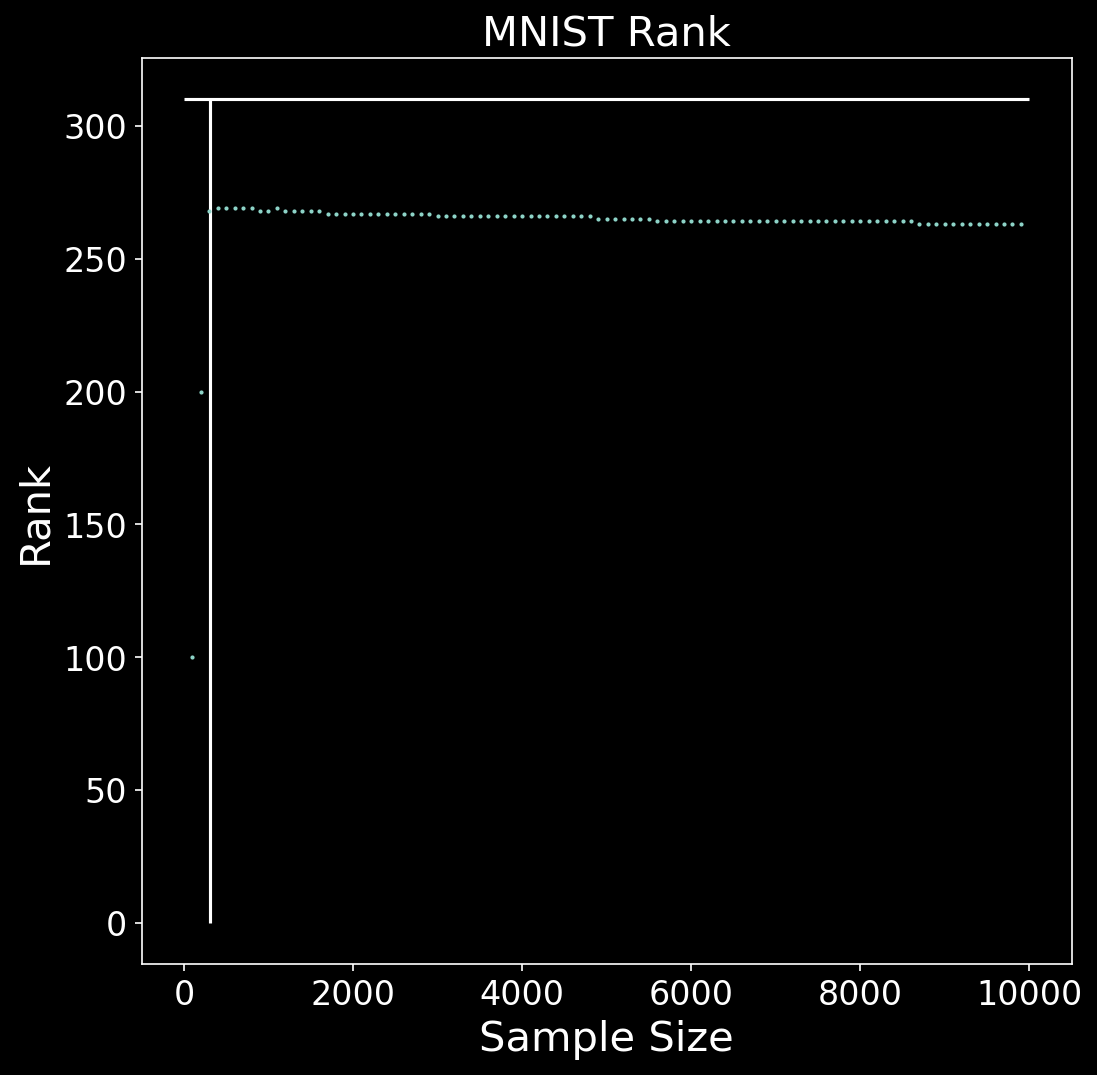

In [54]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w')
plt.hlines(310,0,10000,'w')
plt.title('MNIST Rank')

Text(0.5, 1.0, 'MNIST Spectrum')

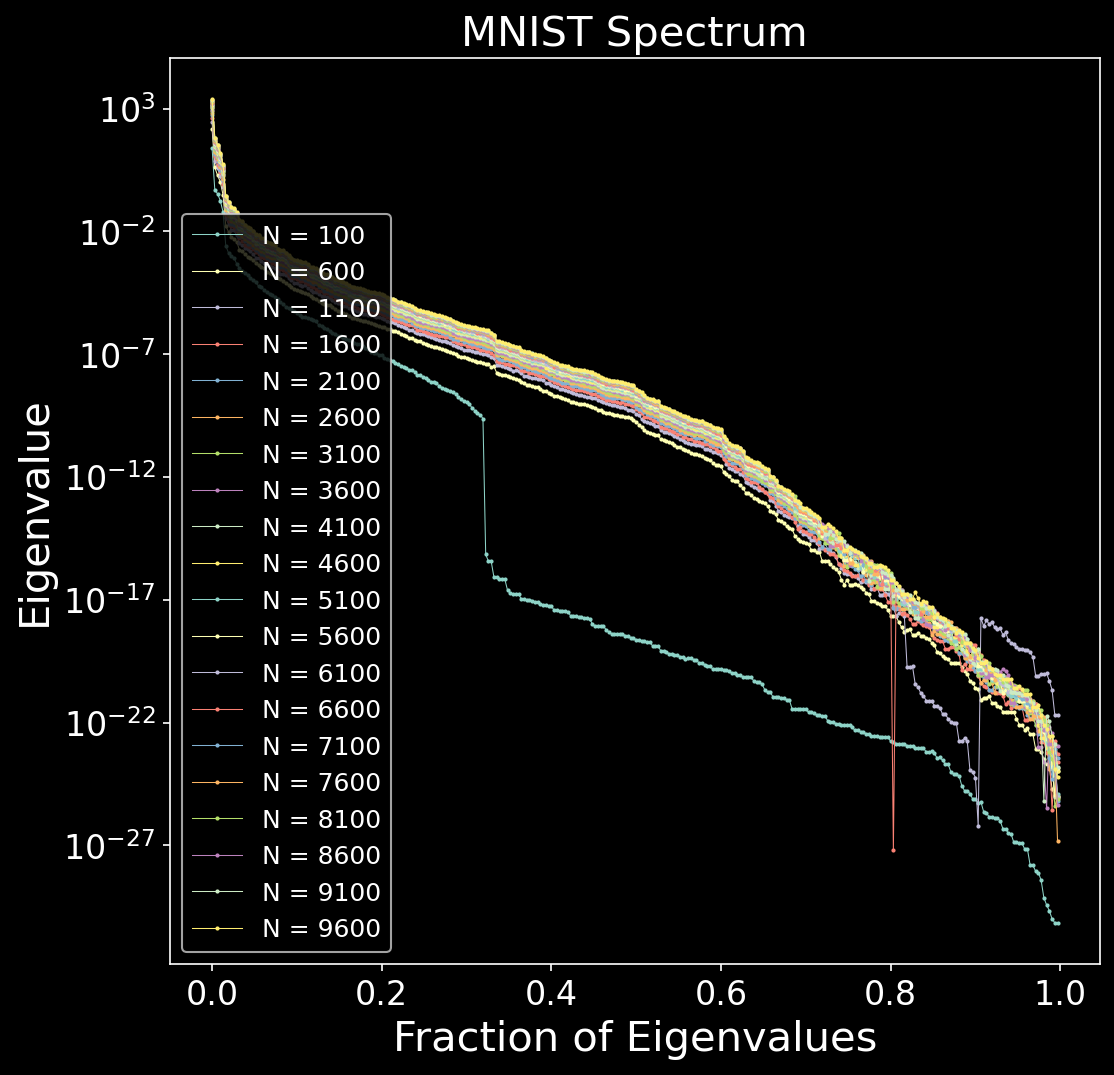

In [55]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
for indx, n in enumerate(range(100,10000,500)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[5*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
plt.title('MNIST Spectrum')

In [72]:
sc = StandardScaler()

X_tr = sc.fit_transform(mnist_DHC_out_sizetrain_iso)
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(mnist_DHC_out_sizetest_iso)

In [73]:
eval_list =[]
test_prec =[]
train_prec =[]
rank = []

for n in range(100,10000,100):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    test_prec.append(np.mean(np.square(np.clip(np.matmul(X_test,est),-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))

Text(0.5, 1.0, 'MNIST Error')

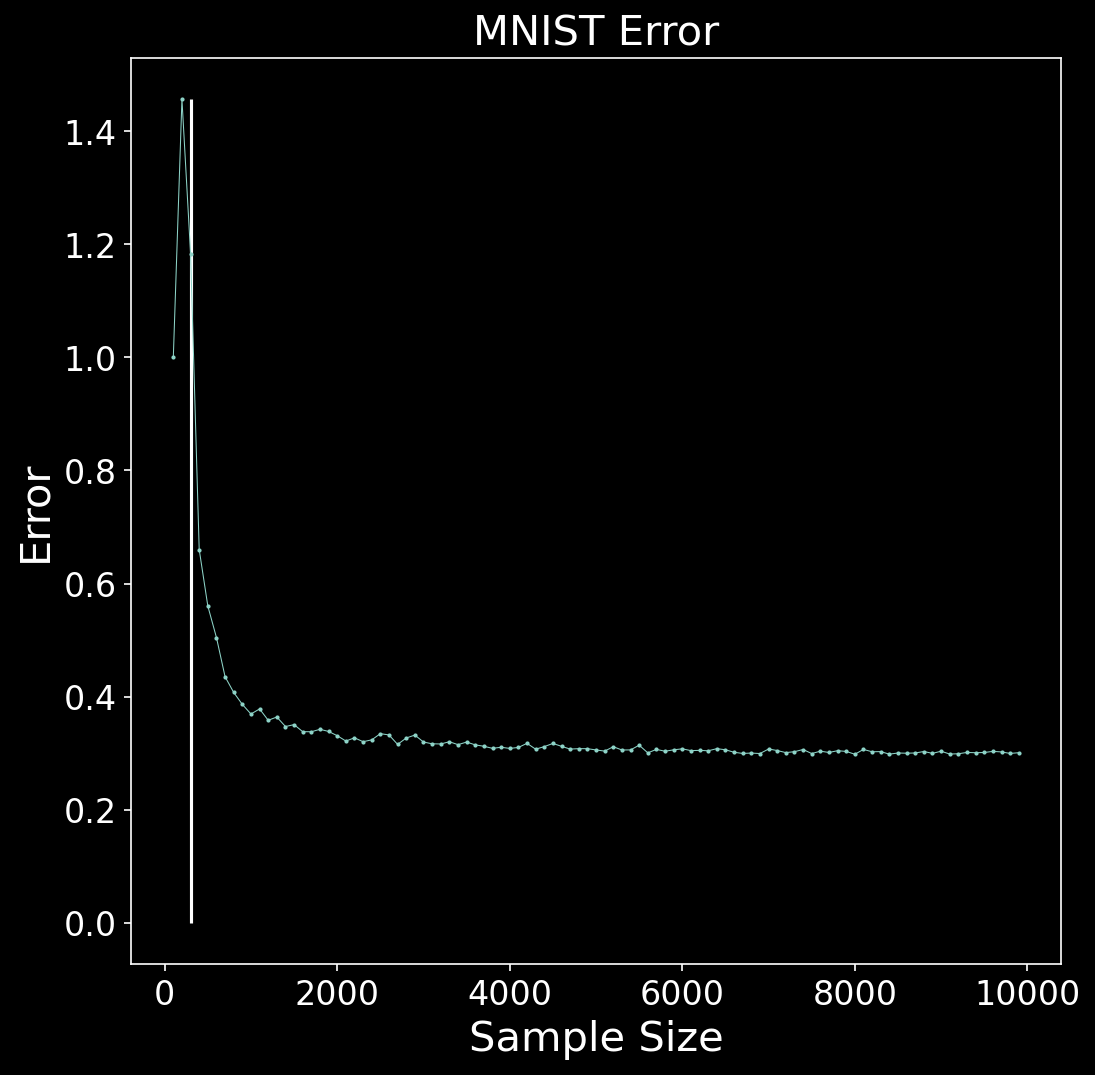

In [74]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w')
plt.title('MNIST Error')

In [75]:
np.min(test_prec)

0.2982173405646032

In [76]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain_iso))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest_iso))

eval_list =[]
test_prec =[]
train_prec =[]
rank = []

for n in range(100,10000,100):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    test_prec.append(np.mean(np.square(np.clip(np.matmul(X_test,est),-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))

Text(0.5, 1.0, 'MNIST Error')

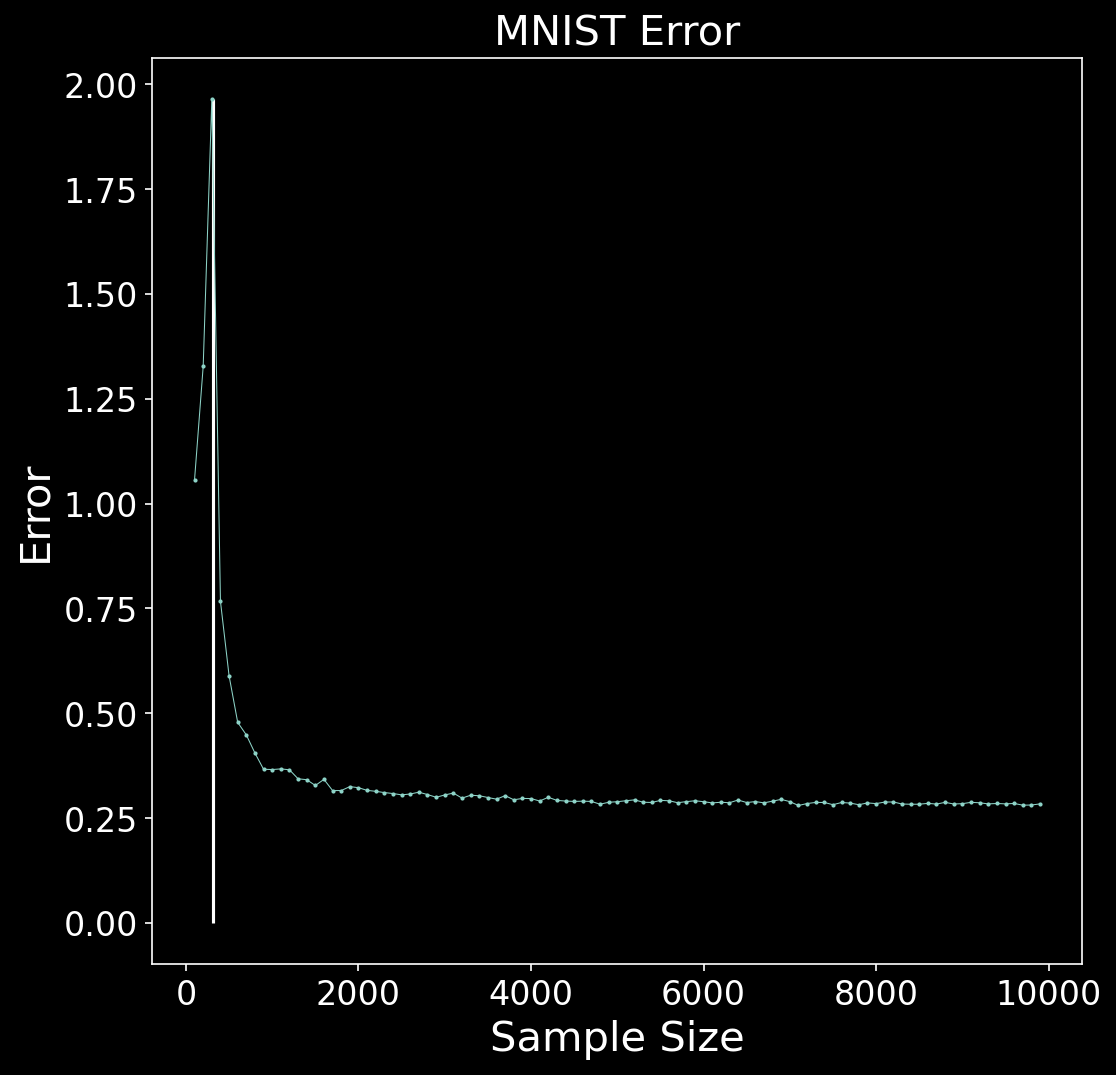

In [77]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w')
plt.title('MNIST Error')

In [81]:
np.min(test_prec)

0.28006212971597766

Text(0.5, 1.0, 'MNIST Error')

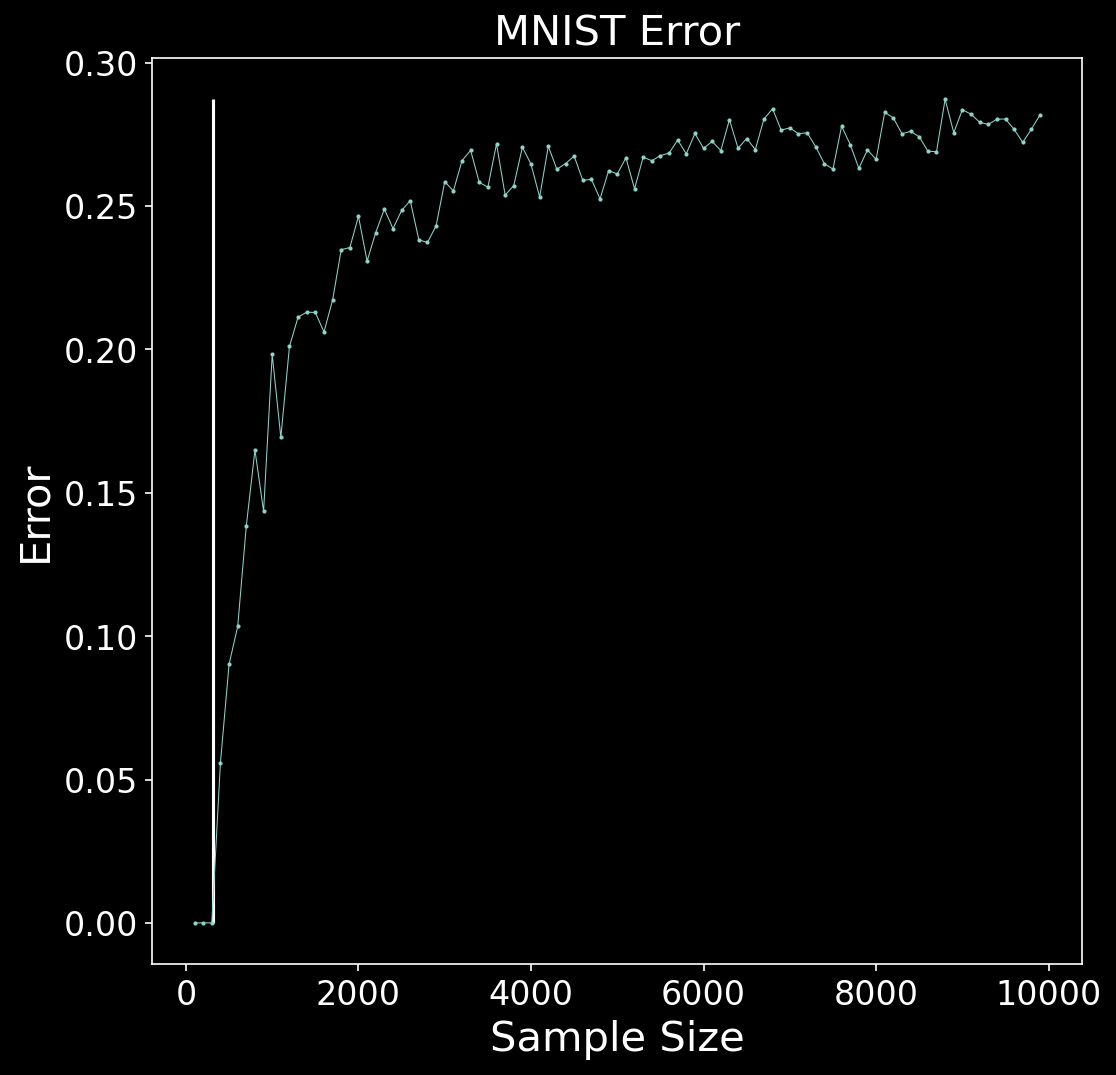

In [78]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w')
plt.title('MNIST Error')

Text(0.5, 1.0, 'MNIST Rank')

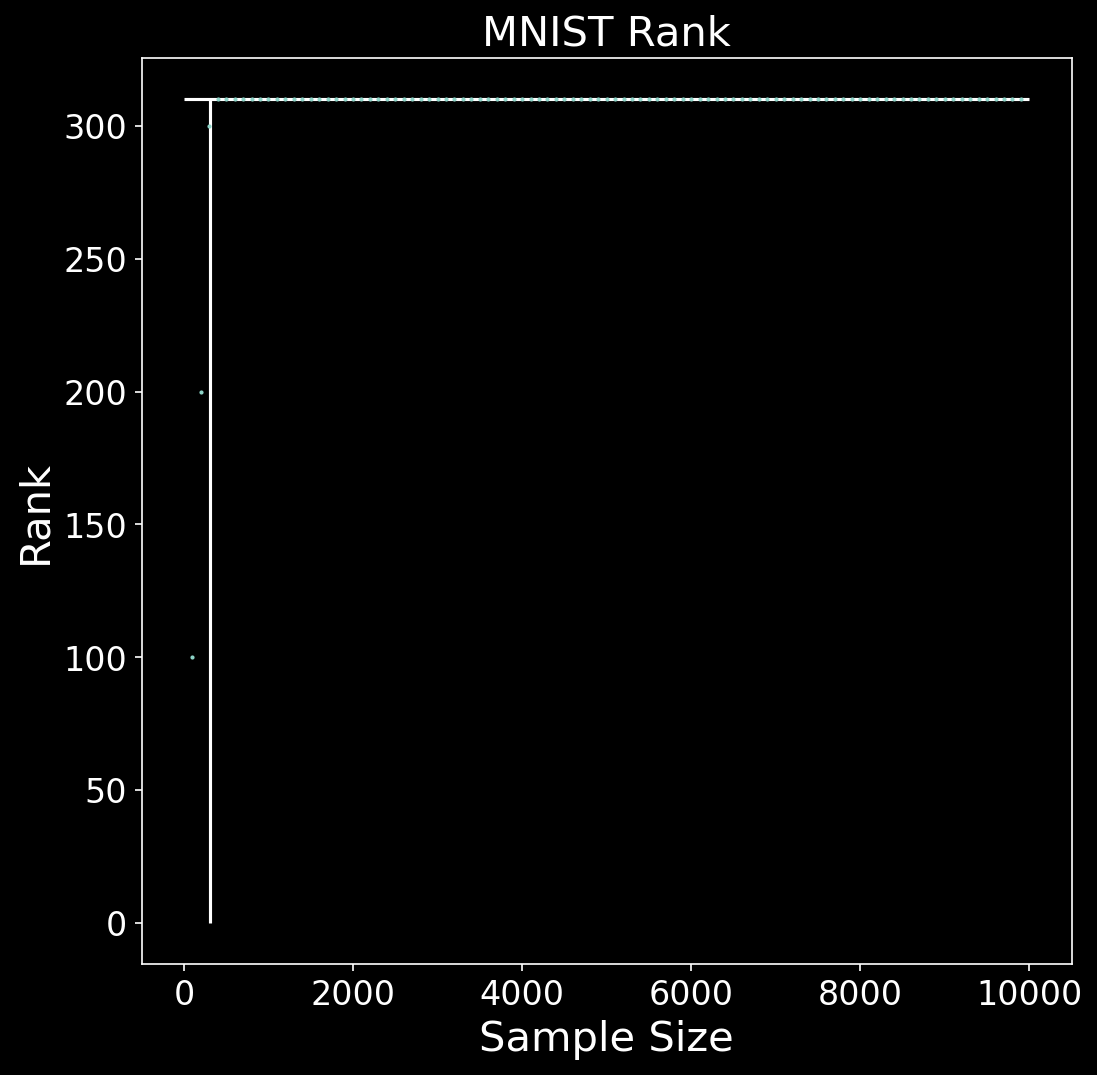

In [79]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(100,10000,100)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w')
plt.hlines(310,0,10000,'w')
plt.title('MNIST Rank')

Text(0.5, 1.0, 'MNIST Spectrum')

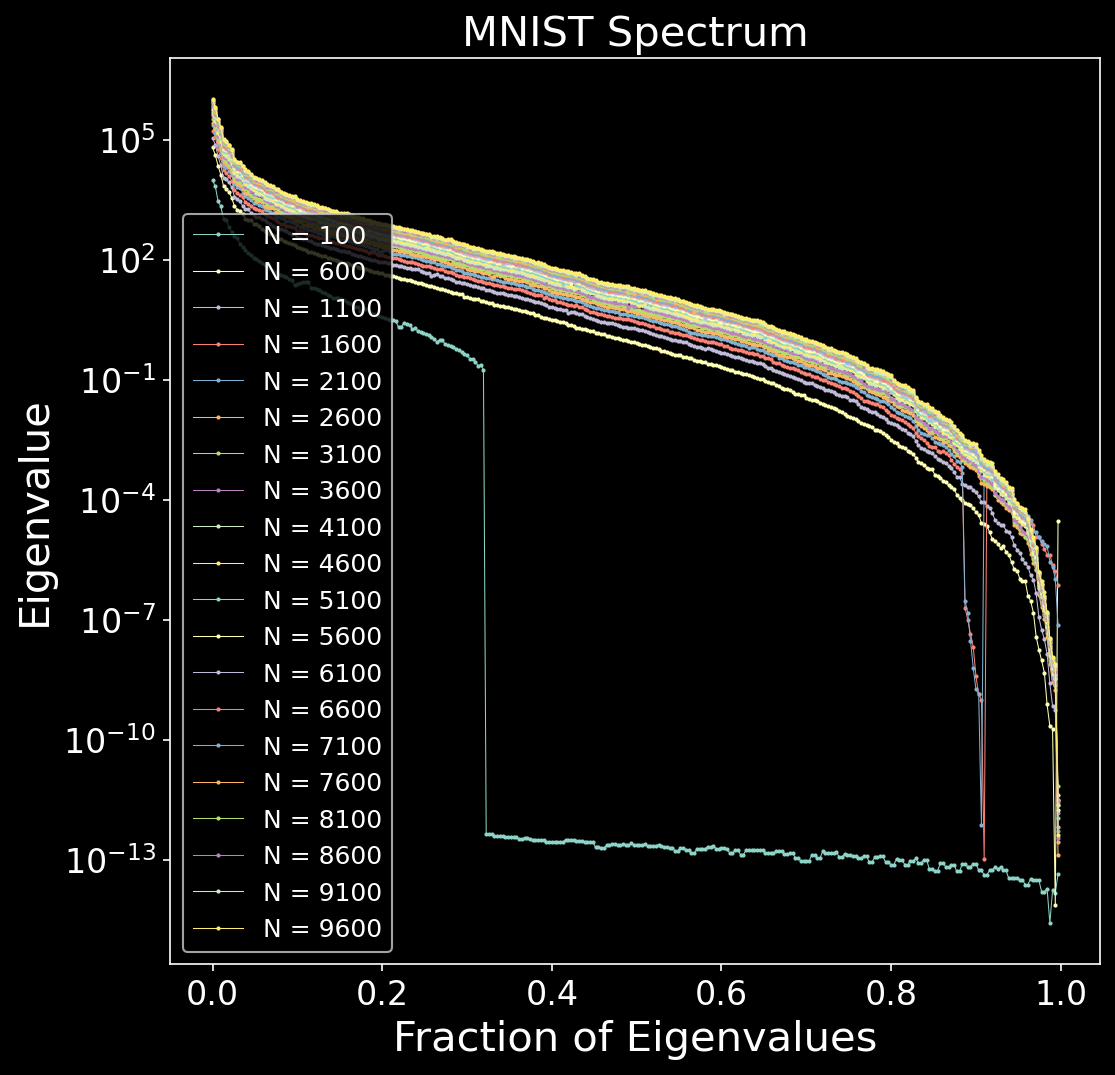

In [80]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
for indx, n in enumerate(range(100,10000,500)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[5*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
plt.title('MNIST Spectrum')

In [87]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain_iso))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest_iso))

In [88]:
eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(50,10000,50):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

Text(0.5, 1.0, 'MNIST Error')

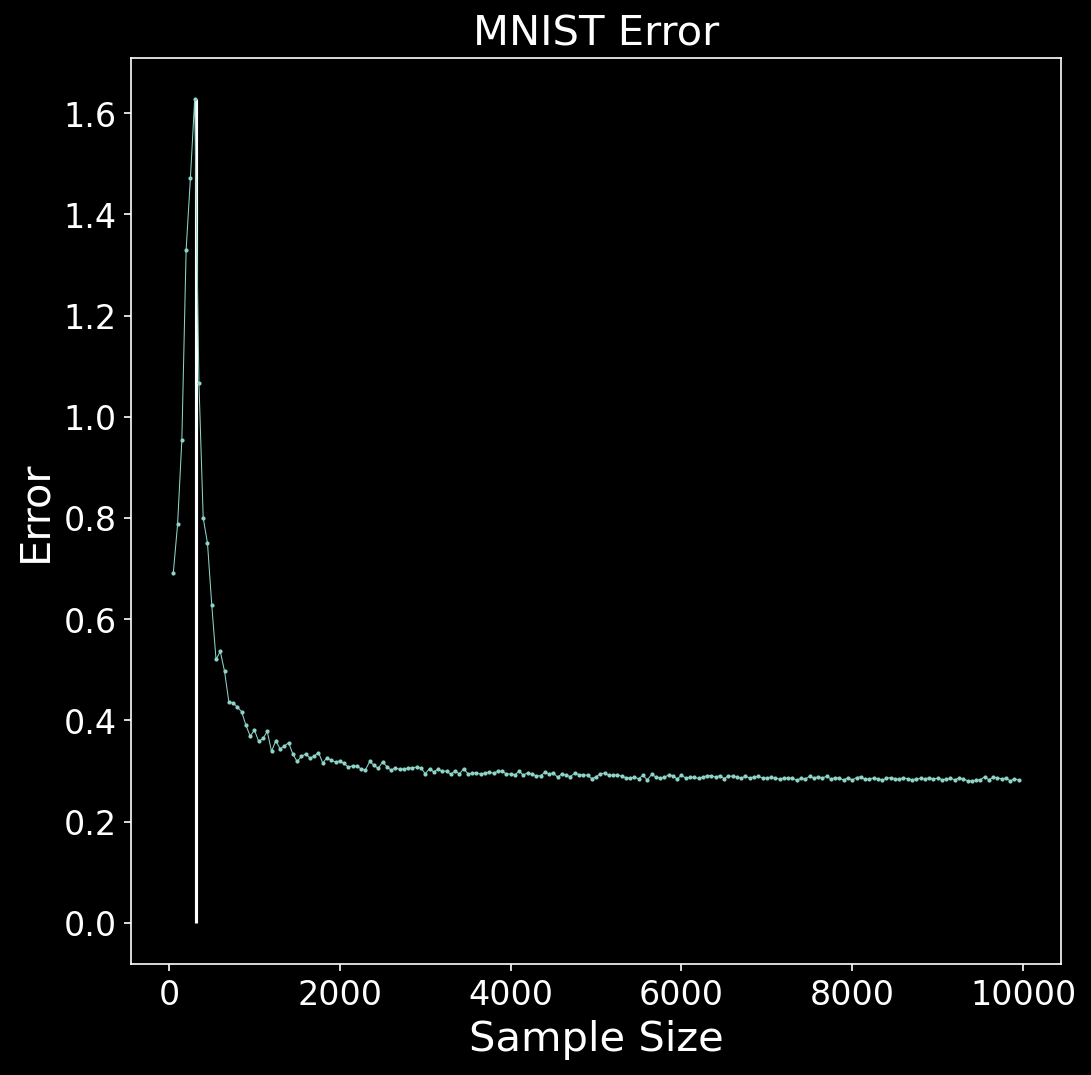

In [89]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(50,10000,50)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w')
plt.title('MNIST Error')

In [90]:
np.min(test_prec)

0.2802462896439138

Text(0.5, 1.0, 'MNIST Error')

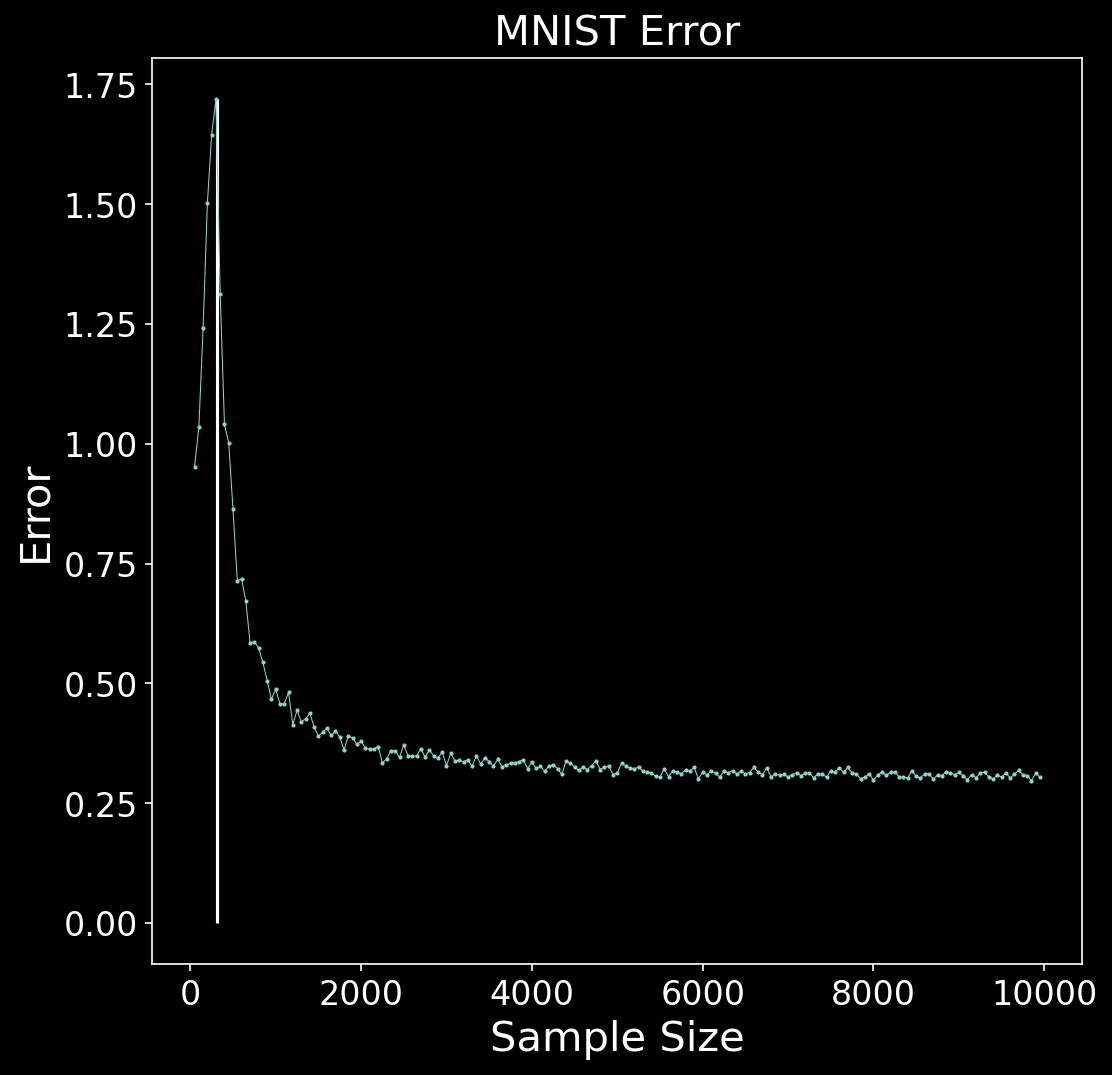

In [91]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(50,10000,50)],test_prec_class, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec_class),'w')
plt.title('MNIST Error')

In [92]:
np.min(test_prec_class)

0.2964

Text(0.5, 1.0, 'MNIST Error')

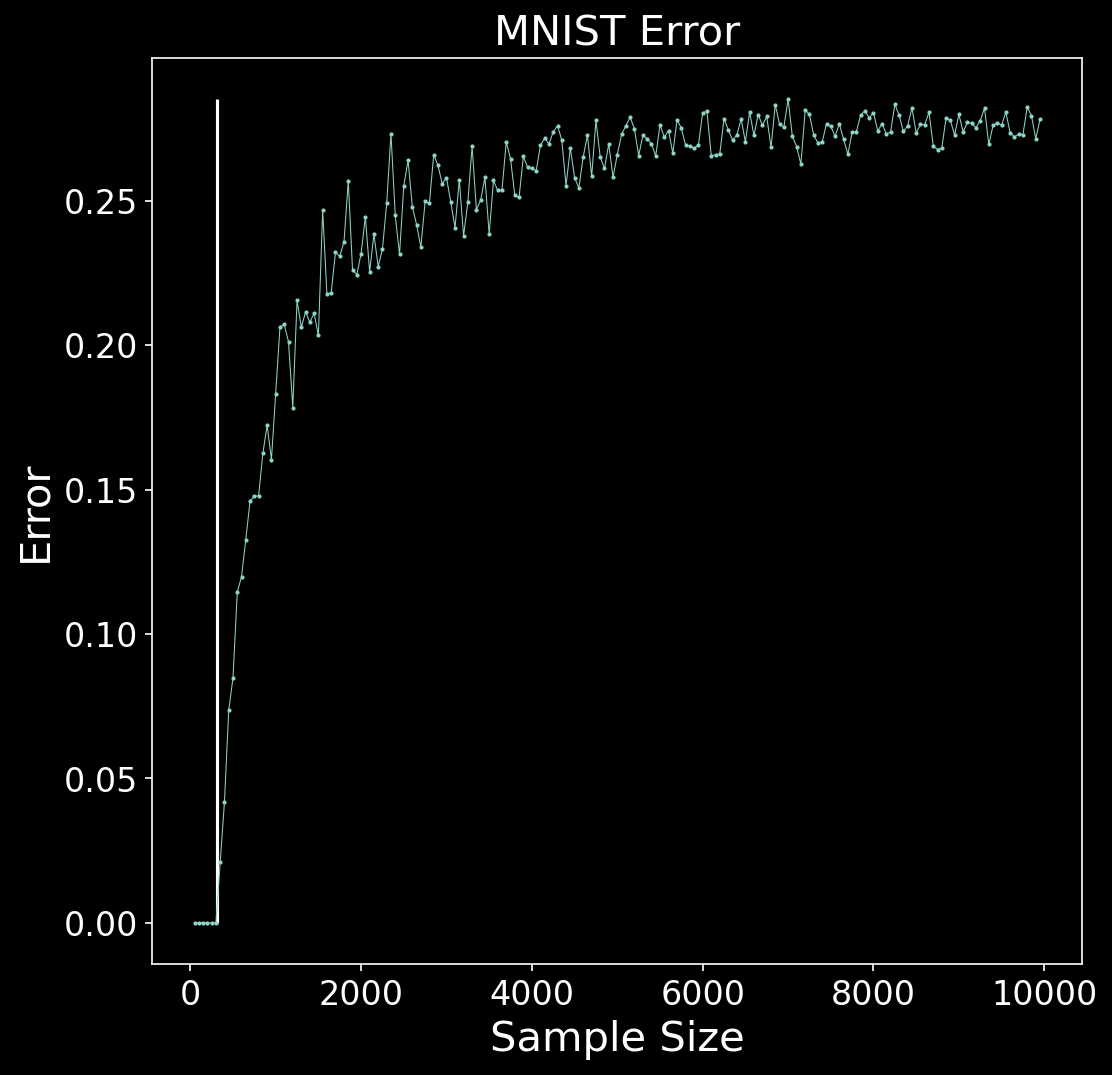

In [95]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(50,10000,50)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w')
plt.title('MNIST Error')

Text(0.5, 1.0, 'MNIST Rank')

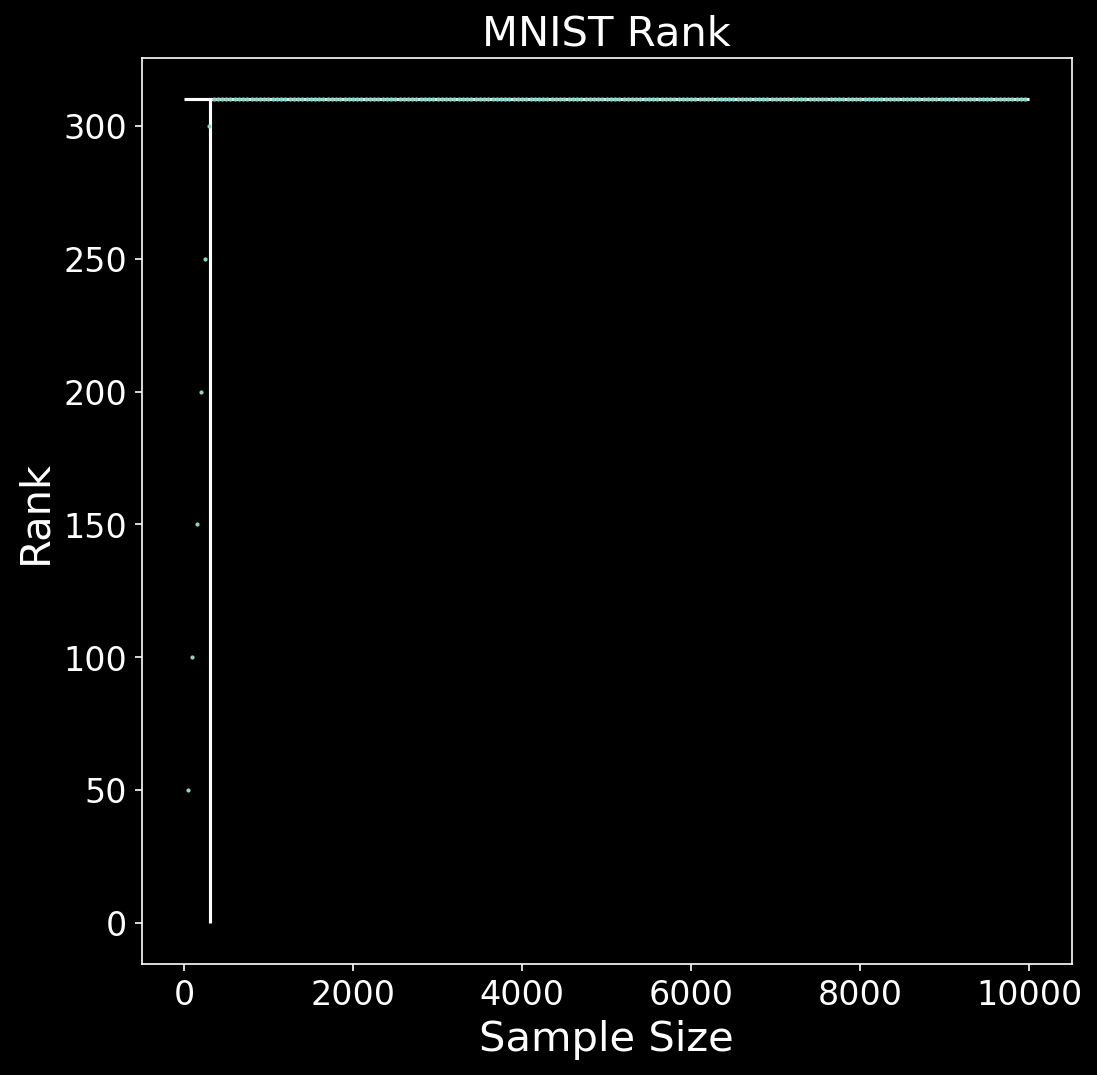

In [96]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot([n for n in range(50,10000,50)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w')
plt.hlines(310,0,10000,'w')
plt.title('MNIST Rank')

Text(0.5, 1.0, 'MNIST Spectrum')

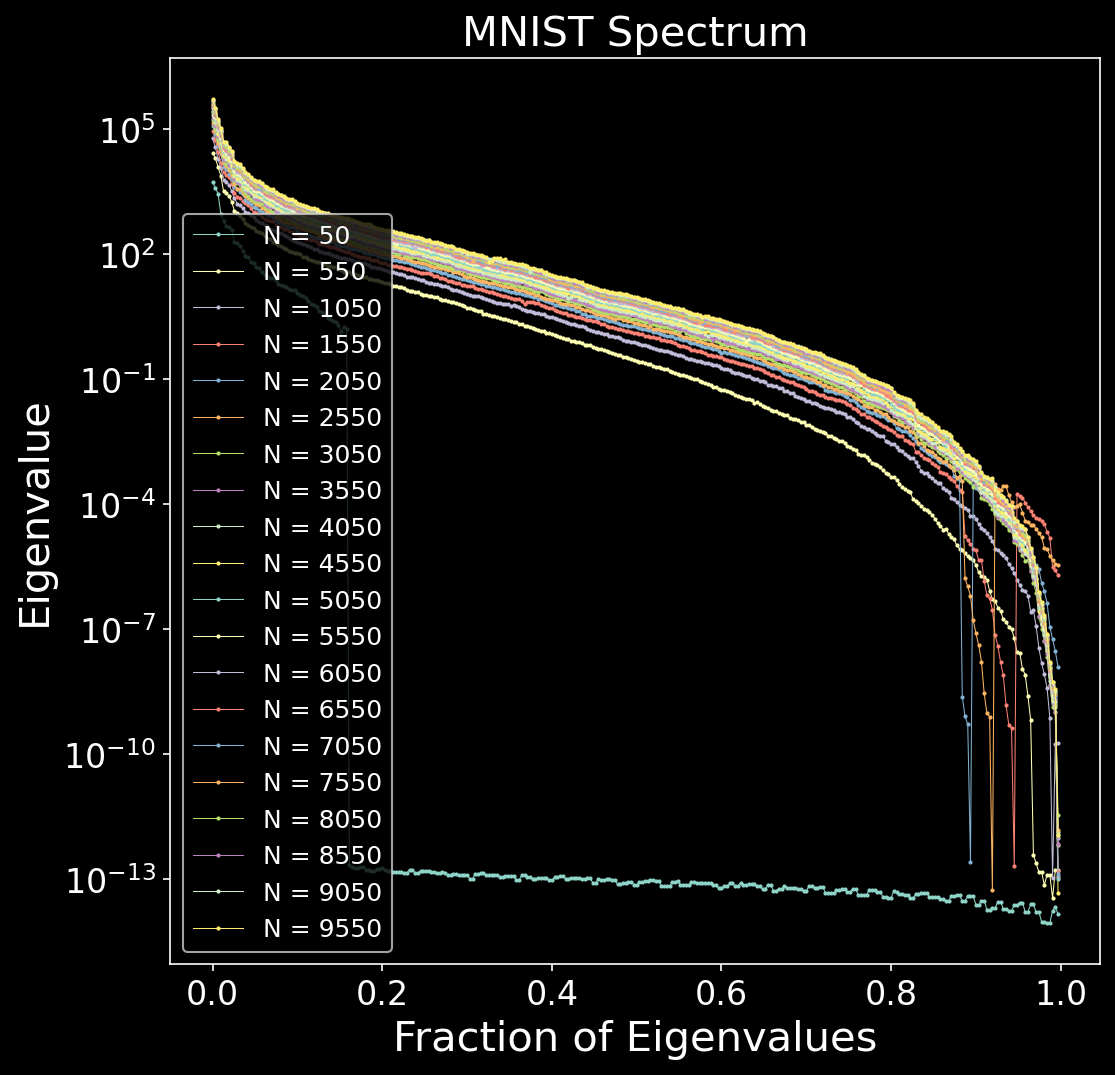

In [100]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
for indx, n in enumerate(range(50,10000,500)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[5*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
plt.title('MNIST Spectrum')

In [101]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

In [102]:
eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(50,10000,50):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

In [124]:
hf = h5py.File('../scratch_AKS/ddesc_7pi8_noiso_log.h5', 'w')
hf.create_dataset('eval_list', data=eval_list)
hf.create_dataset('test_prec', data=test_prec)
hf.create_dataset('train_prec', data=train_prec)
hf.create_dataset('test_prec_class', data=test_prec_class)
hf.create_dataset('rank', data=rank)
hf.close()

In [129]:
eval_list =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_log.h5','eval_list')
test_prec =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_log.h5','test_prec')
train_prec =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_log.h5','train_prec')
test_prec_class =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_log.h5','test_prec_class')
rank =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_log.h5','rank')

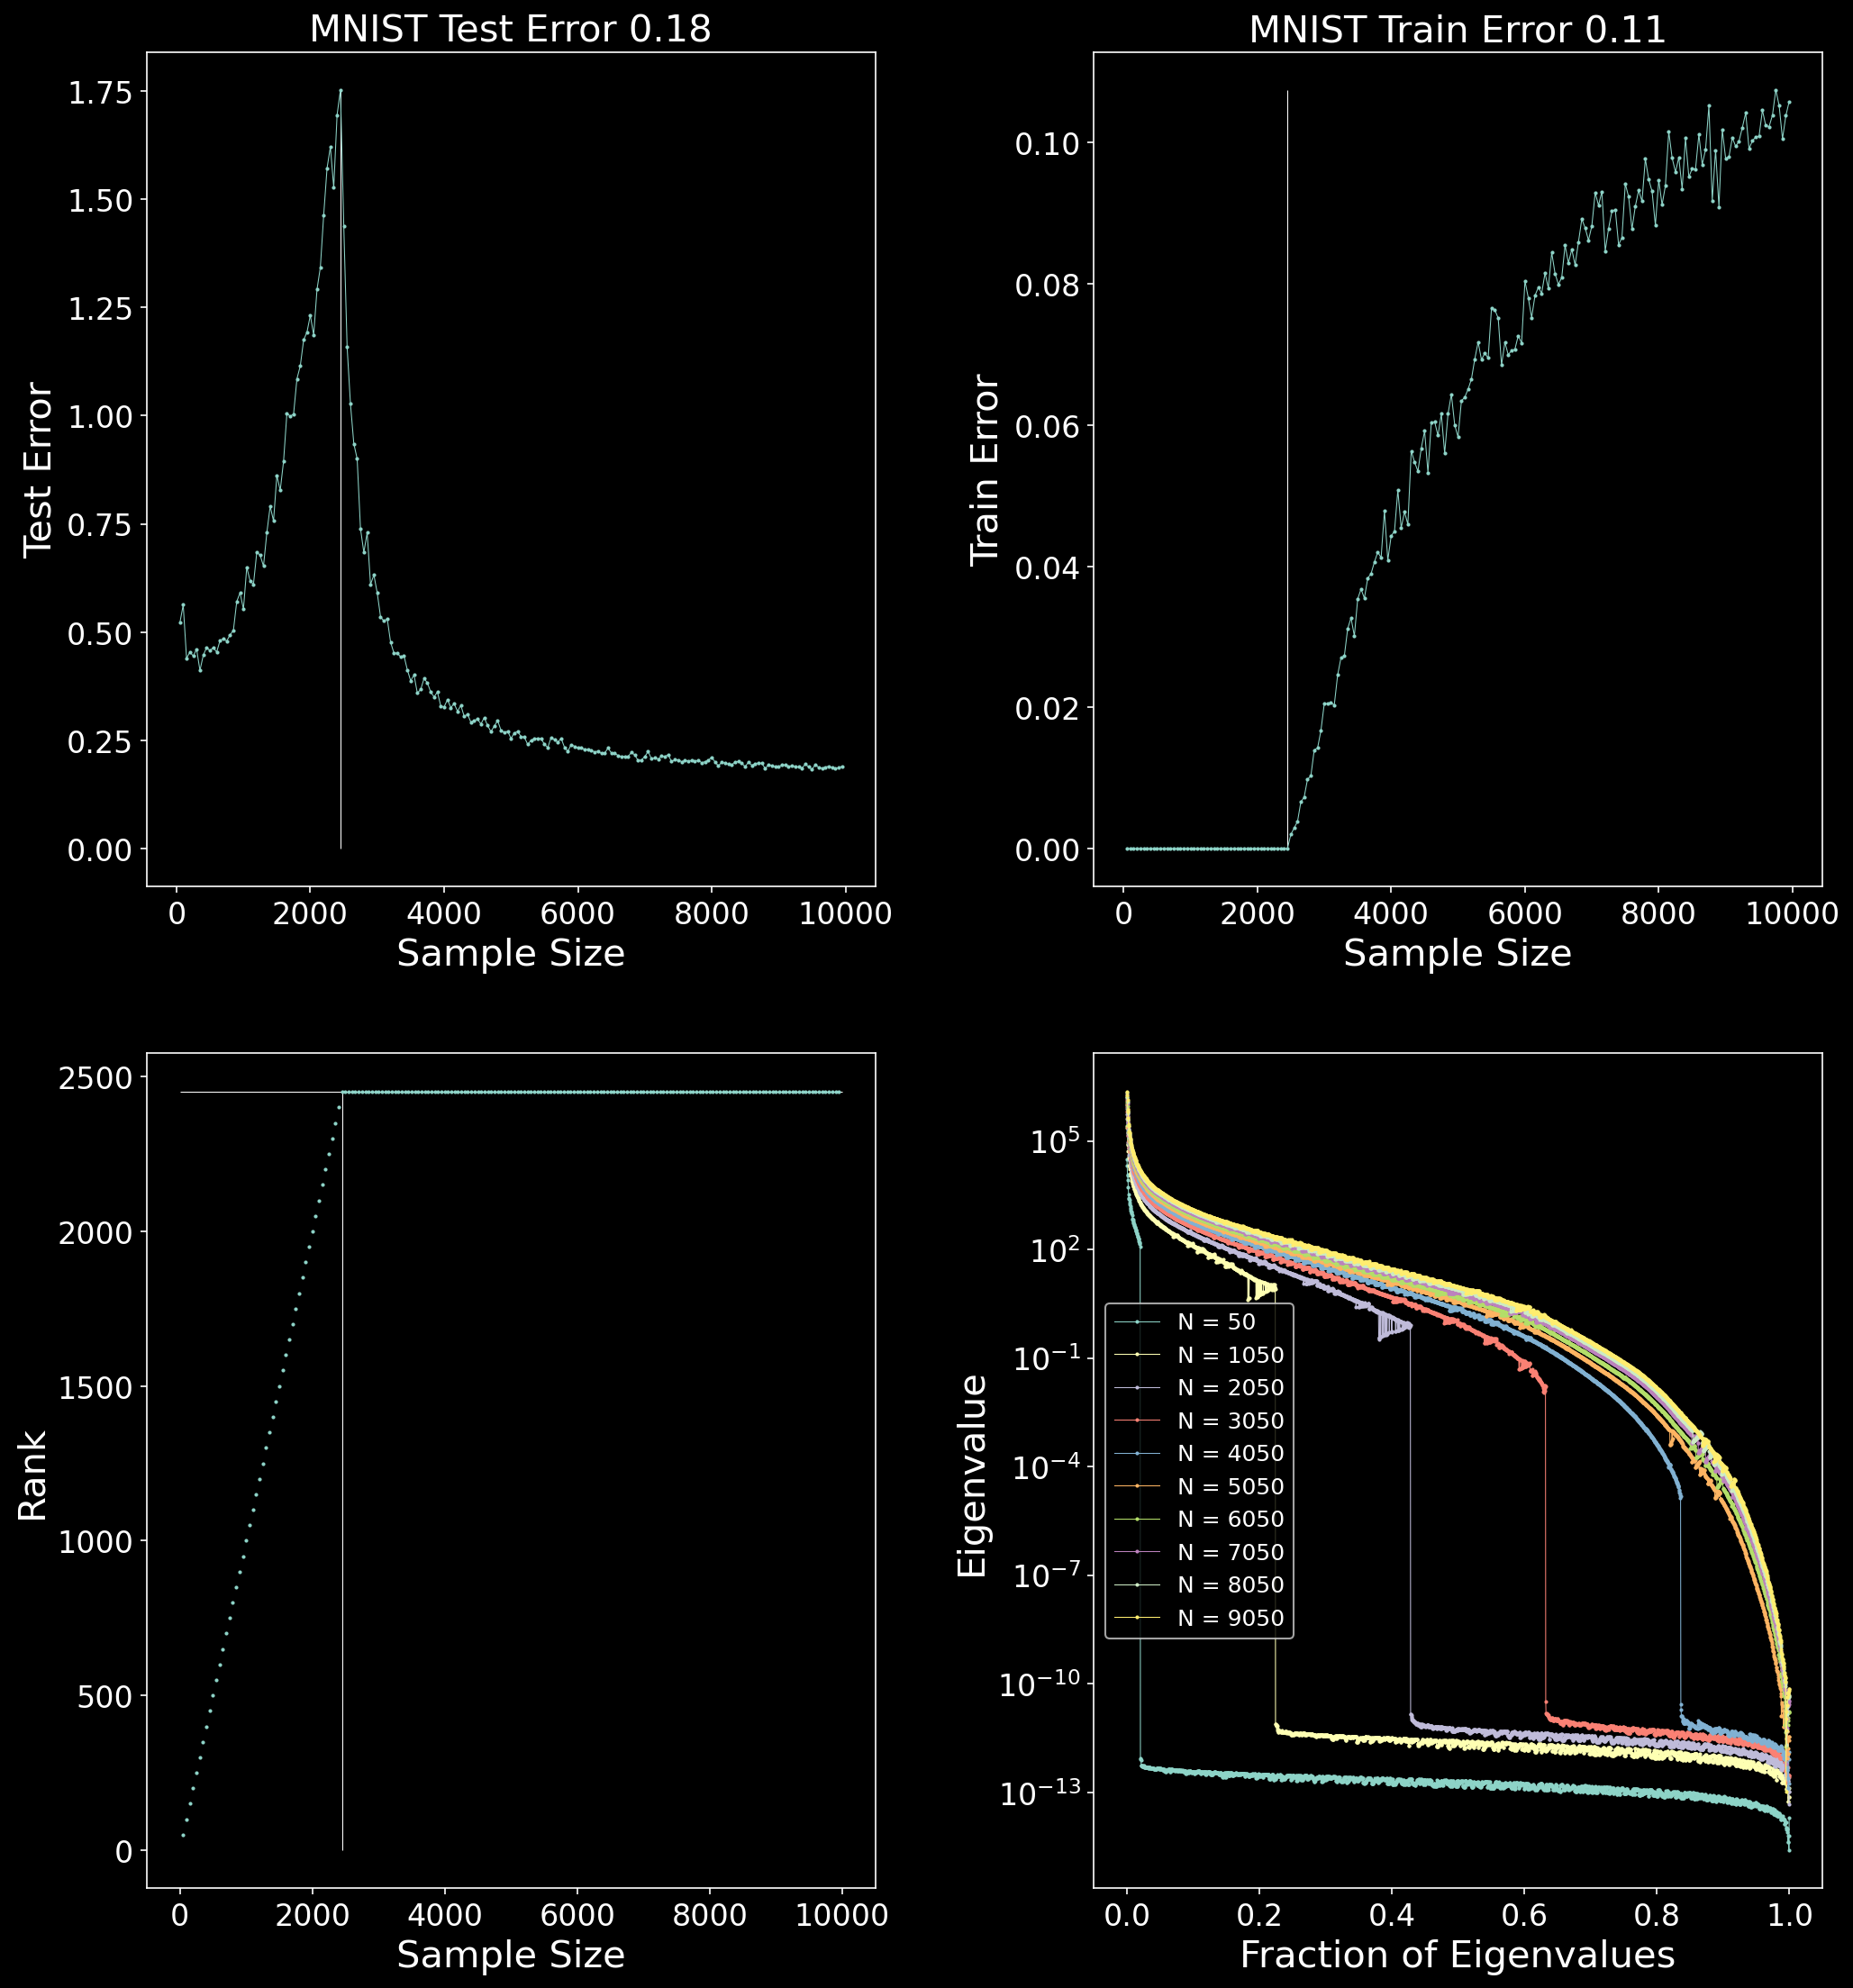

In [131]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot([n for n in range(50,10000,50)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(2452,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(50,10000,50)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(2452,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(50,10000,50)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(2452,0,2452,'w',linewidth=0.5)
plt.hlines(2452,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(50,10000,1000)):
    ax.plot(np.arange(2452)/2452,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [125]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain_iso))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest_iso))

In [126]:
eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(50,10000,50):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

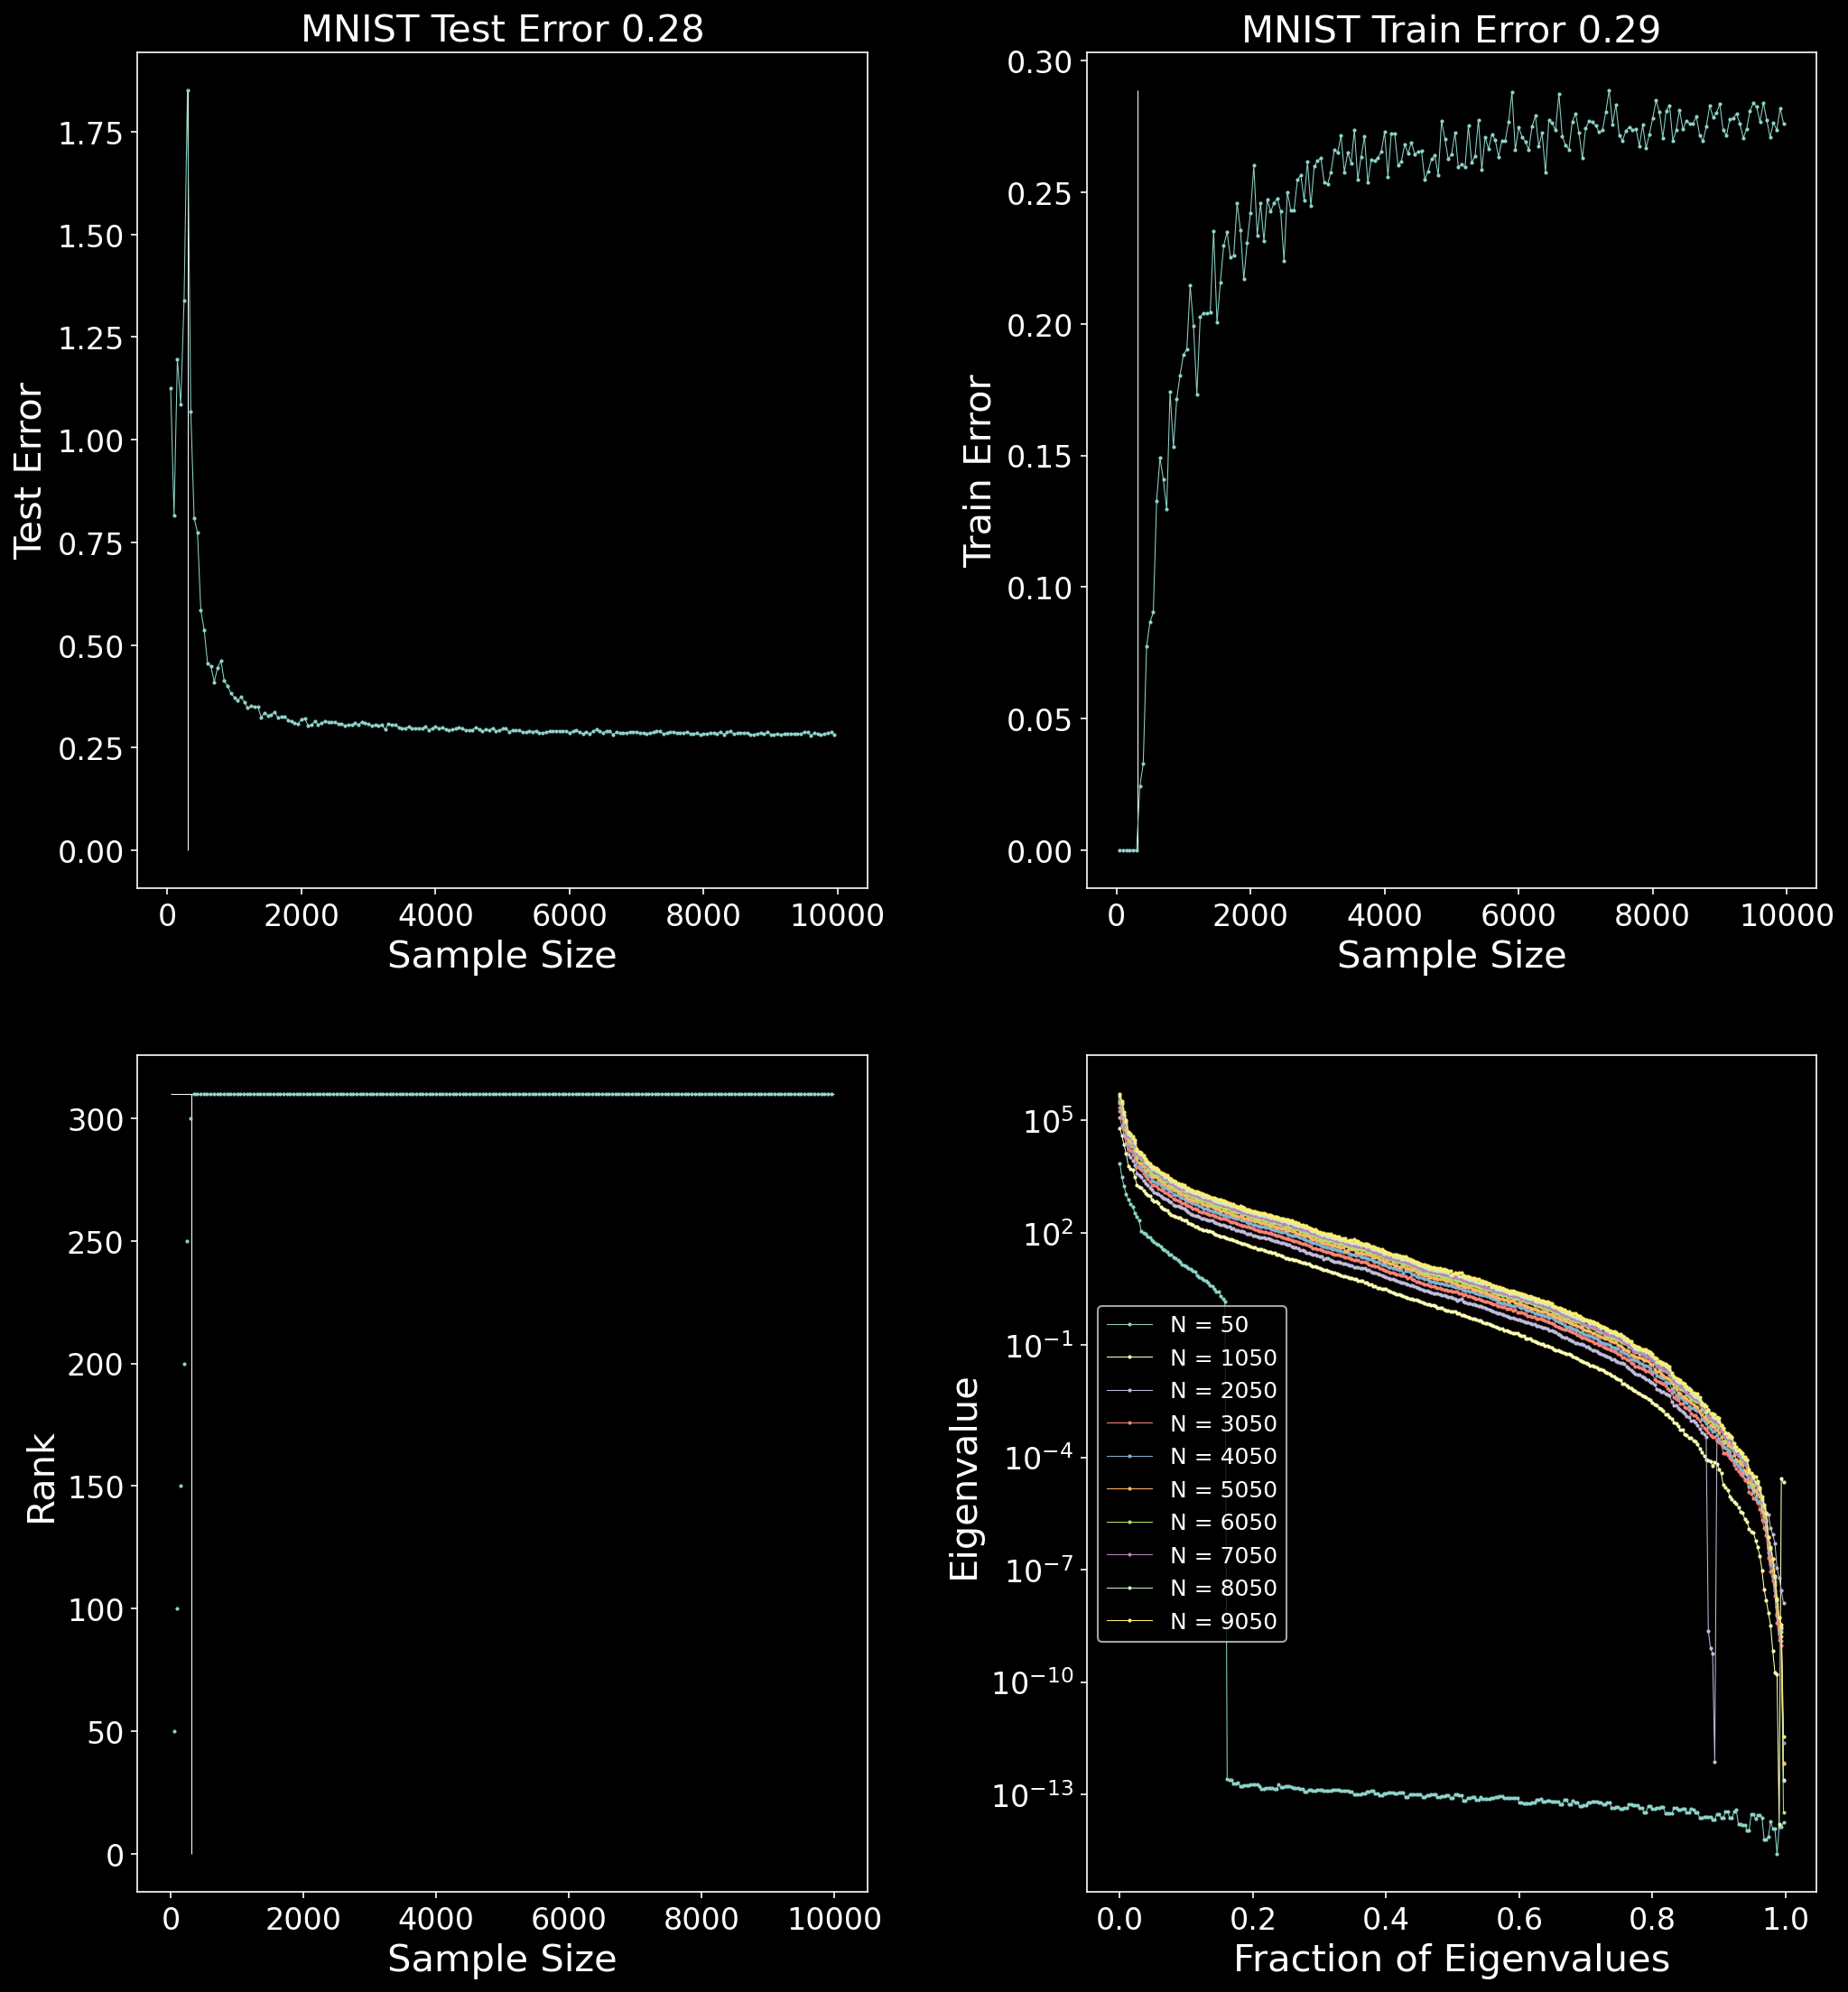

In [128]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot([n for n in range(50,10000,50)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(50,10000,50)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(50,10000,50)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w',linewidth=0.5)
plt.hlines(310,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(50,10000,1000)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [133]:
X_tr = mnist_DHC_out_sizetrain_iso
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest_iso

In [134]:
eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(50,10000,50):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

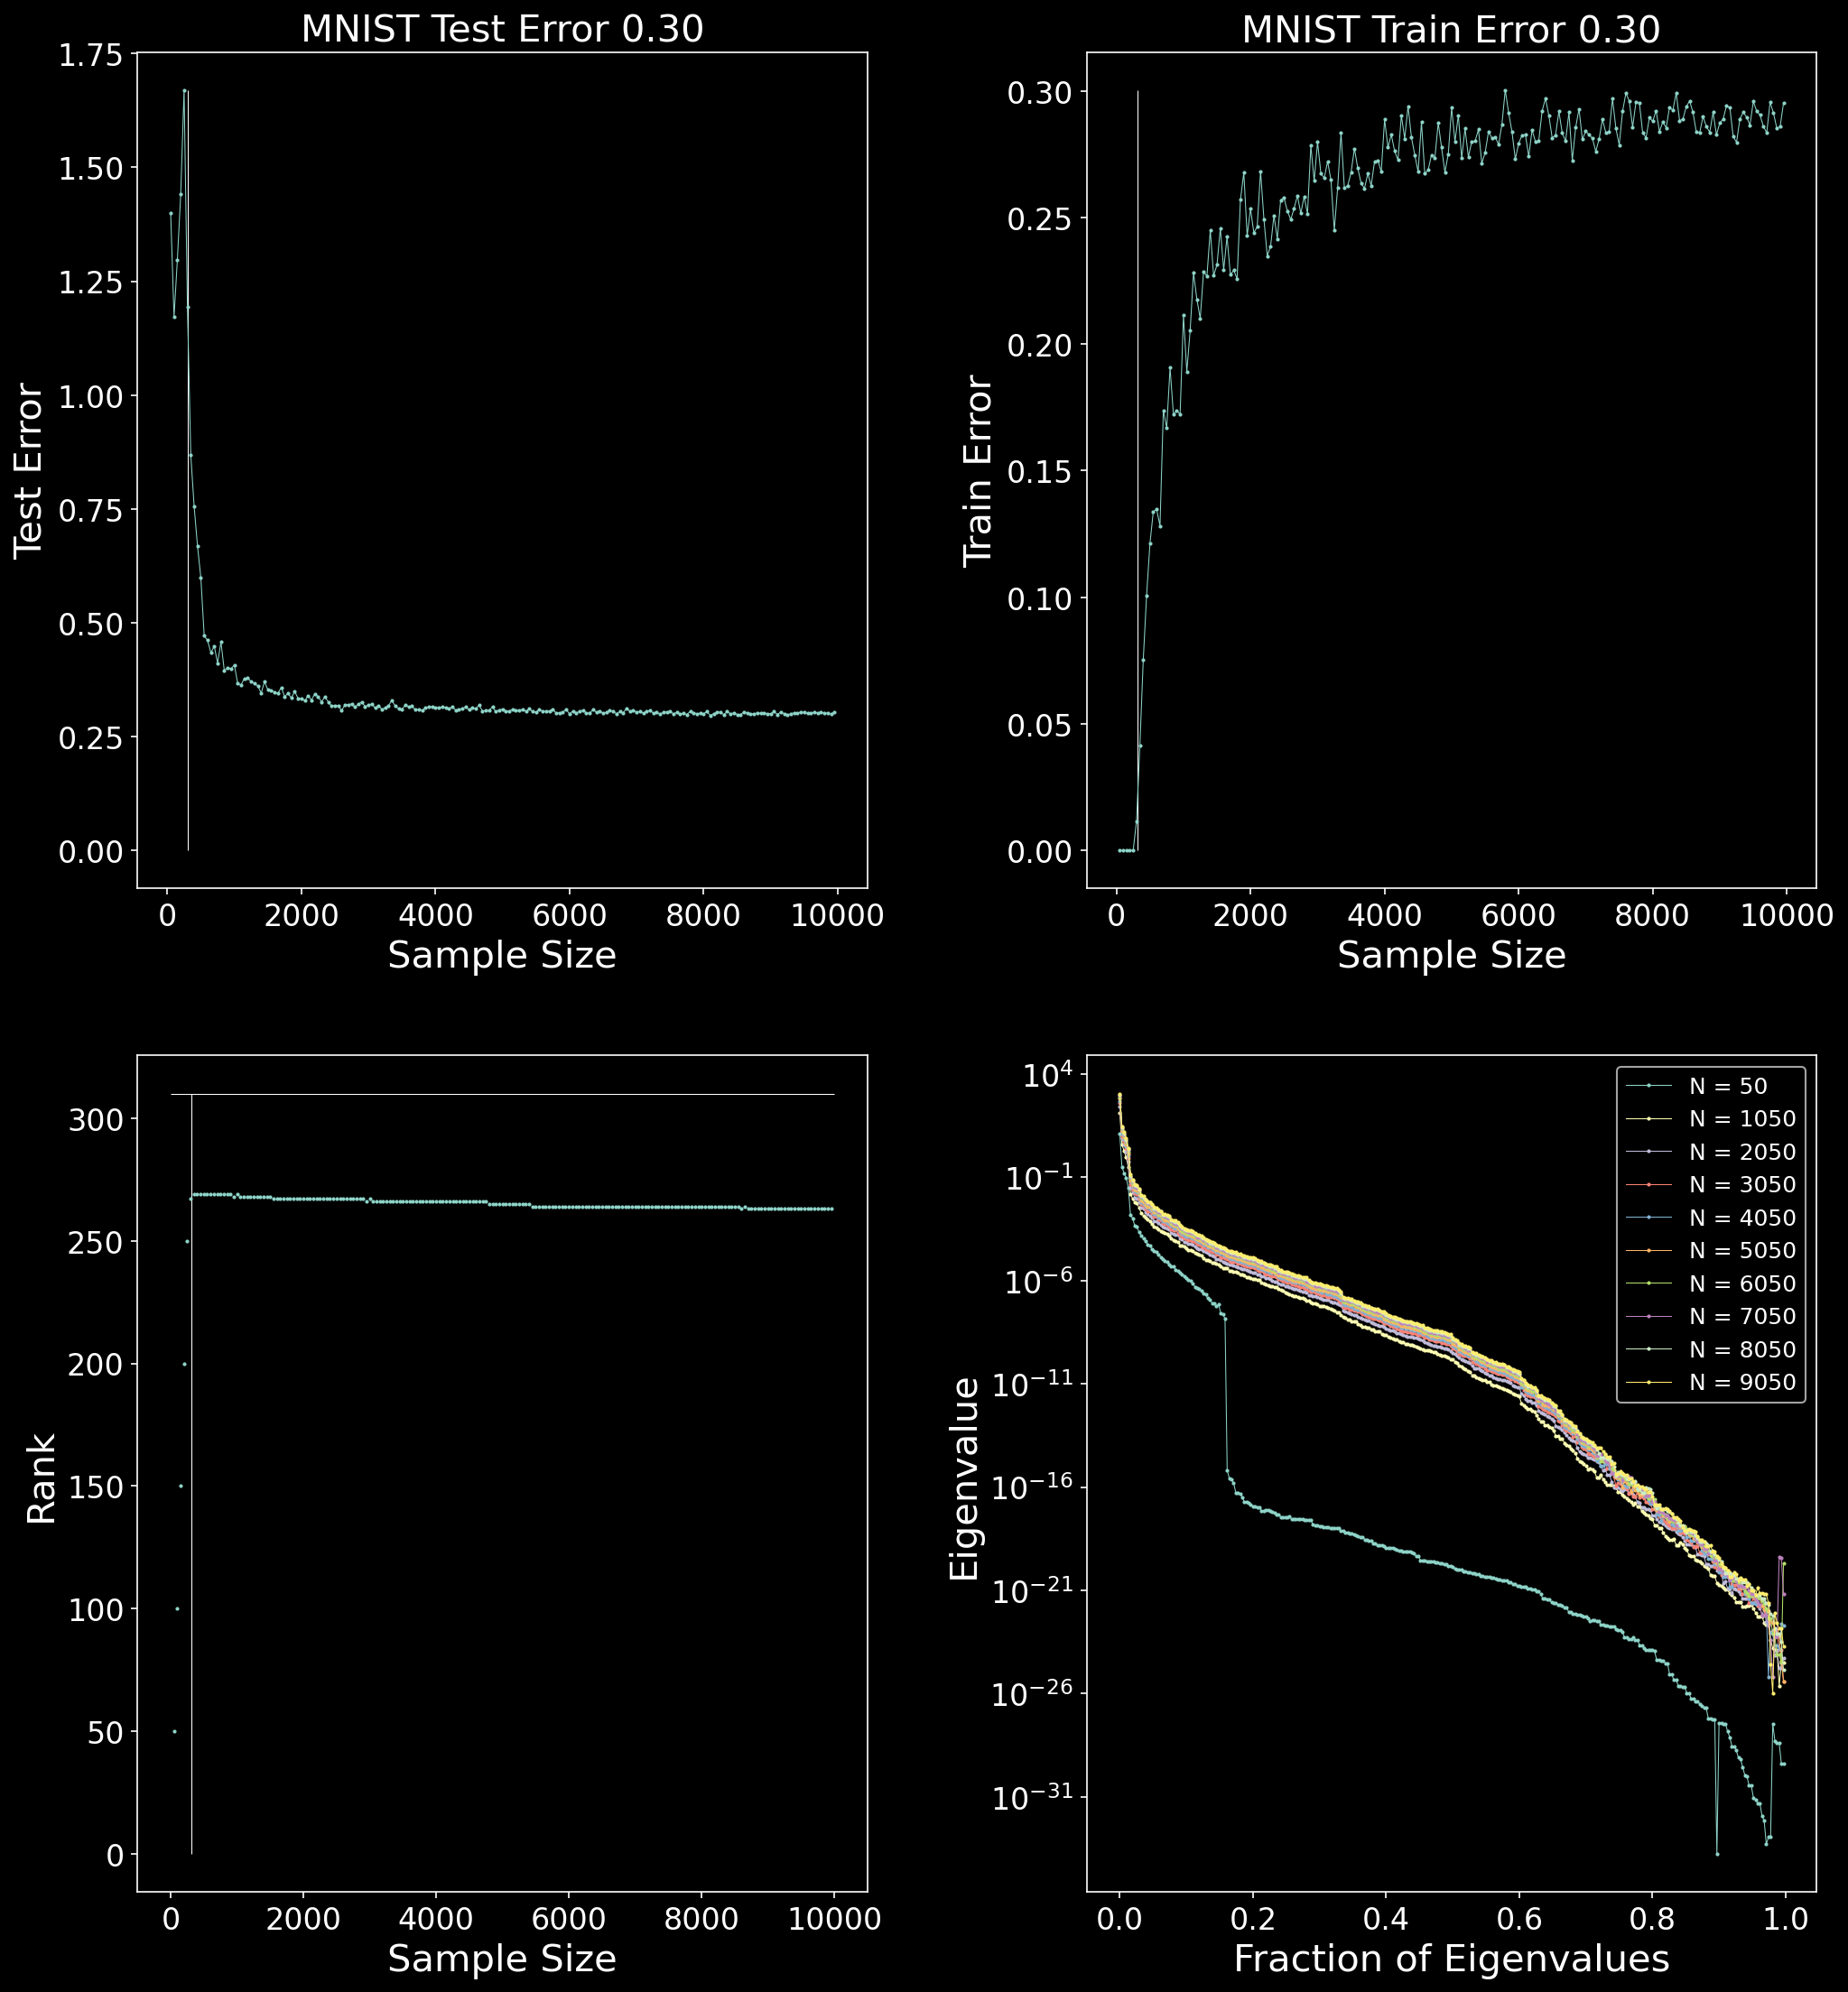

In [135]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot([n for n in range(50,10000,50)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(50,10000,50)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(50,10000,50)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w',linewidth=0.5)
plt.hlines(310,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(50,10000,1000)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [142]:
eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(10,600,1):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

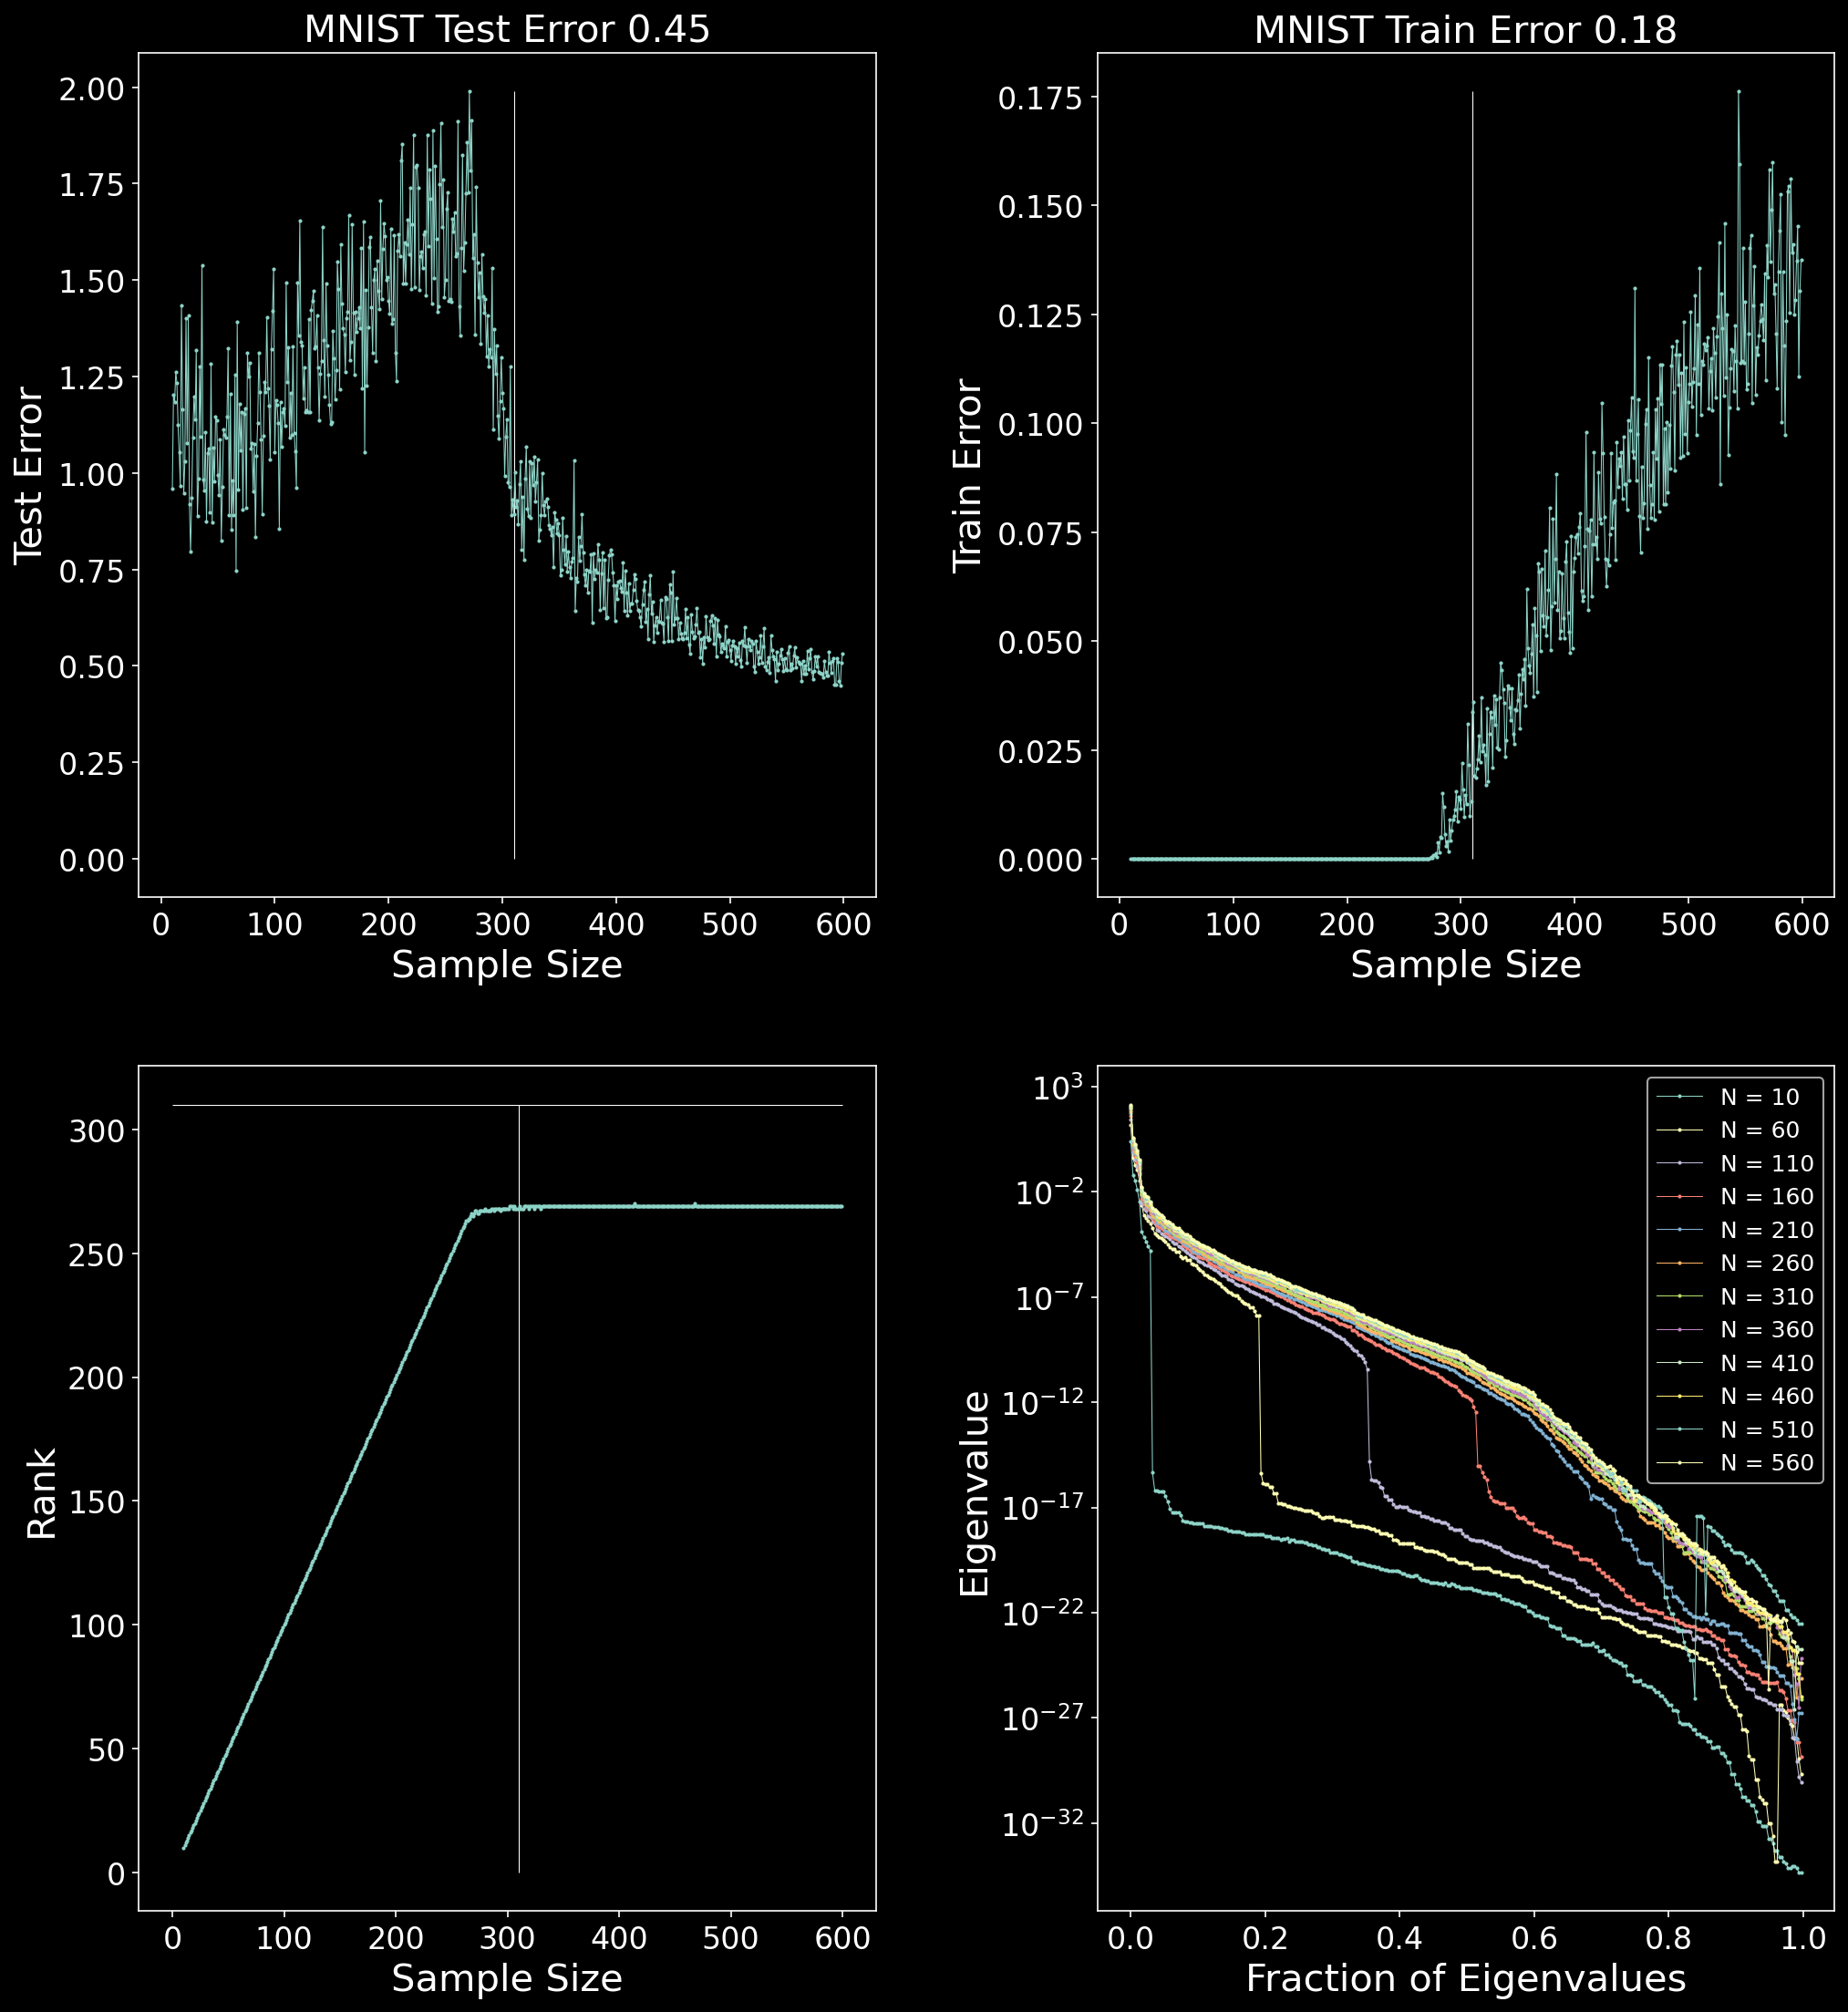

In [143]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot([n for n in range(10,600,1)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(10,600,1)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(10,600,1)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w',linewidth=0.5)
plt.hlines(310,0,600,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(10,600,50)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[50*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [144]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain_iso))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest_iso))

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(10,600,1):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

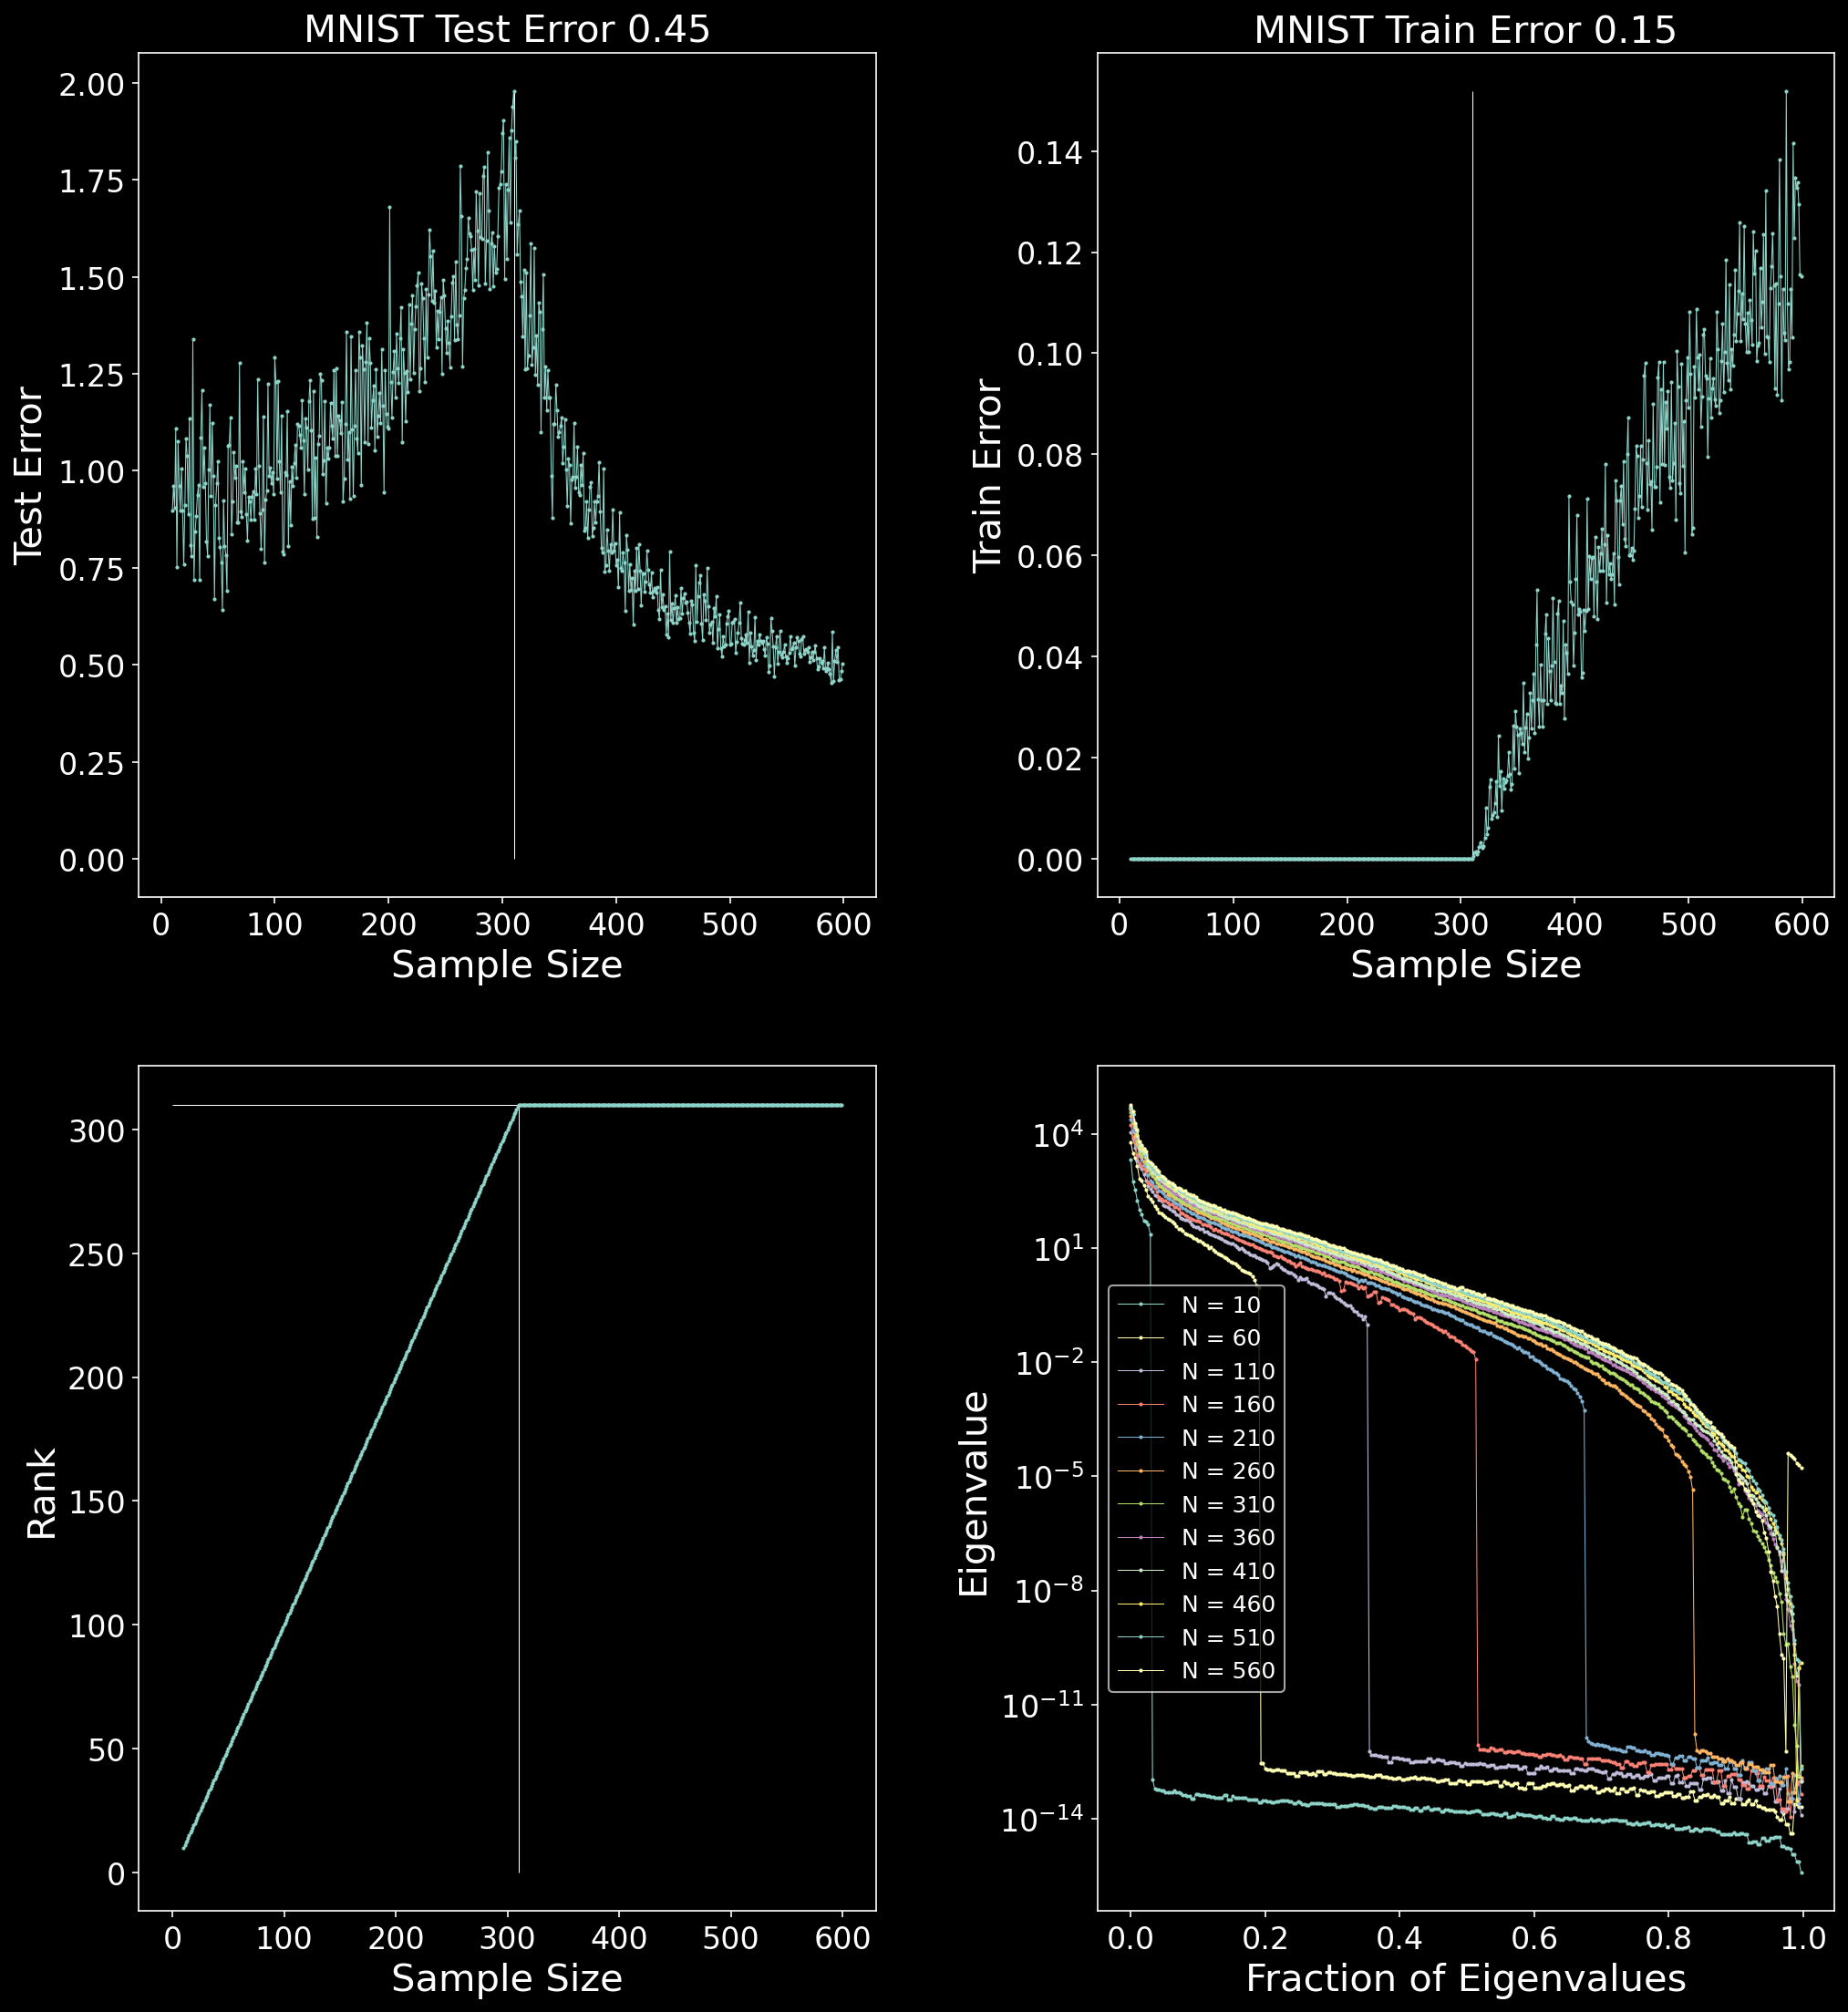

In [145]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot([n for n in range(10,600,1)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(10,600,1)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(10,600,1)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(310,0,310,'w',linewidth=0.5)
plt.hlines(310,0,600,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(10,600,50)):
    ax.plot(np.arange(310)/310,np.abs(eval_list[50*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

1h Runtime, run before you get up

In [198]:
len([n for n in range(50,10000,50)]), len(range(10,600,1)), len(range(10,5000,30))

(199, 590, 167)

In [146]:
X_tr = mnist_DHC_out_sizetrain
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(50,10000,50):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    
hf = h5py.File('../scratch_AKS/ddesc_7pi8_noiso.h5', 'w')
hf.create_dataset('eval_list', data=eval_list)
hf.create_dataset('test_prec', data=test_prec)
hf.create_dataset('train_prec', data=train_prec)
hf.create_dataset('test_prec_class', data=test_prec_class)
hf.create_dataset('rank', data=rank)
hf.close()

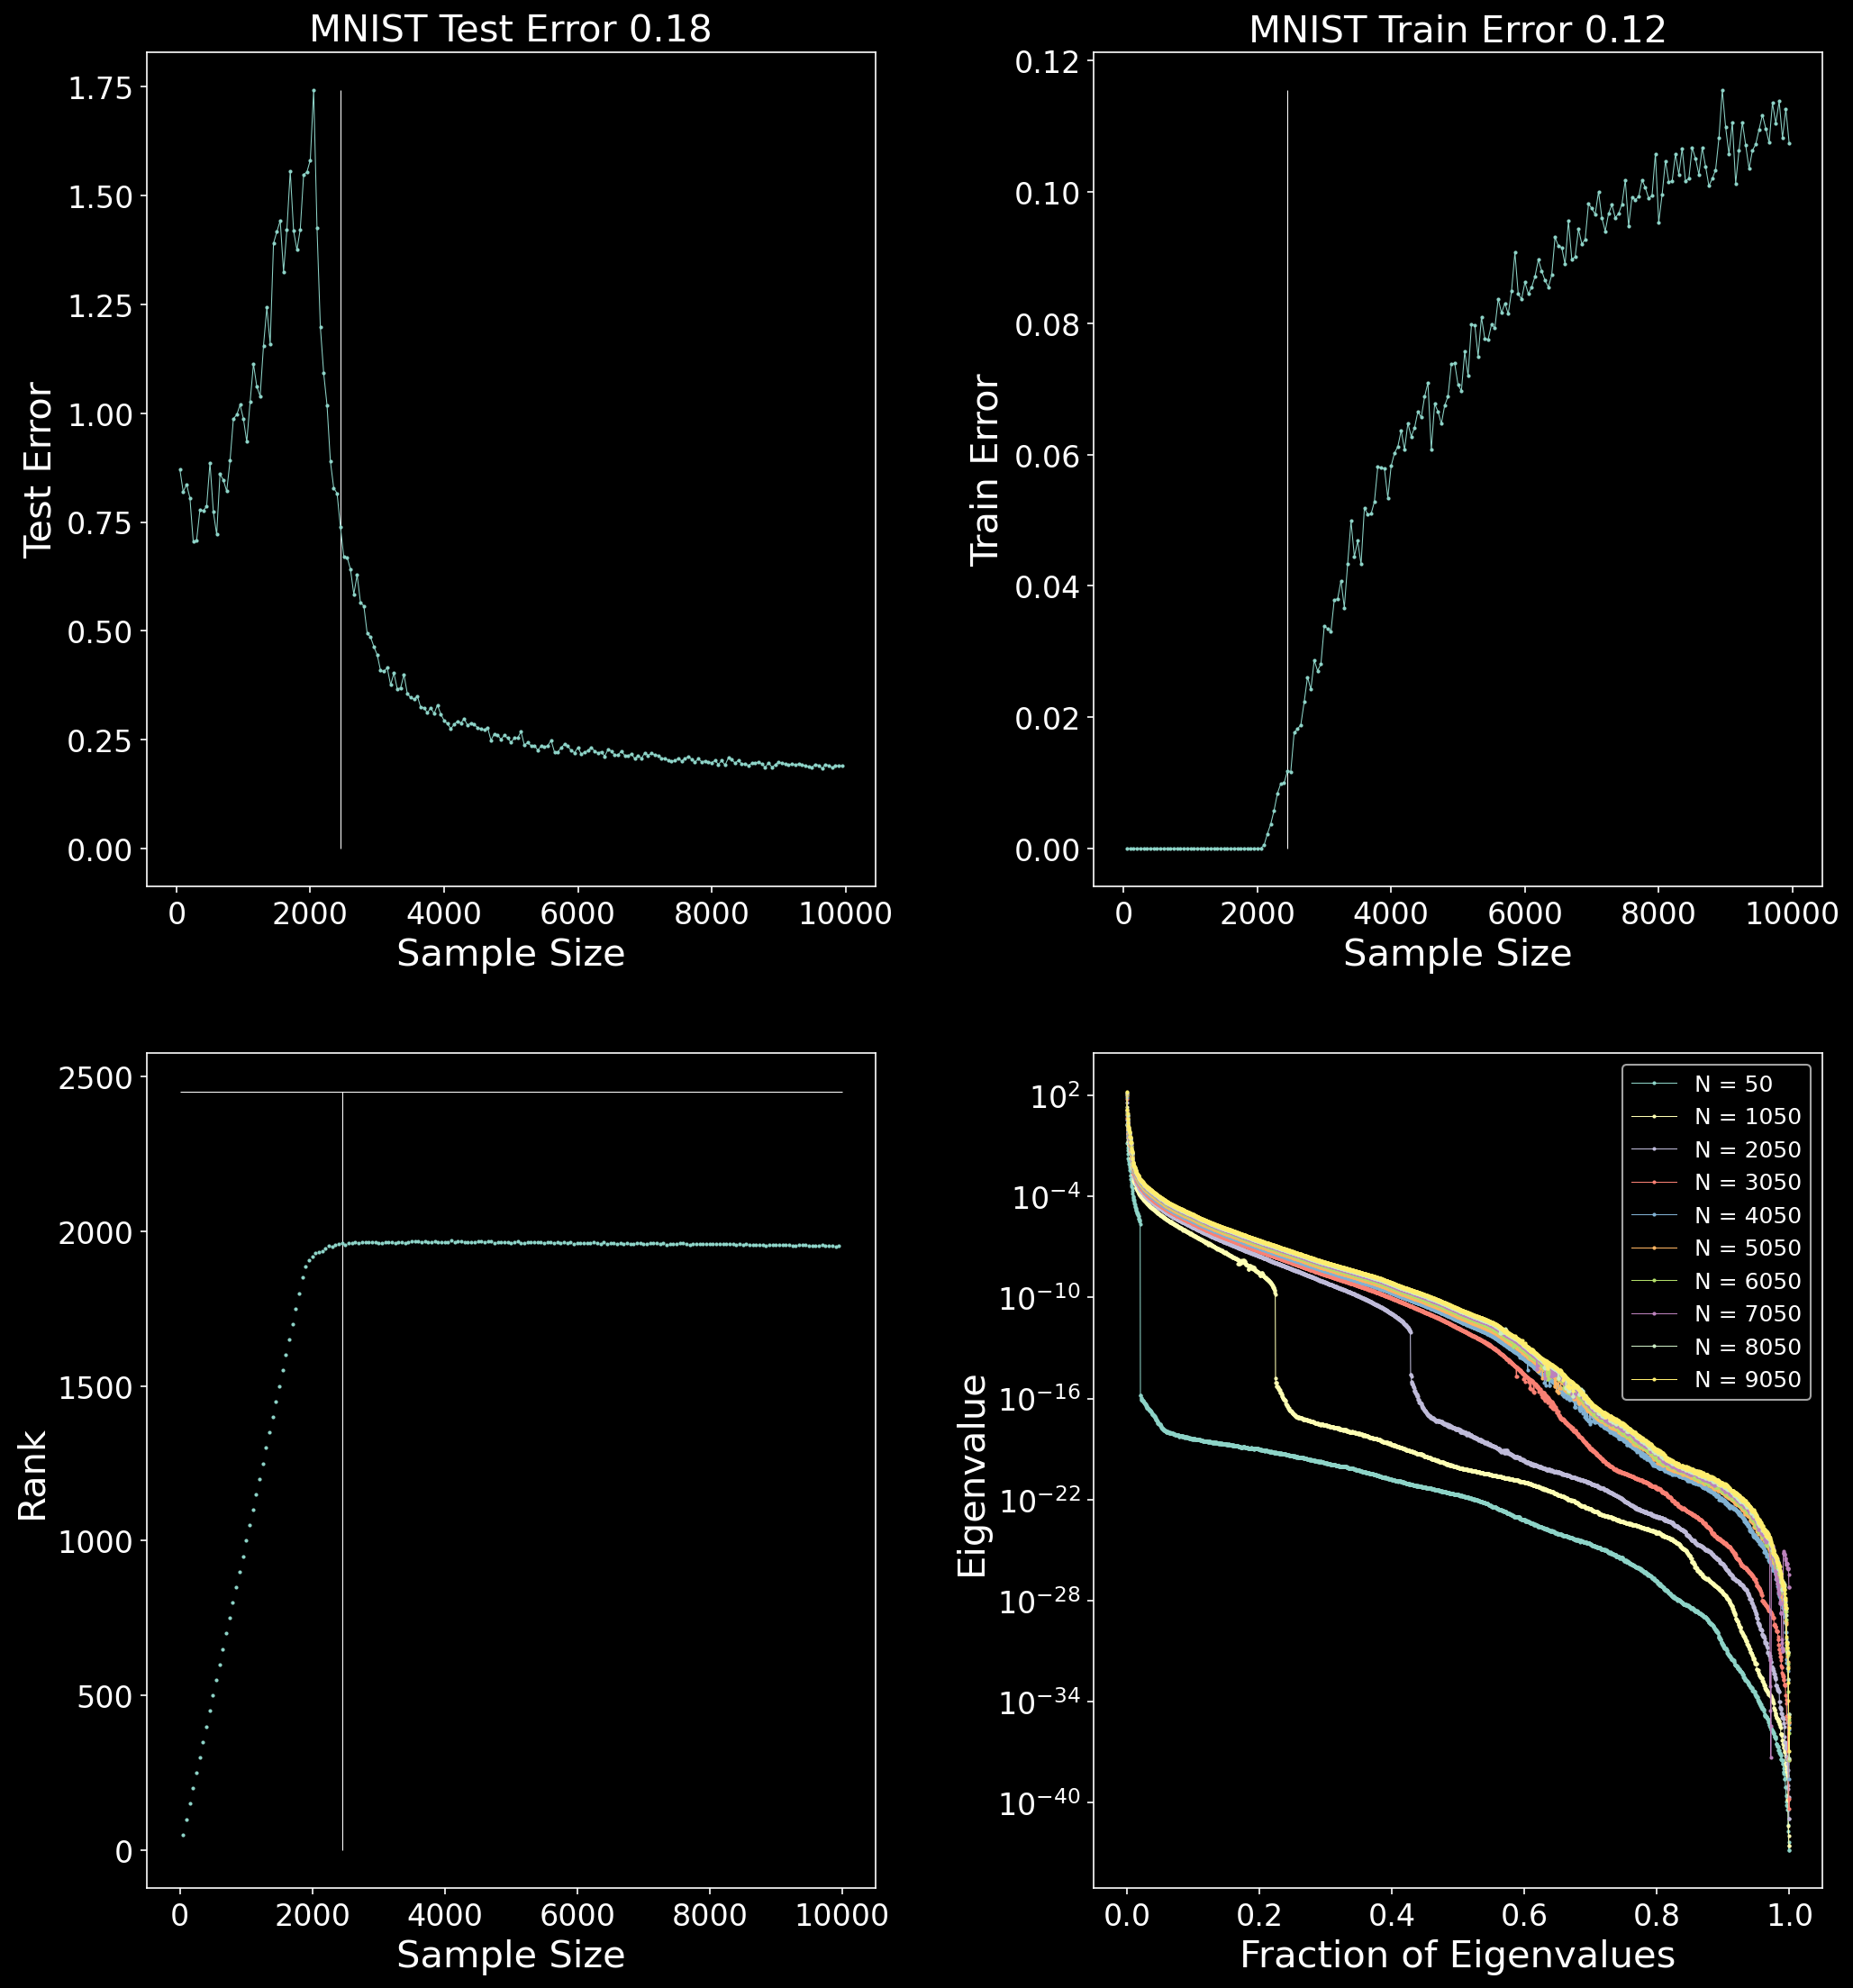

In [151]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 2452

ax = fig.add_subplot(221) 
ax.plot([n for n in range(50,10000,50)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(50,10000,50)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(50,10000,50)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(50,10000,1000)):
    ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [199]:
X_tr = mnist_DHC_out_sizetrain
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(10,5000,30):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    
hf = h5py.File('../scratch_AKS/ddesc_7pi8_noiso_narrow.h5', 'w')
hf.create_dataset('eval_list', data=eval_list)
hf.create_dataset('test_prec', data=test_prec)
hf.create_dataset('train_prec', data=train_prec)
hf.create_dataset('test_prec_class', data=test_prec_class)
hf.create_dataset('rank', data=rank)
hf.close()

In [204]:
eval_list =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_narrow.h5','eval_list')
test_prec =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_narrow.h5','test_prec')
train_prec =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_narrow.h5','train_prec')
test_prec_class =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_narrow.h5','test_prec_class')
rank =hd5_open('../../DHC/scratch_AKS/ddesc_7pi8_noiso_narrow.h5','rank')

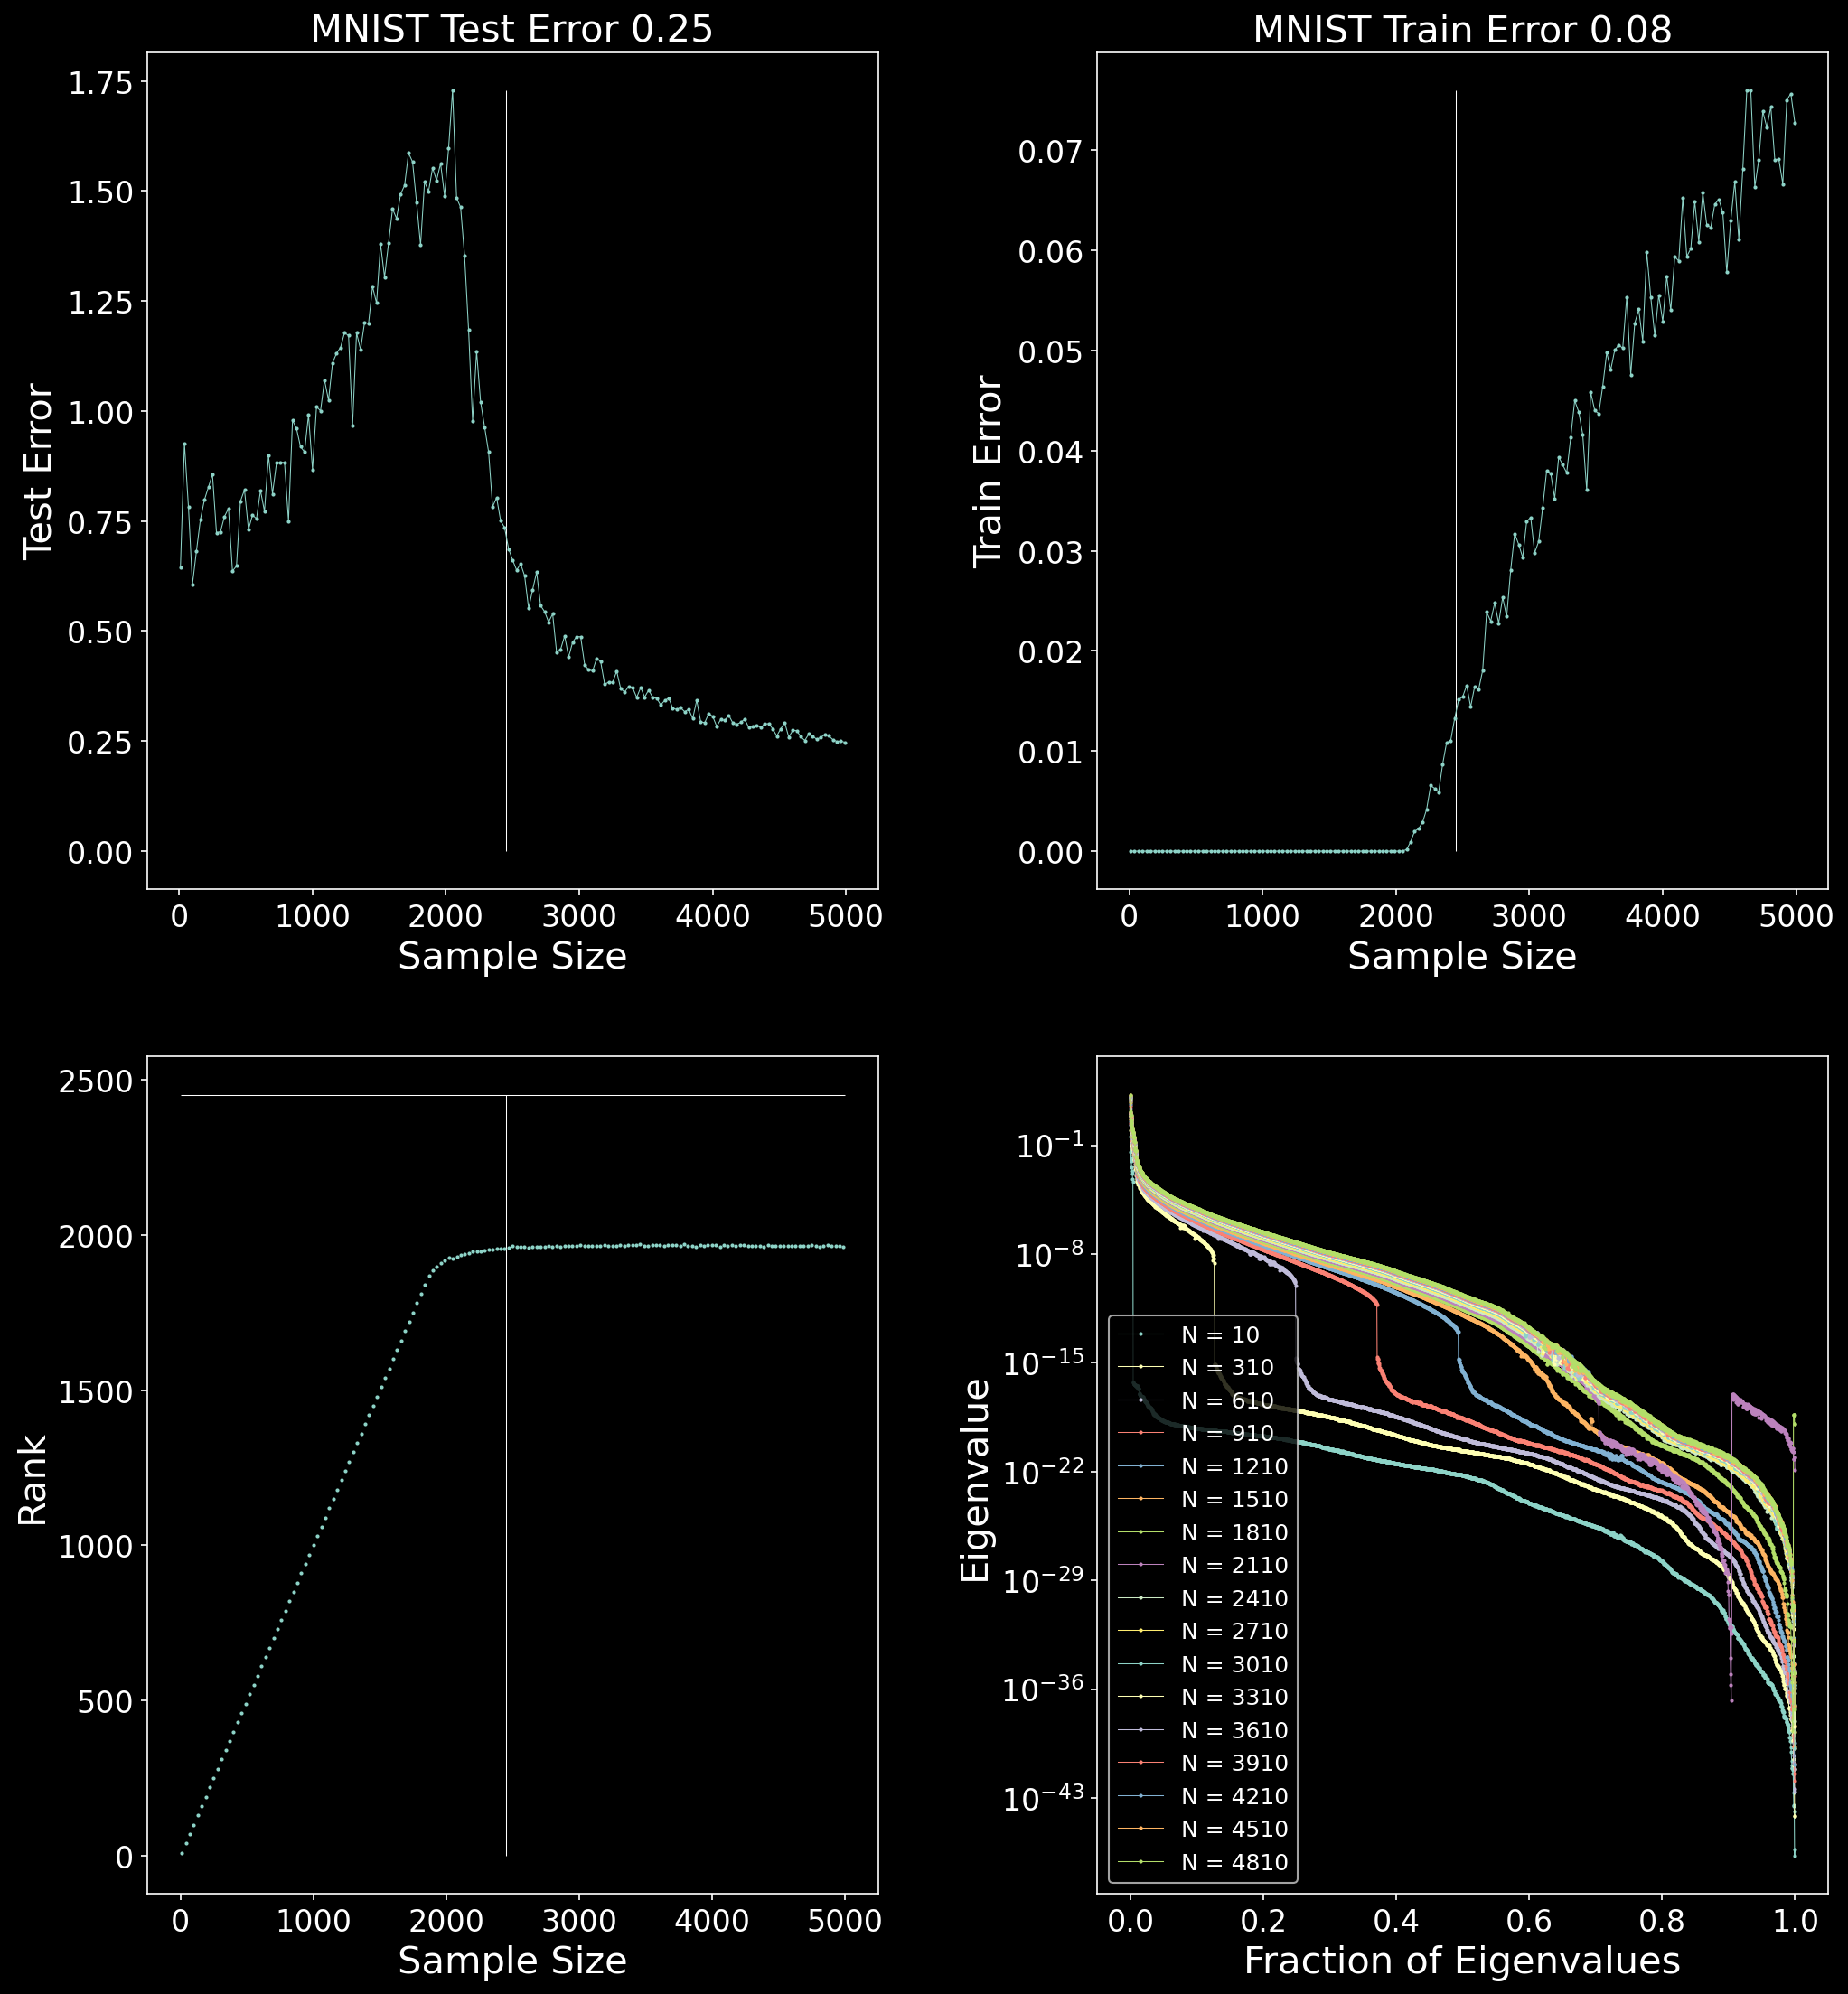

In [205]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 2452

ax = fig.add_subplot(221) 
ax.plot([n for n in range(10,5000,30)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(10,5000,30)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(10,5000,30)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,5000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(10,5000,300)):
    ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [200]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
rank = []

for n in range(10,5000,30):
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    
hf = h5py.File('../scratch_AKS/ddesc_7pi8_noiso_log_narrow.h5', 'w')
hf.create_dataset('eval_list', data=eval_list)
hf.create_dataset('test_prec', data=test_prec)
hf.create_dataset('train_prec', data=train_prec)
hf.create_dataset('test_prec_class', data=test_prec_class)
hf.create_dataset('rank', data=rank)
hf.close()

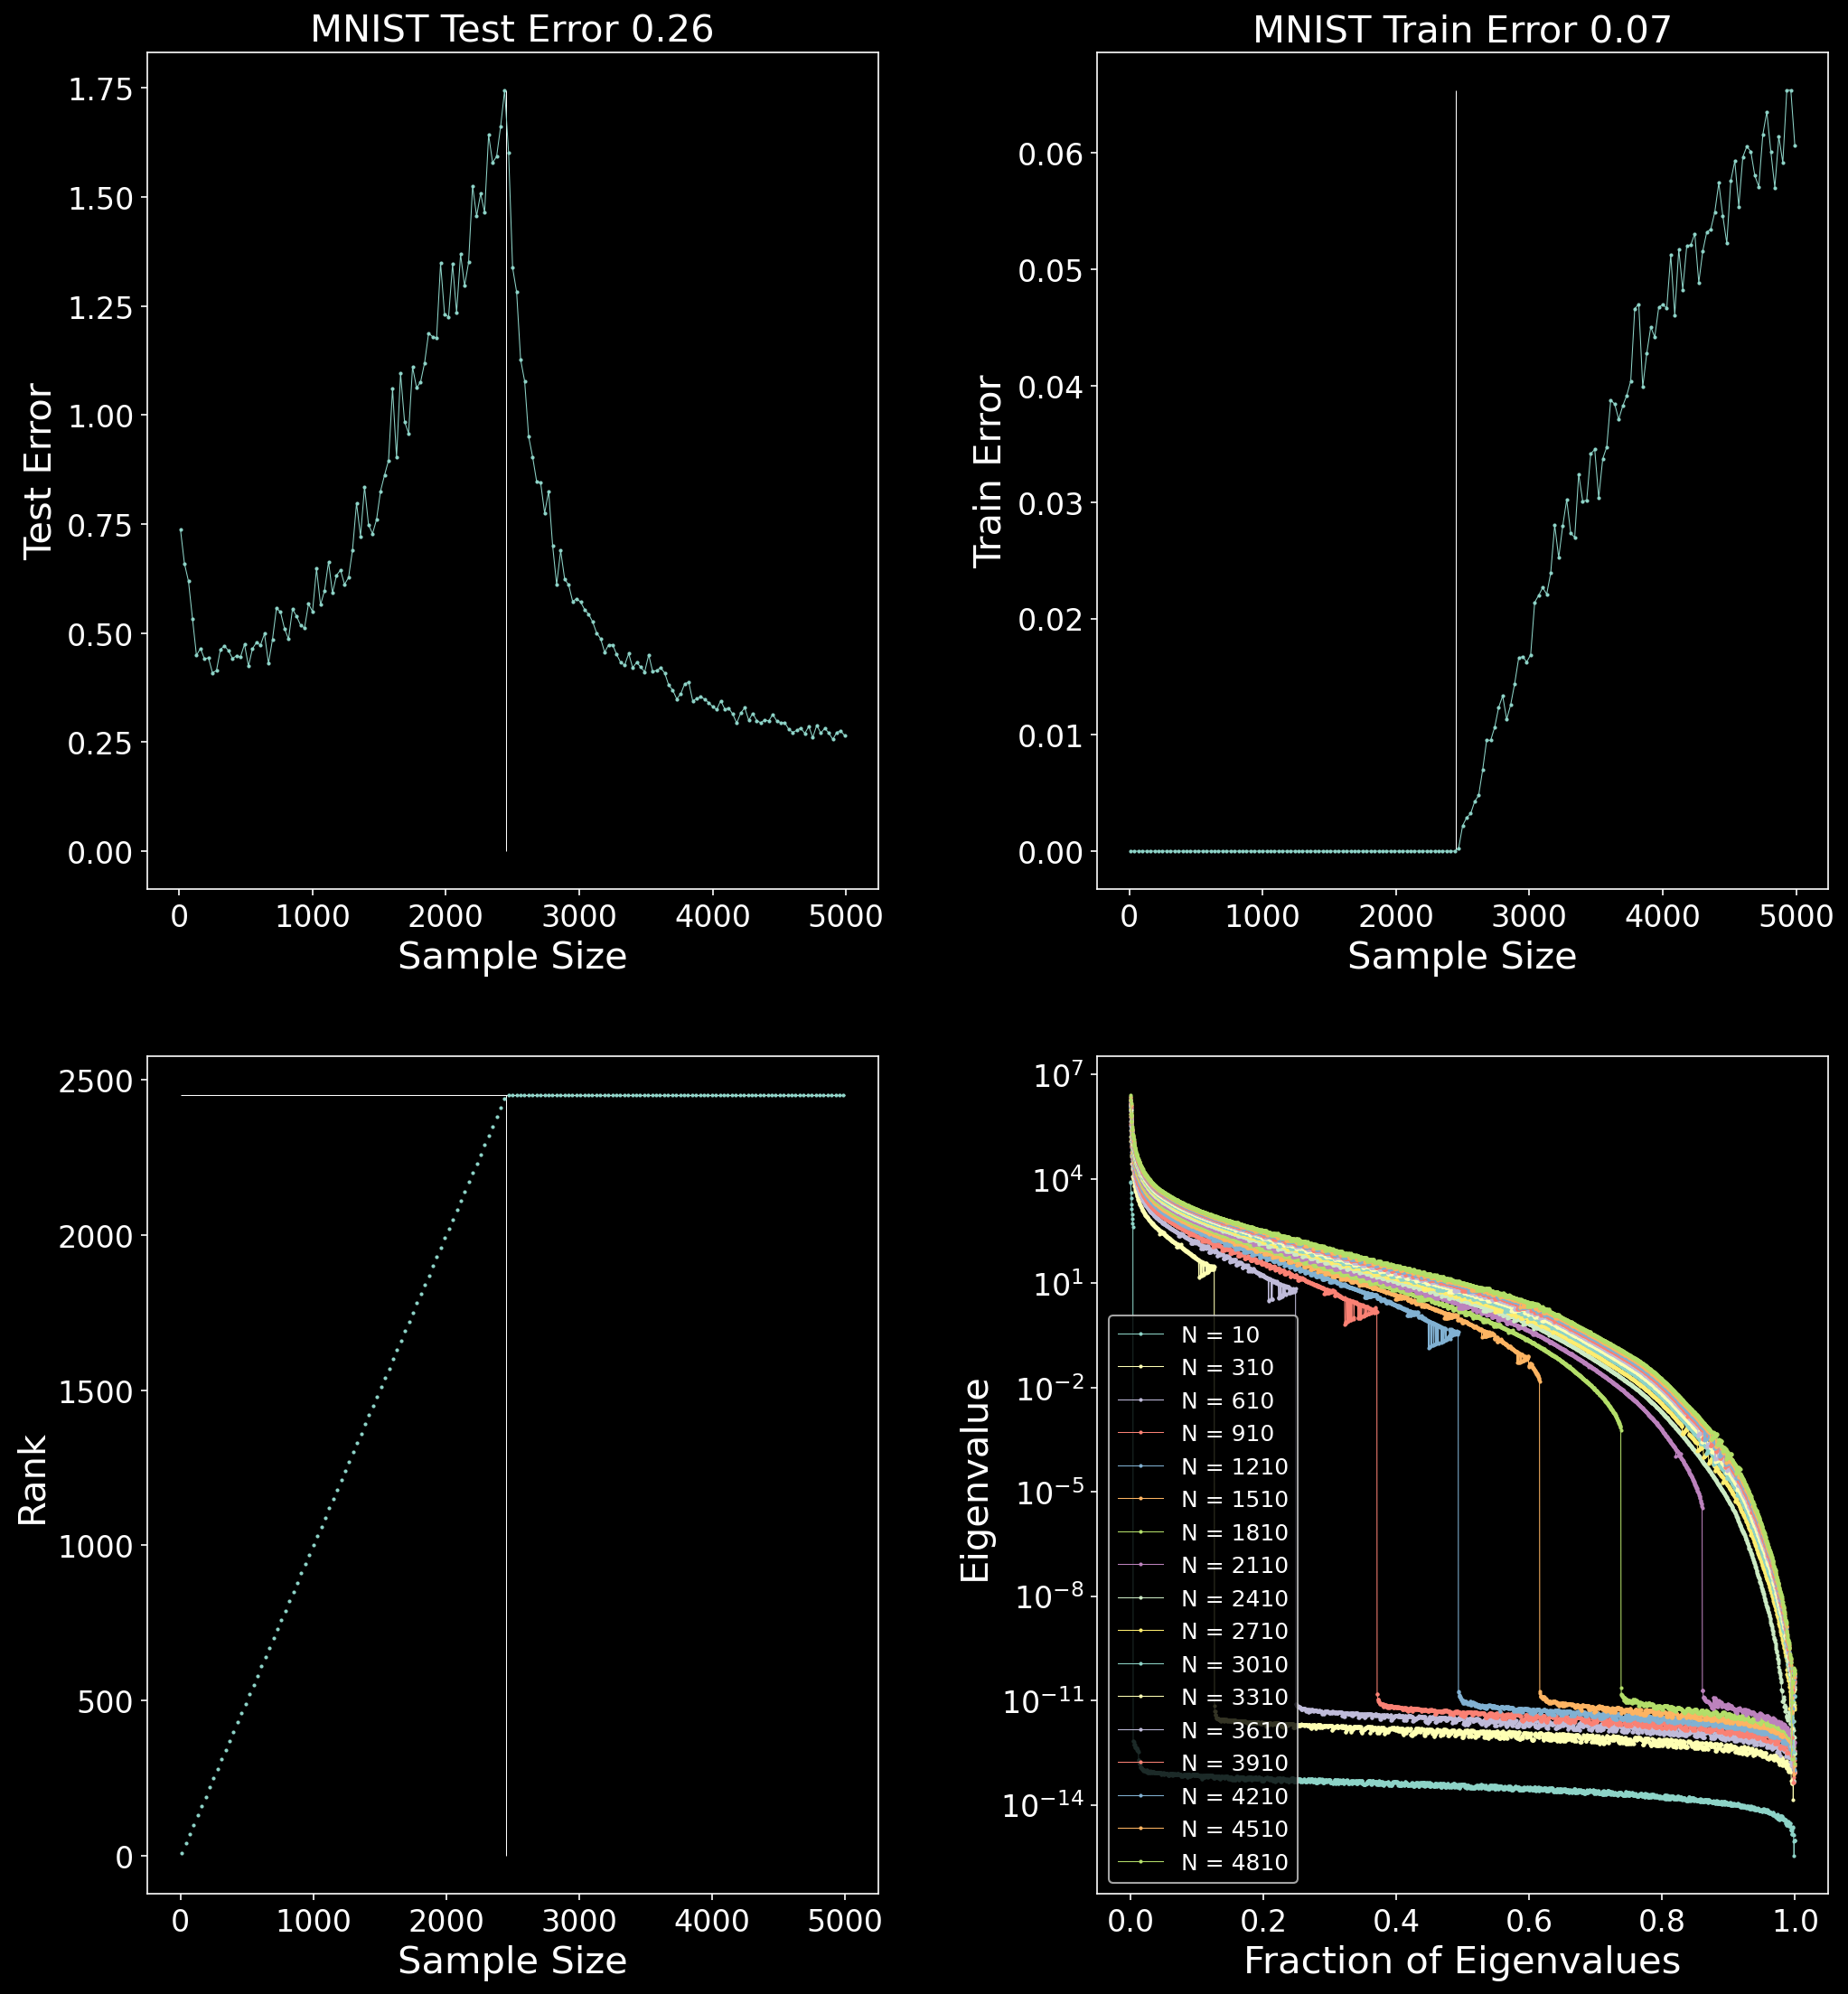

In [203]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 2452

ax = fig.add_subplot(221) 
ax.plot([n for n in range(10,5000,30)],test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot([n for n in range(10,5000,30)],train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot([n for n in range(10,5000,30)],rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,5000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(range(10,5000,300)):
    ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[10*indx]), 
            linestyle='-', 
            marker='o',
            label='N = {}'.format(n),
            markersize=1,
            linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

Other ideas:
x watch your train error as a function of the number of large eval you keep in the matrix.
- repeat experiments above on multi-angle dataset
- implement one-hot encoding and classification plots

In [175]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain_iso))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest_iso))

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
num_eval = []
cutoff = []

for rcond in np.logspace(-15,-3,40):
    n = 10000
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    u, s, vt = np.linalg.svd(X.conjugate(), full_matrices=False)
    eval_list.append(s)
    cutoff.append(rcond*np.max(s))
    num_eval.append(np.count_nonzero(s>rcond*np.max(s)))
    X_inv1 = np.linalg.pinv(X,rcond=rcond)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

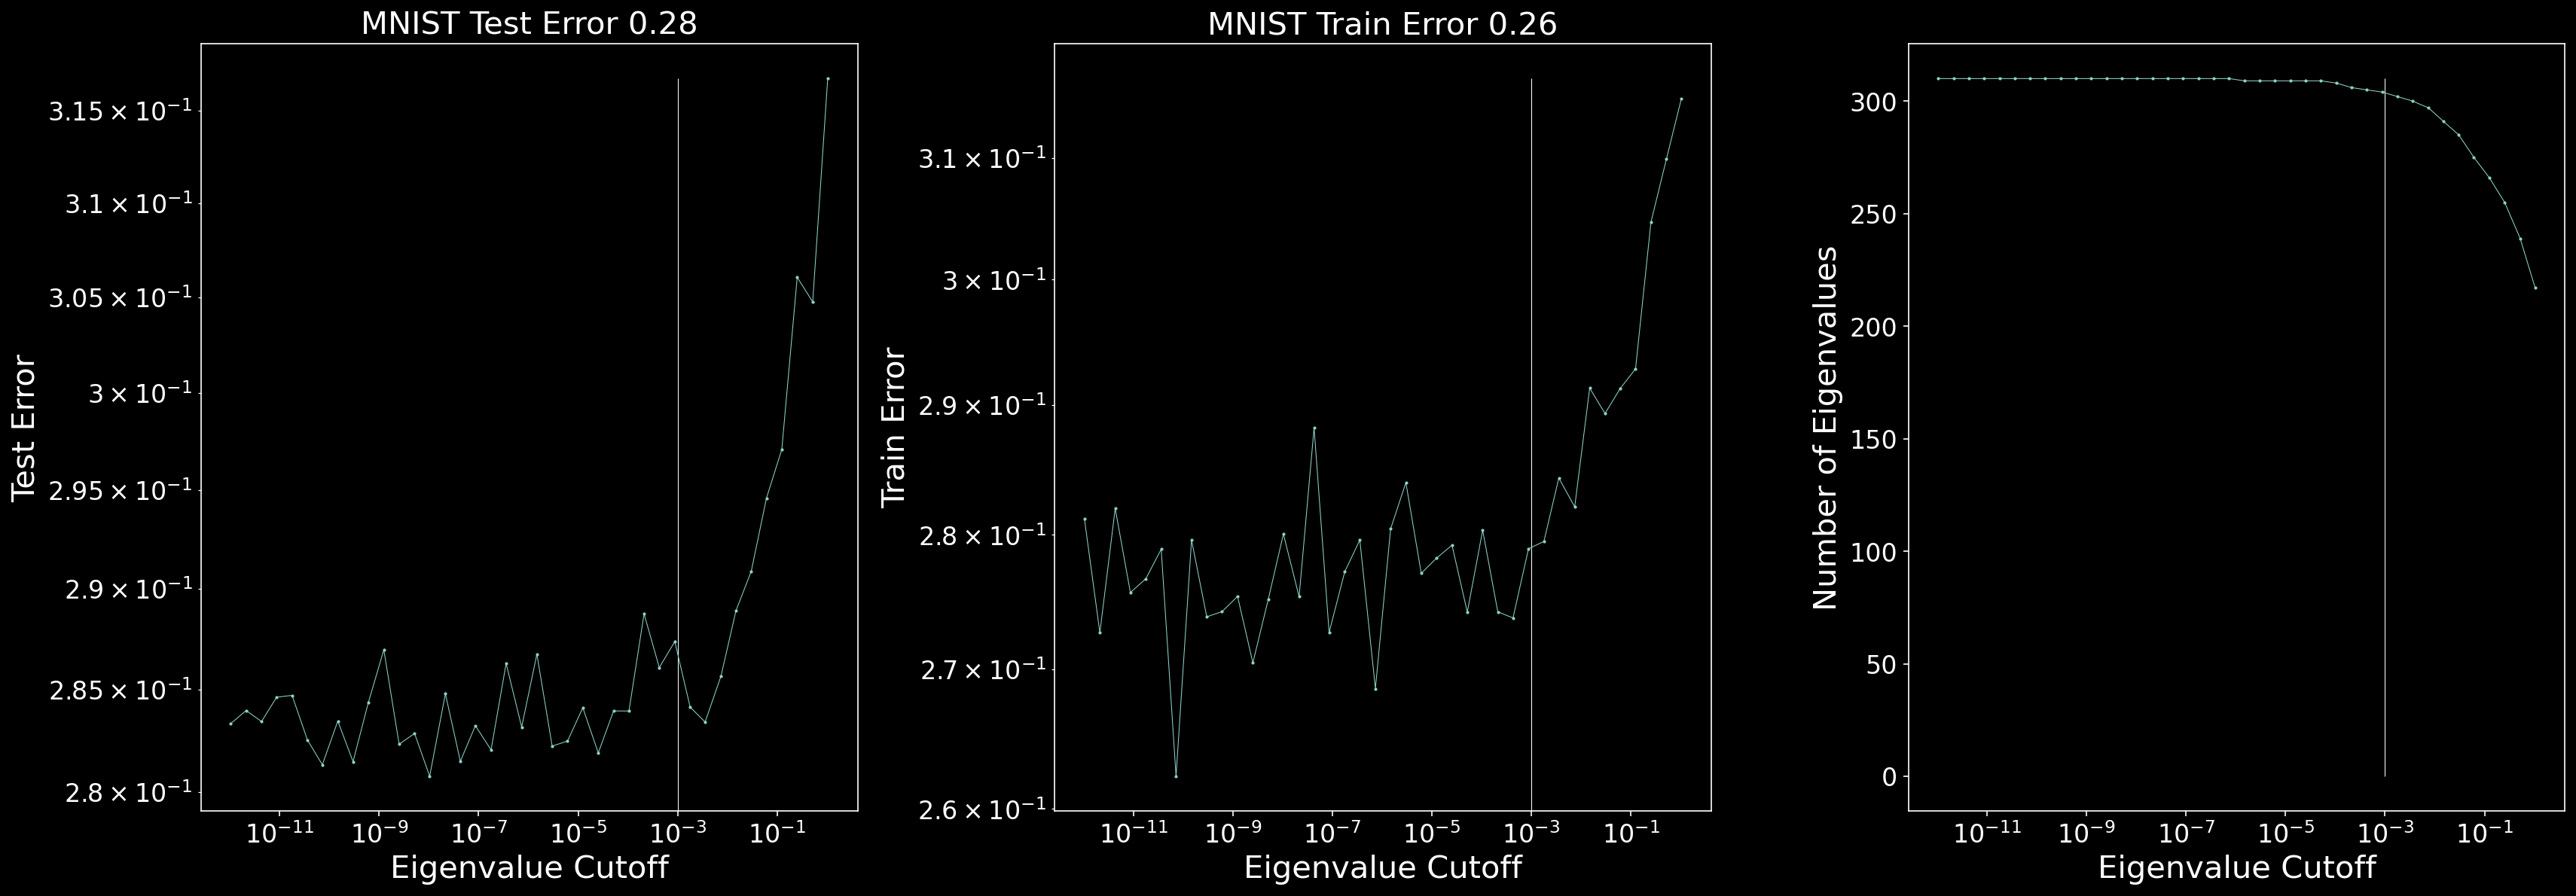

In [184]:
fig = plt.figure(figsize=(27,9),dpi=150)
n_coeff = 310
x = np.logspace(-15,-3,40)

ax = fig.add_subplot(131) 
ax.plot(cutoff,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Test Error')
plt.xscale('log')
plt.yscale('log')
plt.vlines(.001,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))

ax = fig.add_subplot(132) 
ax.plot(cutoff,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Train Error')
plt.vlines(.001,0,np.max(test_prec),'w',linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('MNIST Train Error {:.2f}'.format(np.min(train_prec)))

ax = fig.add_subplot(133) 
ax.plot(cutoff,num_eval, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Number of Eigenvalues')
plt.vlines(.001,0,np.max(num_eval),'w',linewidth=0.5)
plt.xscale('log')

fig.subplots_adjust(wspace=0.3, hspace=0)

In [185]:
sc = StandardScaler()

X_tr = mnist_DHC_out_sizetrain_iso
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = mnist_DHC_out_sizetest_iso

eval_list =[]
test_prec =[]
train_prec =[]
test_prec_class = []
num_eval = []
cutoff = []

for rcond in np.logspace(-15,-3,40):
    n = 10000
    I = np.random.choice(len(X_tr), n, replace=False)
    X = X_tr[I]
    Y = Y_tr[I]
    u, s, vt = np.linalg.svd(X.conjugate(), full_matrices=False)
    eval_list.append(s)
    cutoff.append(rcond*np.max(s))
    num_eval.append(np.count_nonzero(s>rcond*np.max(s)))
    X_inv1 = np.linalg.pinv(X,rcond=rcond)
    est = np.matmul(X_inv1,Y)
    vec = np.matmul(X_test,est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))

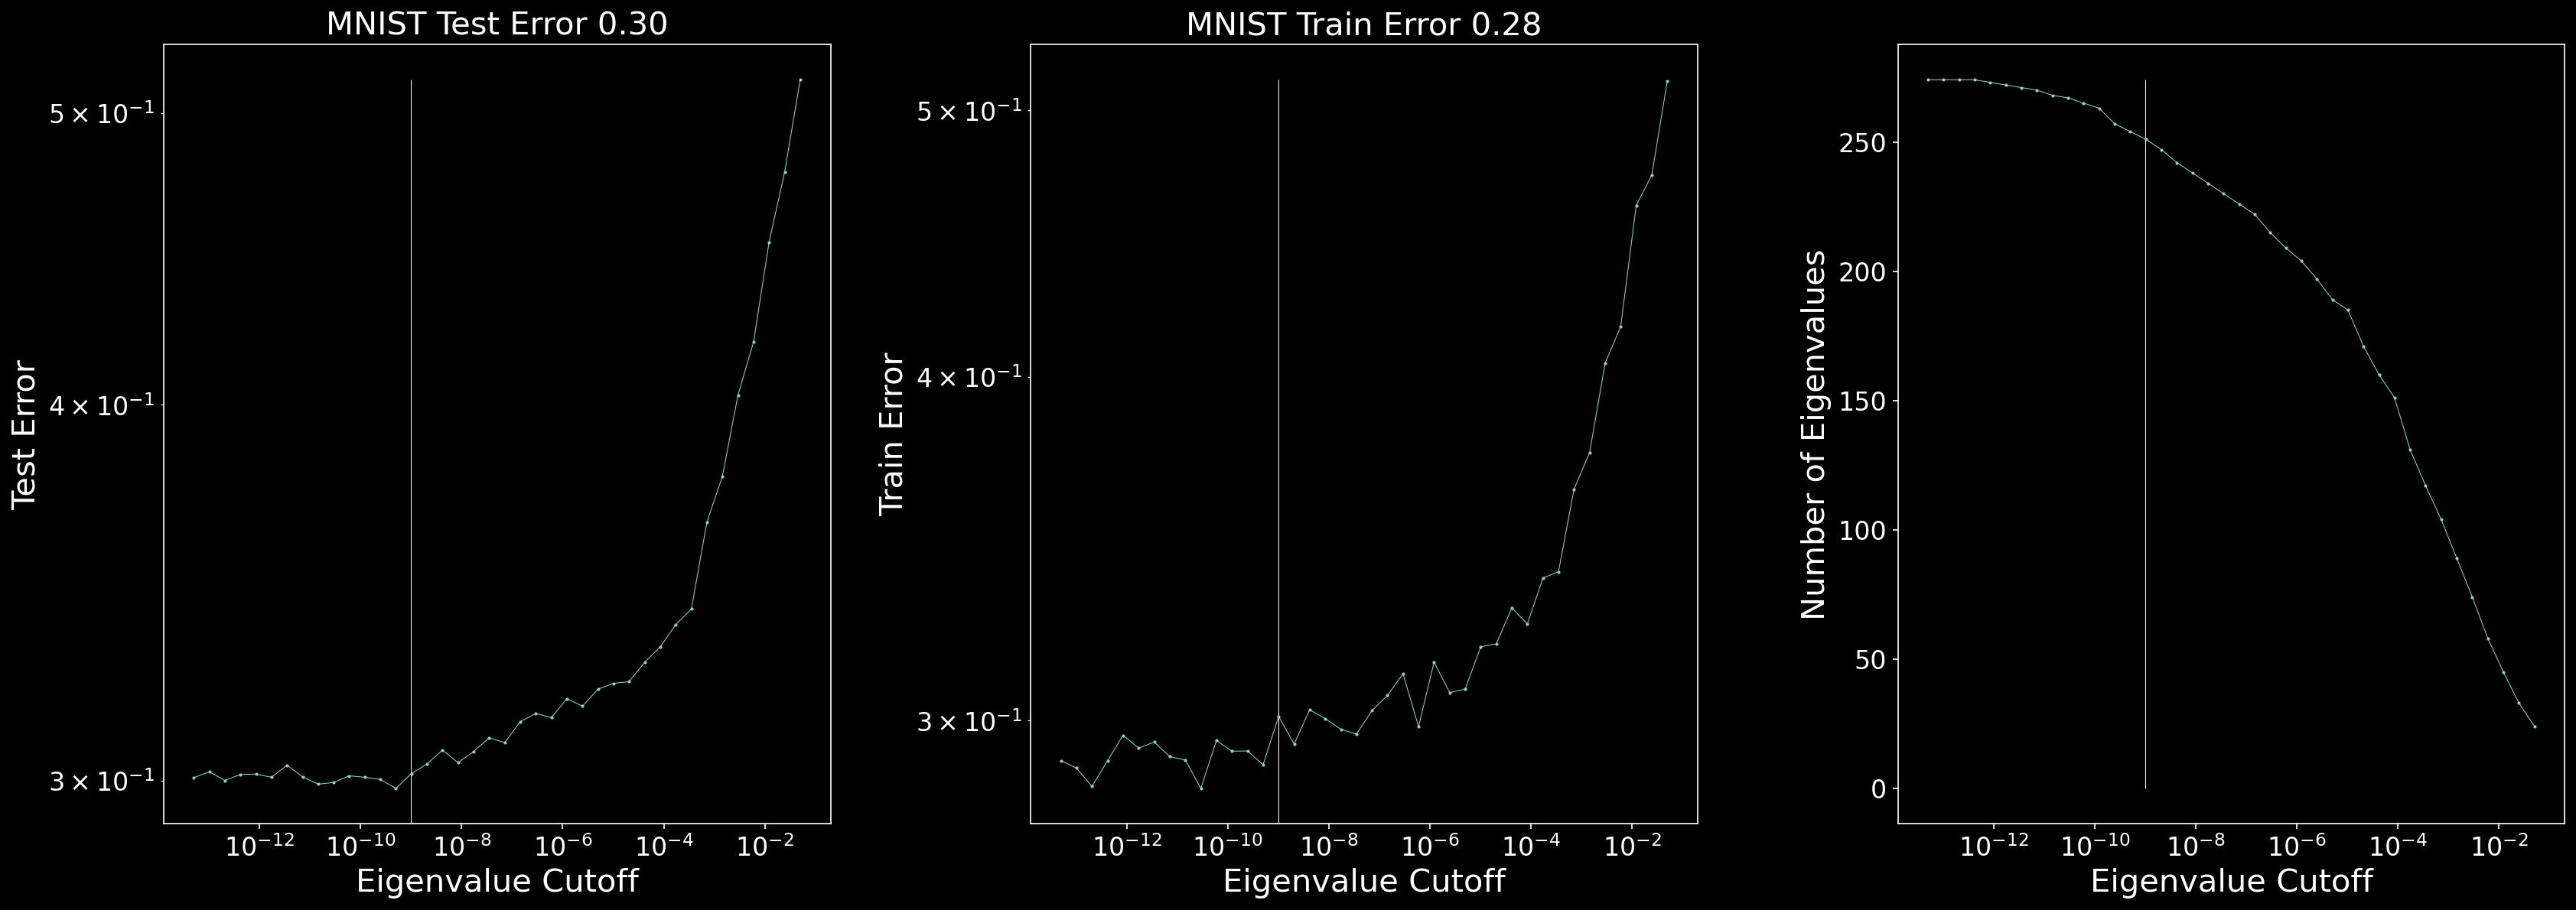

In [187]:
fig = plt.figure(figsize=(27,9),dpi=150)
n_coeff = 310
x = np.logspace(-15,-3,40)

ax = fig.add_subplot(131) 
ax.plot(cutoff,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Test Error')
plt.xscale('log')
plt.yscale('log')
plt.vlines(1e-9,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))

ax = fig.add_subplot(132) 
ax.plot(cutoff,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Train Error')
plt.vlines(1e-9,0,np.max(test_prec),'w',linewidth=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('MNIST Train Error {:.2f}'.format(np.min(train_prec)))

ax = fig.add_subplot(133) 
ax.plot(cutoff,num_eval, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Eigenvalue Cutoff')
plt.ylabel('Number of Eigenvalues')
plt.vlines(1e-9,0,np.max(num_eval),'w',linewidth=0.5)
plt.xscale('log')

fig.subplots_adjust(wspace=0.3, hspace=0)

In [4]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_21/mnist_DHC_train_ang_1_1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_21/mnist_DHC_test_ang_1_1.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_train = DHC_iso_vec(mnist_DHC_out_sizetrain,5,8)

In [211]:
mnist_DHC_out_size_iso.shape,mnist_DHC_out_size_iso_train.shape

((1000000, 219), (360000, 219))

In [212]:
X_test[0::100,:].shape

(3600, 219)

In [268]:
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_size_iso_train))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_size_iso))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

for indx, i in enumerate(np.linspace(0.0002,0.028,90)):
    X, x_throw, Y, y_throw = train_test_split(
        X_tr, 
        np.repeat(Y_tr,6), 
        stratify=np.repeat(mnist_train_y,6)+np.tile((np.arange(6))*10,60000), 
        train_size=i,
        random_state=int(i*10000))
    
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)

    vec = np.matmul(X_test[14::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

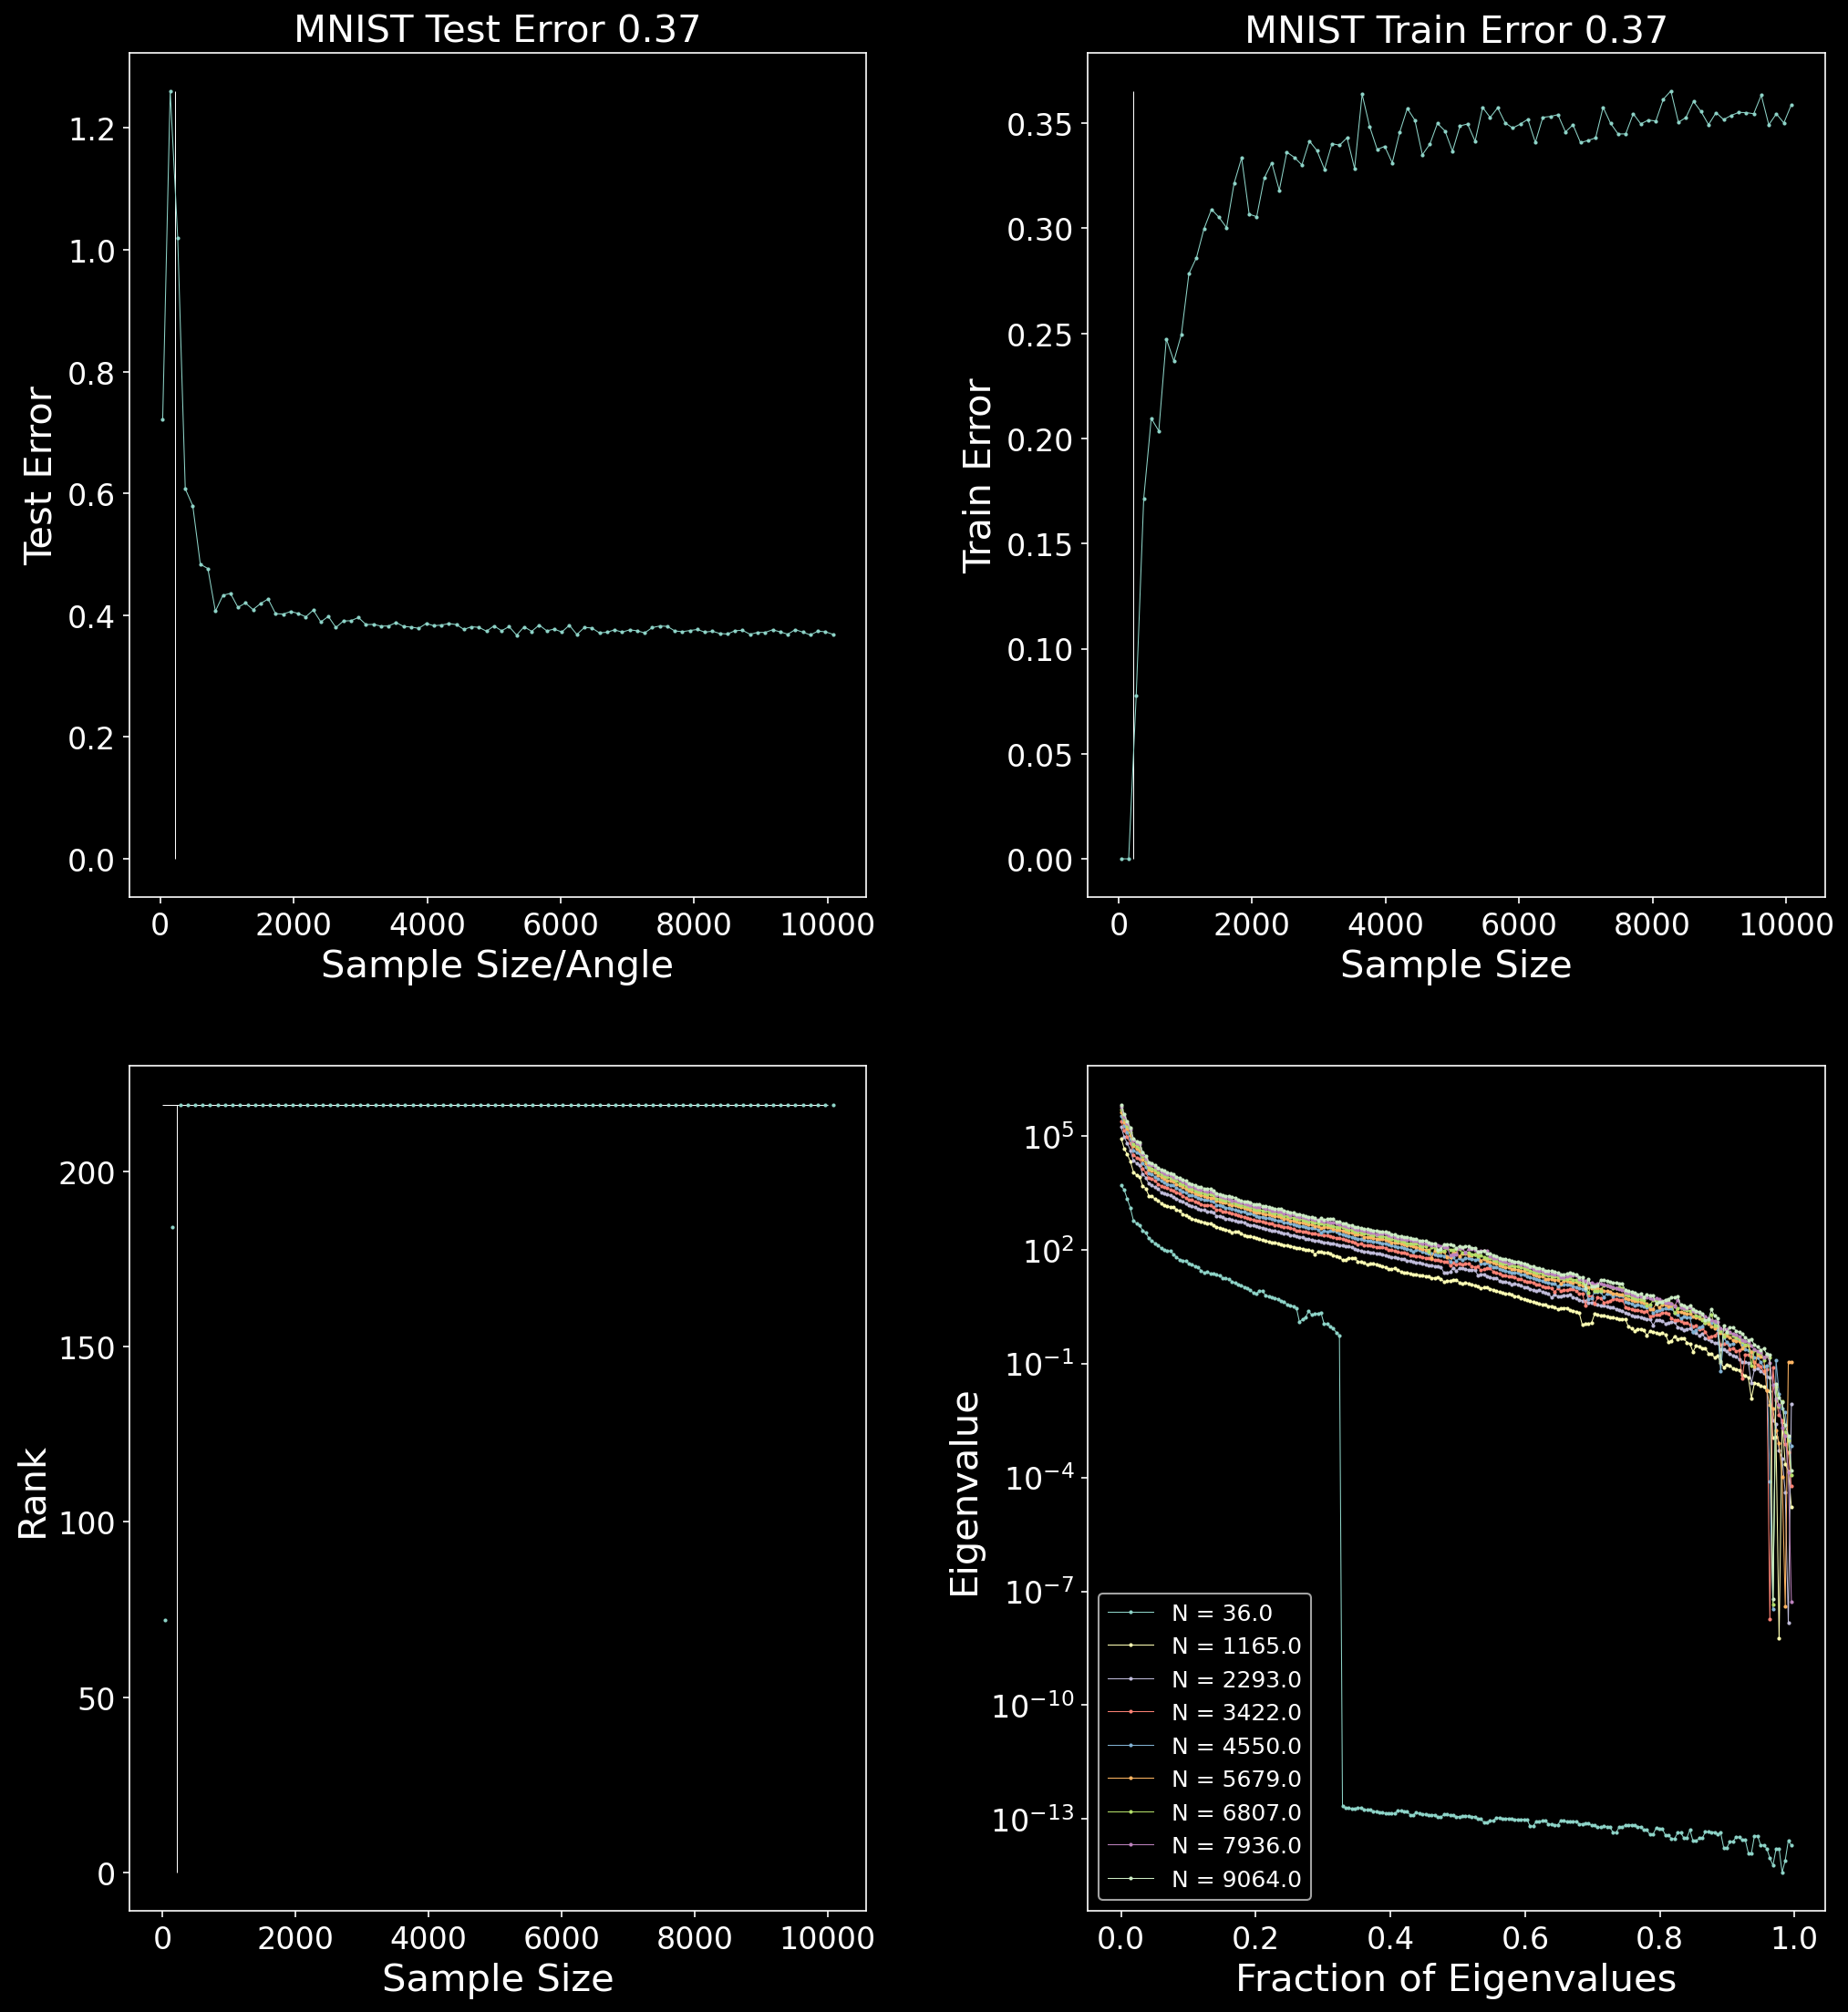

In [269]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 219
x = np.linspace(0.0001,0.028,90)

ax = fig.add_subplot(221) 
ax.plot(x*360000,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size/Angle')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot(x*360000,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot(x*360000,rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(x*360000):
    if np.mod(indx,10)==0:
        ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[indx]), 
                linestyle='-', 
                marker='o',
                label='N = {}'.format(np.round(n)),
                markersize=1,
                linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [266]:
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_size_iso_train))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_size_iso))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

for indx, i in enumerate(np.linspace(0.0002,0.0056,90)):
    X, x_throw, Y, y_throw = train_test_split(
        X_tr, 
        np.repeat(Y_tr,6), 
        stratify=np.repeat(mnist_train_y,6)+np.tile((np.arange(6))*10,60000), 
        train_size=i,
        random_state=int(i*10000))
    
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)

    vec = np.matmul(X_test[14::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

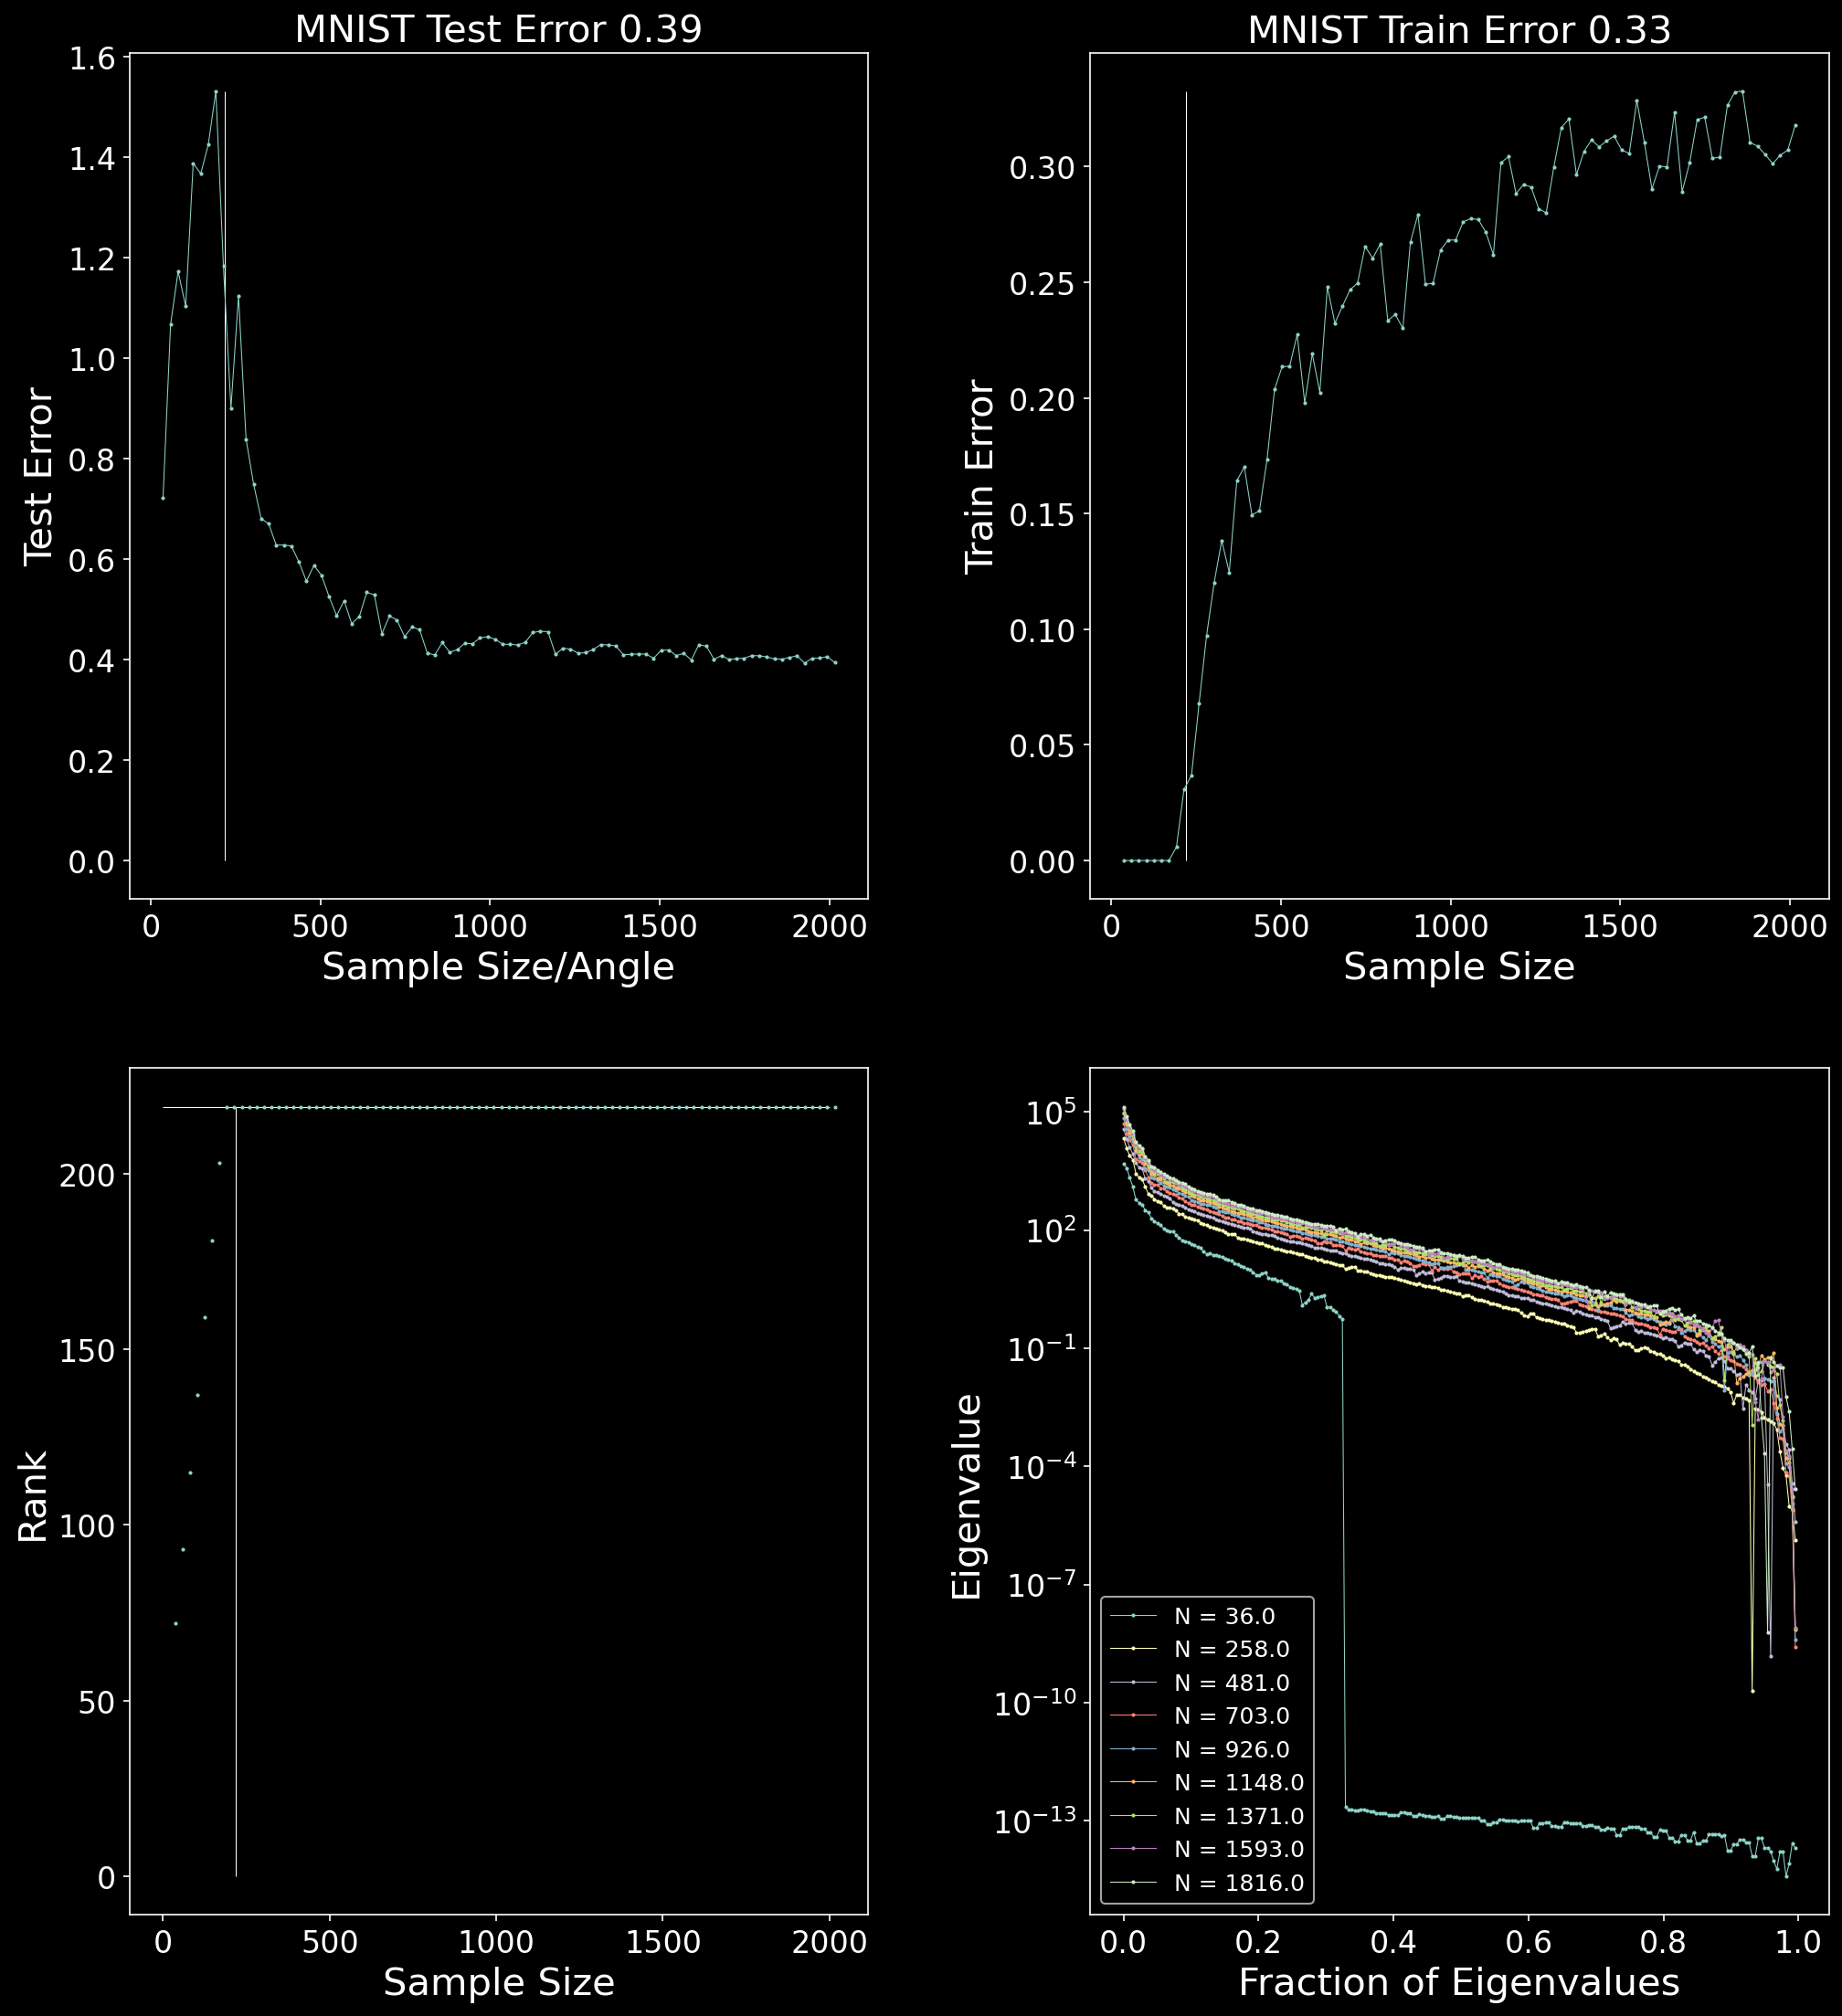

In [267]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 219
x = np.linspace(0.0001,0.0056,90)

ax = fig.add_subplot(221) 
ax.plot(x*360000,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size/Angle')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot(x*360000,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot(x*360000,rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,2000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(x*360000):
    if np.mod(indx,10)==0:
        ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[indx]), 
                linestyle='-', 
                marker='o',
                label='N = {}'.format(np.round(n)),
                markersize=1,
                linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

Do we need to do the regression after throwing out some important directions in order to make the loss stable?

In [260]:
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_size_iso_train))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_size_iso))

test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

X_inv1 = np.linalg.pinv(X_tr)
est = np.matmul(X_inv1,np.repeat(Y_tr,6))
    
for i in range(100):
    vec = np.matmul(X_test[i::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X_tr,est),-1,1)-np.repeat(Y_tr,6))))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

In [5]:
M = 100
angles = [i for i in np.linspace(0,2,M)]

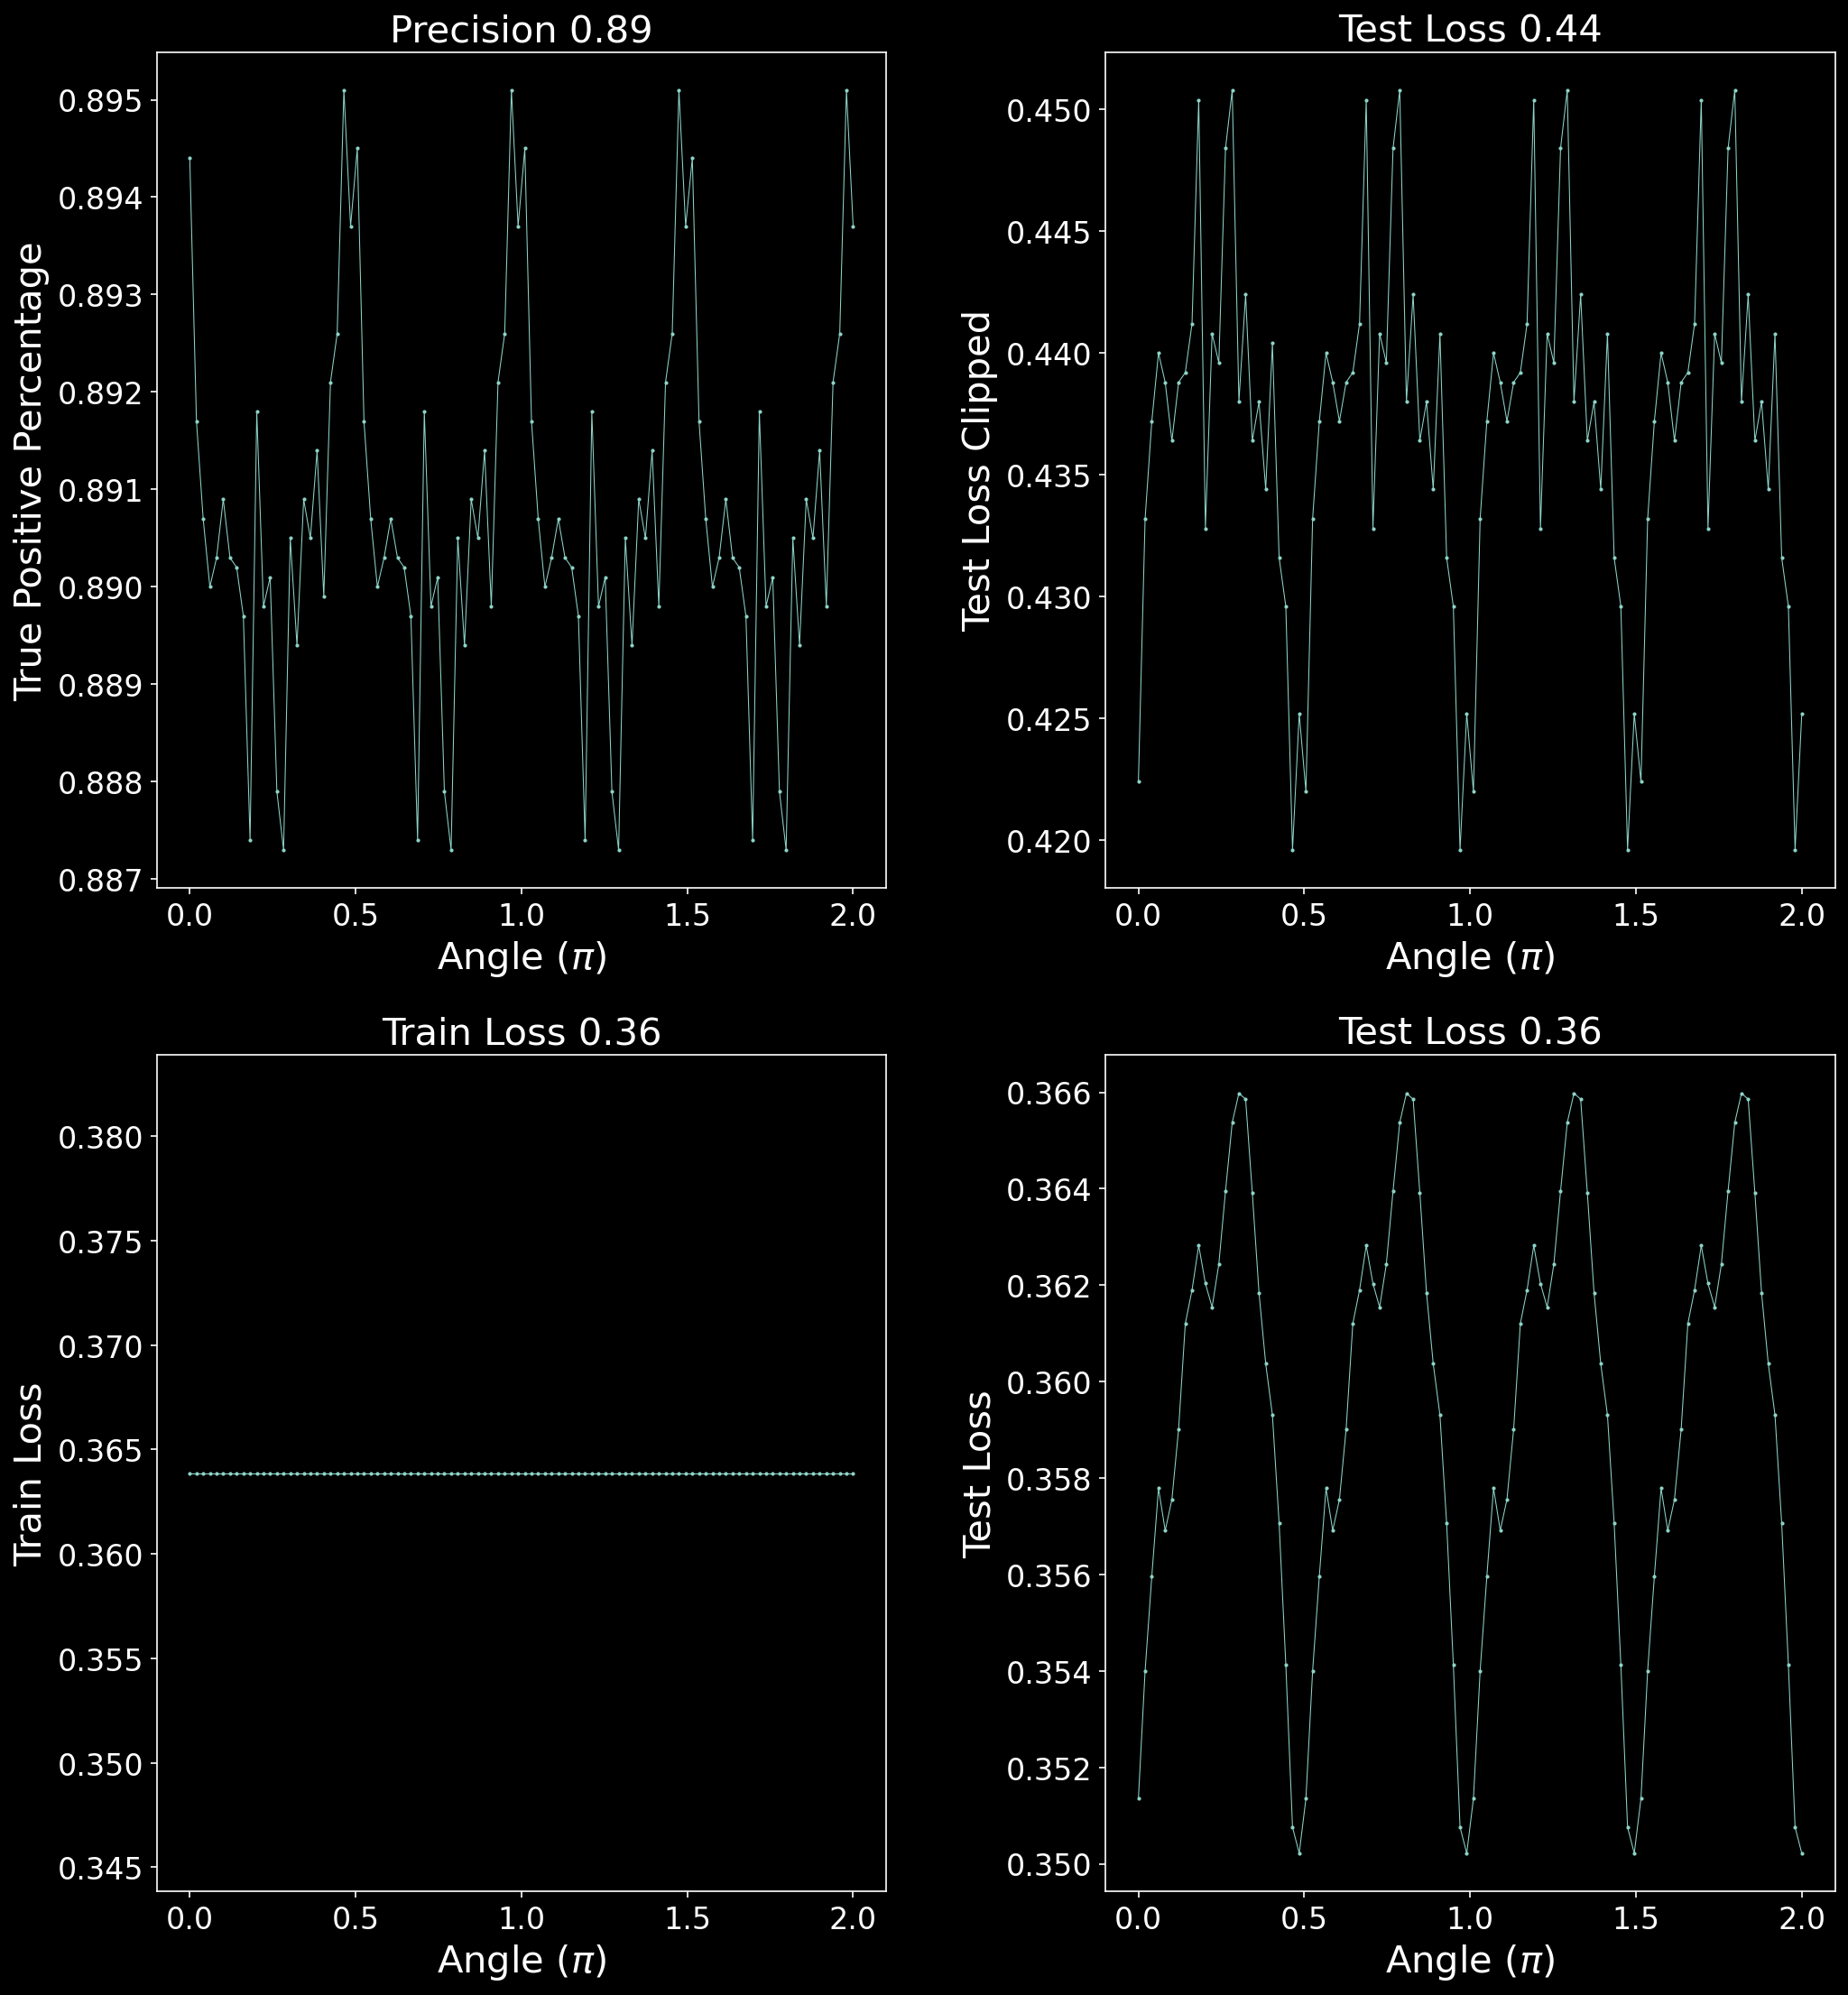

In [262]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot(angles,prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.title('Precision {:.2f}'.format(np.mean(prec)))

ax = fig.add_subplot(222) 
ax.plot(angles,test_prec_class, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Test Loss Clipped')
plt.title('Test Loss {:.2f}'.format(np.mean(test_prec_class)))

ax = fig.add_subplot(223) 
ax.plot(angles,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Train Loss')
plt.title('Train Loss {:.2f}'.format(np.mean(train_prec)))

ax = fig.add_subplot(224) 
ax.plot(angles,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Test Loss')
plt.title('Test Loss {:.2f}'.format(np.mean(test_prec)))

fig.subplots_adjust(wspace=0.3, hspace=0.2)

Noniso Overnight

In [275]:
mnist_DHC_out_sizetrain.shape

(360000, 1724)

In [7]:
sc = StandardScaler()
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

for indx, i in enumerate(np.linspace(0.0002,0.028,90)):
    X, x_throw, Y, y_throw = train_test_split(
        X_tr, 
        np.repeat(Y_tr,6), 
        stratify=np.repeat(mnist_train_y,6)+np.tile((np.arange(6))*10,60000), 
        train_size=i,
        random_state=int(i*10000))
    
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)

    vec = np.matmul(X_test[14::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

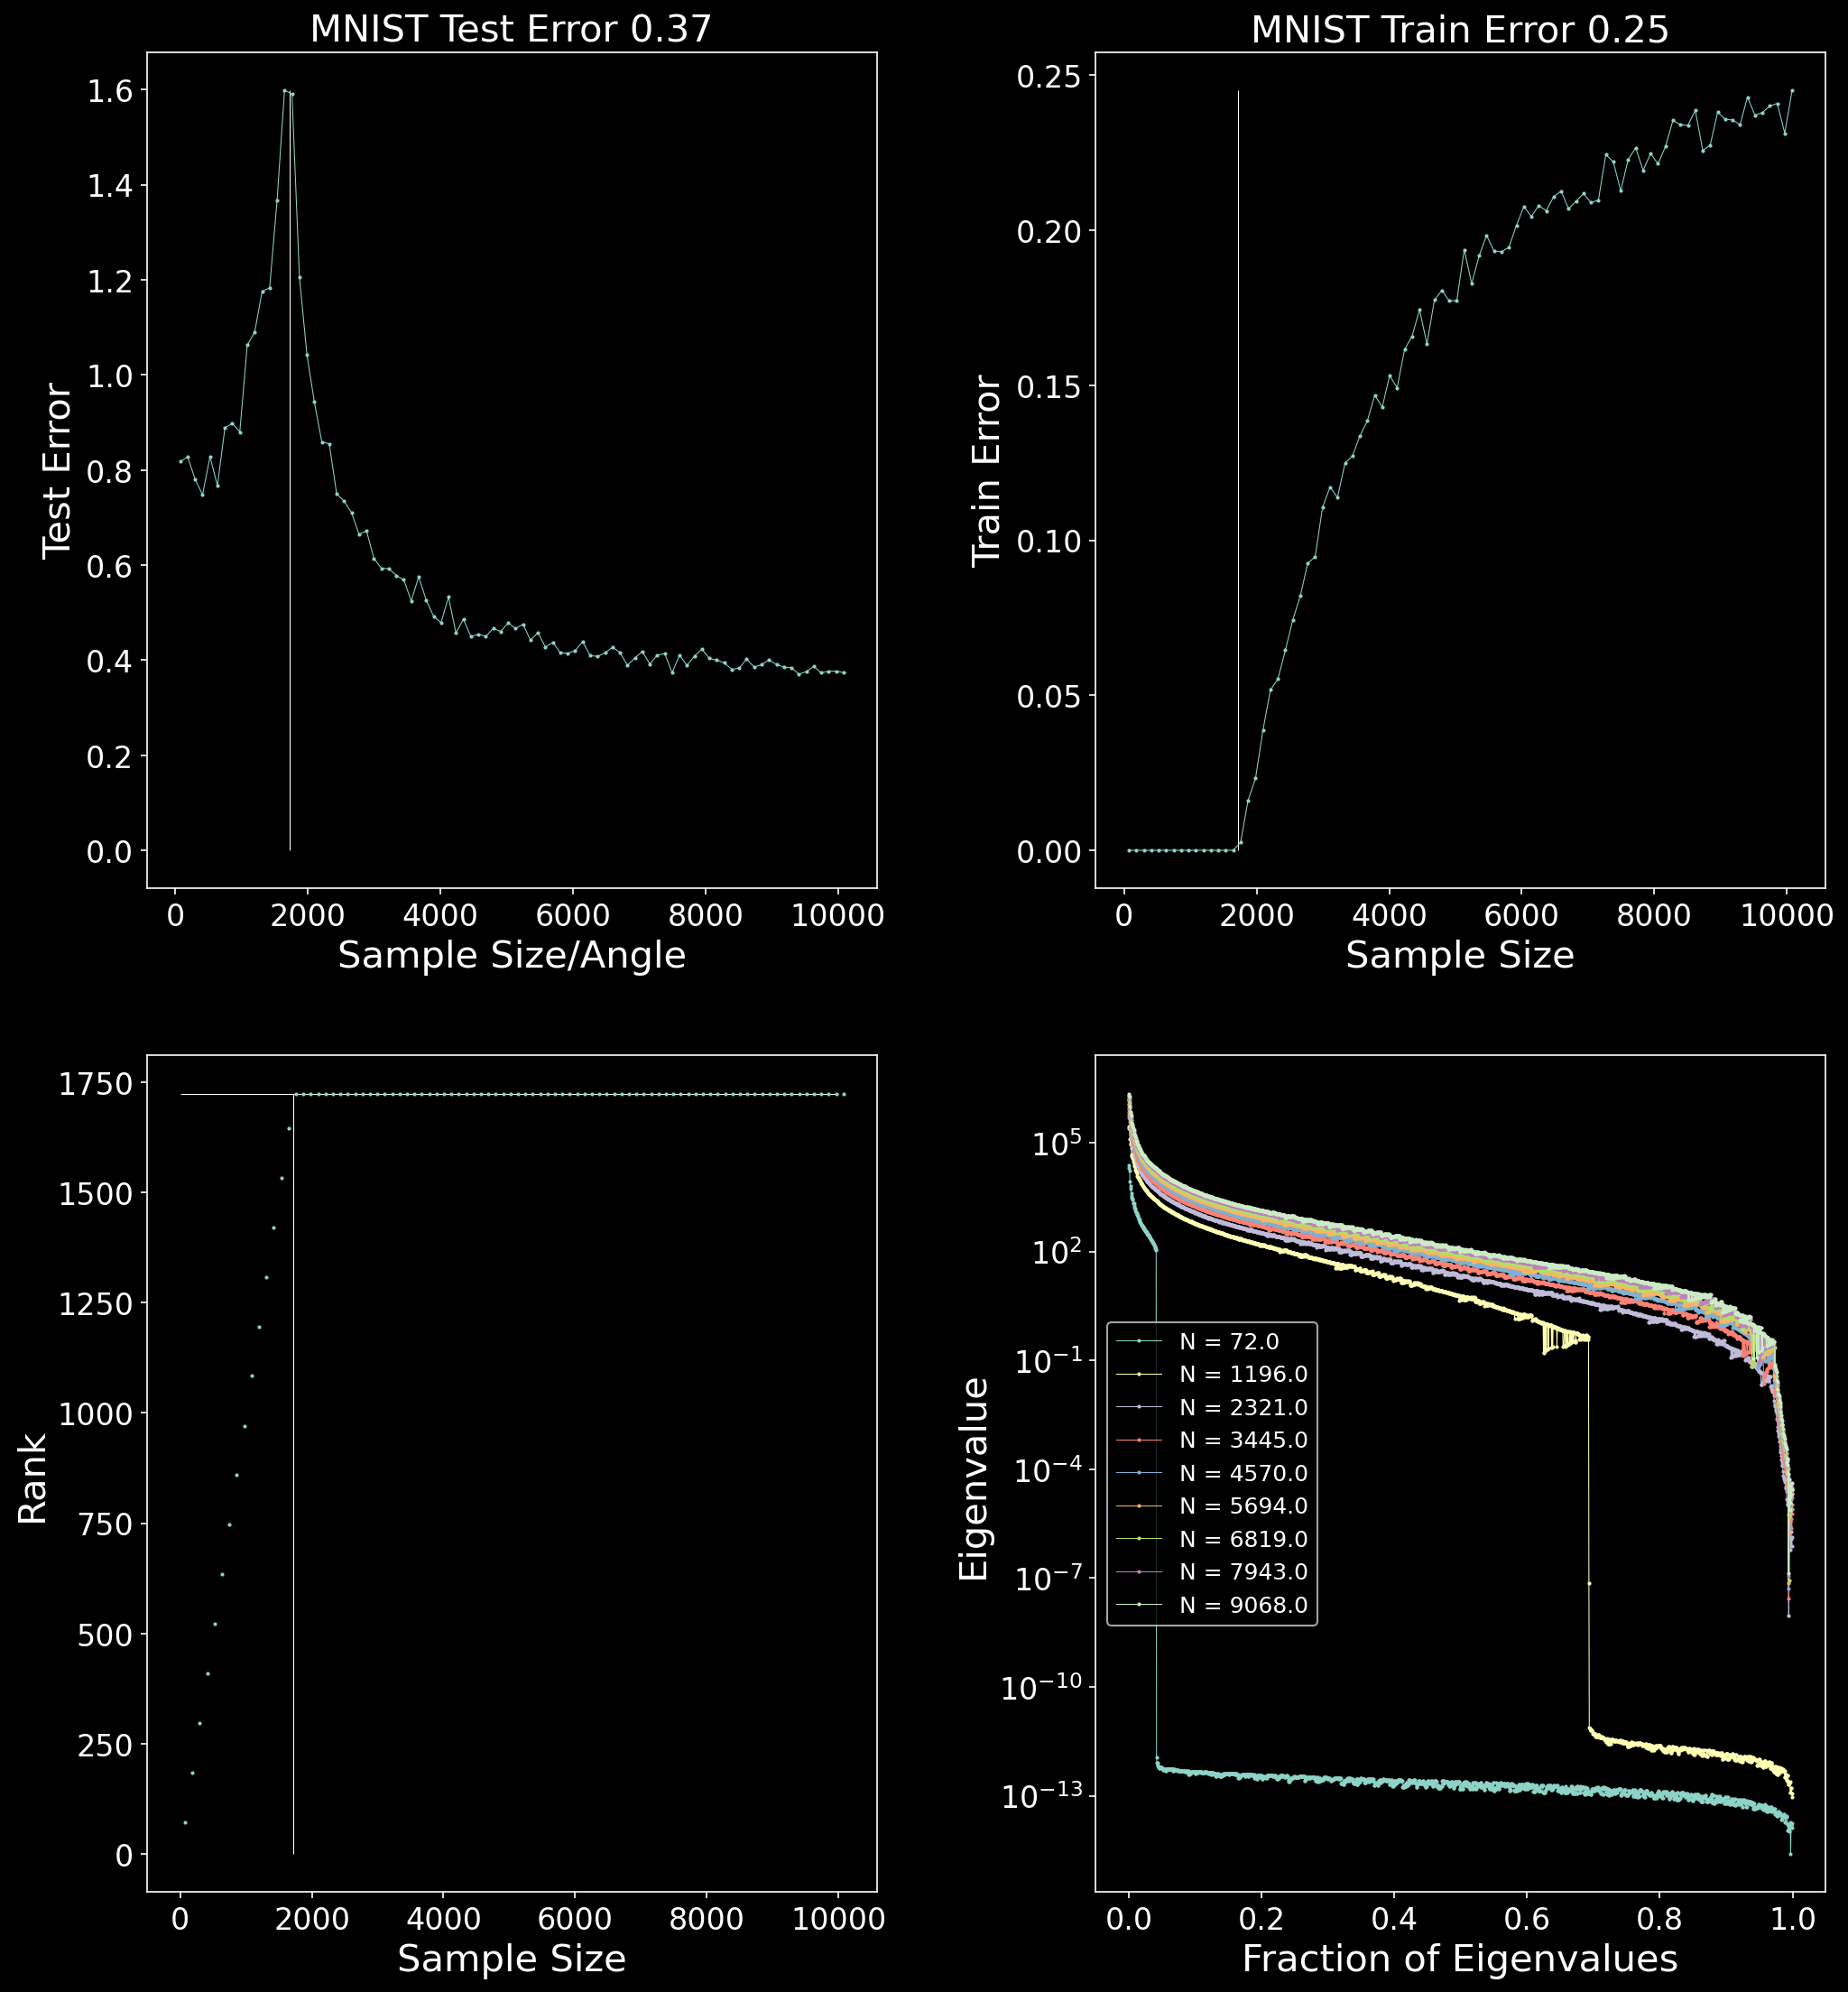

In [8]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 1724
x = np.linspace(0.0002,0.028,90)

ax = fig.add_subplot(221) 
ax.plot(x*360000,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size/Angle')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot(x*360000,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot(x*360000,rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,10000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(x*360000):
    if np.mod(indx,10)==0:
        ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[indx]), 
                linestyle='-', 
                marker='o',
                label='N = {}'.format(np.round(n)),
                markersize=1,
                linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [7]:
sc = StandardScaler()

X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

eval_list =[]
rank = []
test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

for indx, i in enumerate(np.linspace(0.0002,0.0056,90)):
    X, x_throw, Y, y_throw = train_test_split(
        X_tr, 
        np.repeat(Y_tr,6), 
        stratify=np.repeat(mnist_train_y,6)+np.tile((np.arange(6))*10,60000), 
        train_size=i,
        random_state=int(i*10000))
    
    XTX = np.matmul(X.T,X)
    rank.append(np.linalg.matrix_rank(X))
    eval_list.append(np.linalg.eigvals(XTX))
    X_inv1 = np.linalg.pinv(X)
    est = np.matmul(X_inv1,Y)

    vec = np.matmul(X_test[14::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X,est),-1,1)-Y)))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

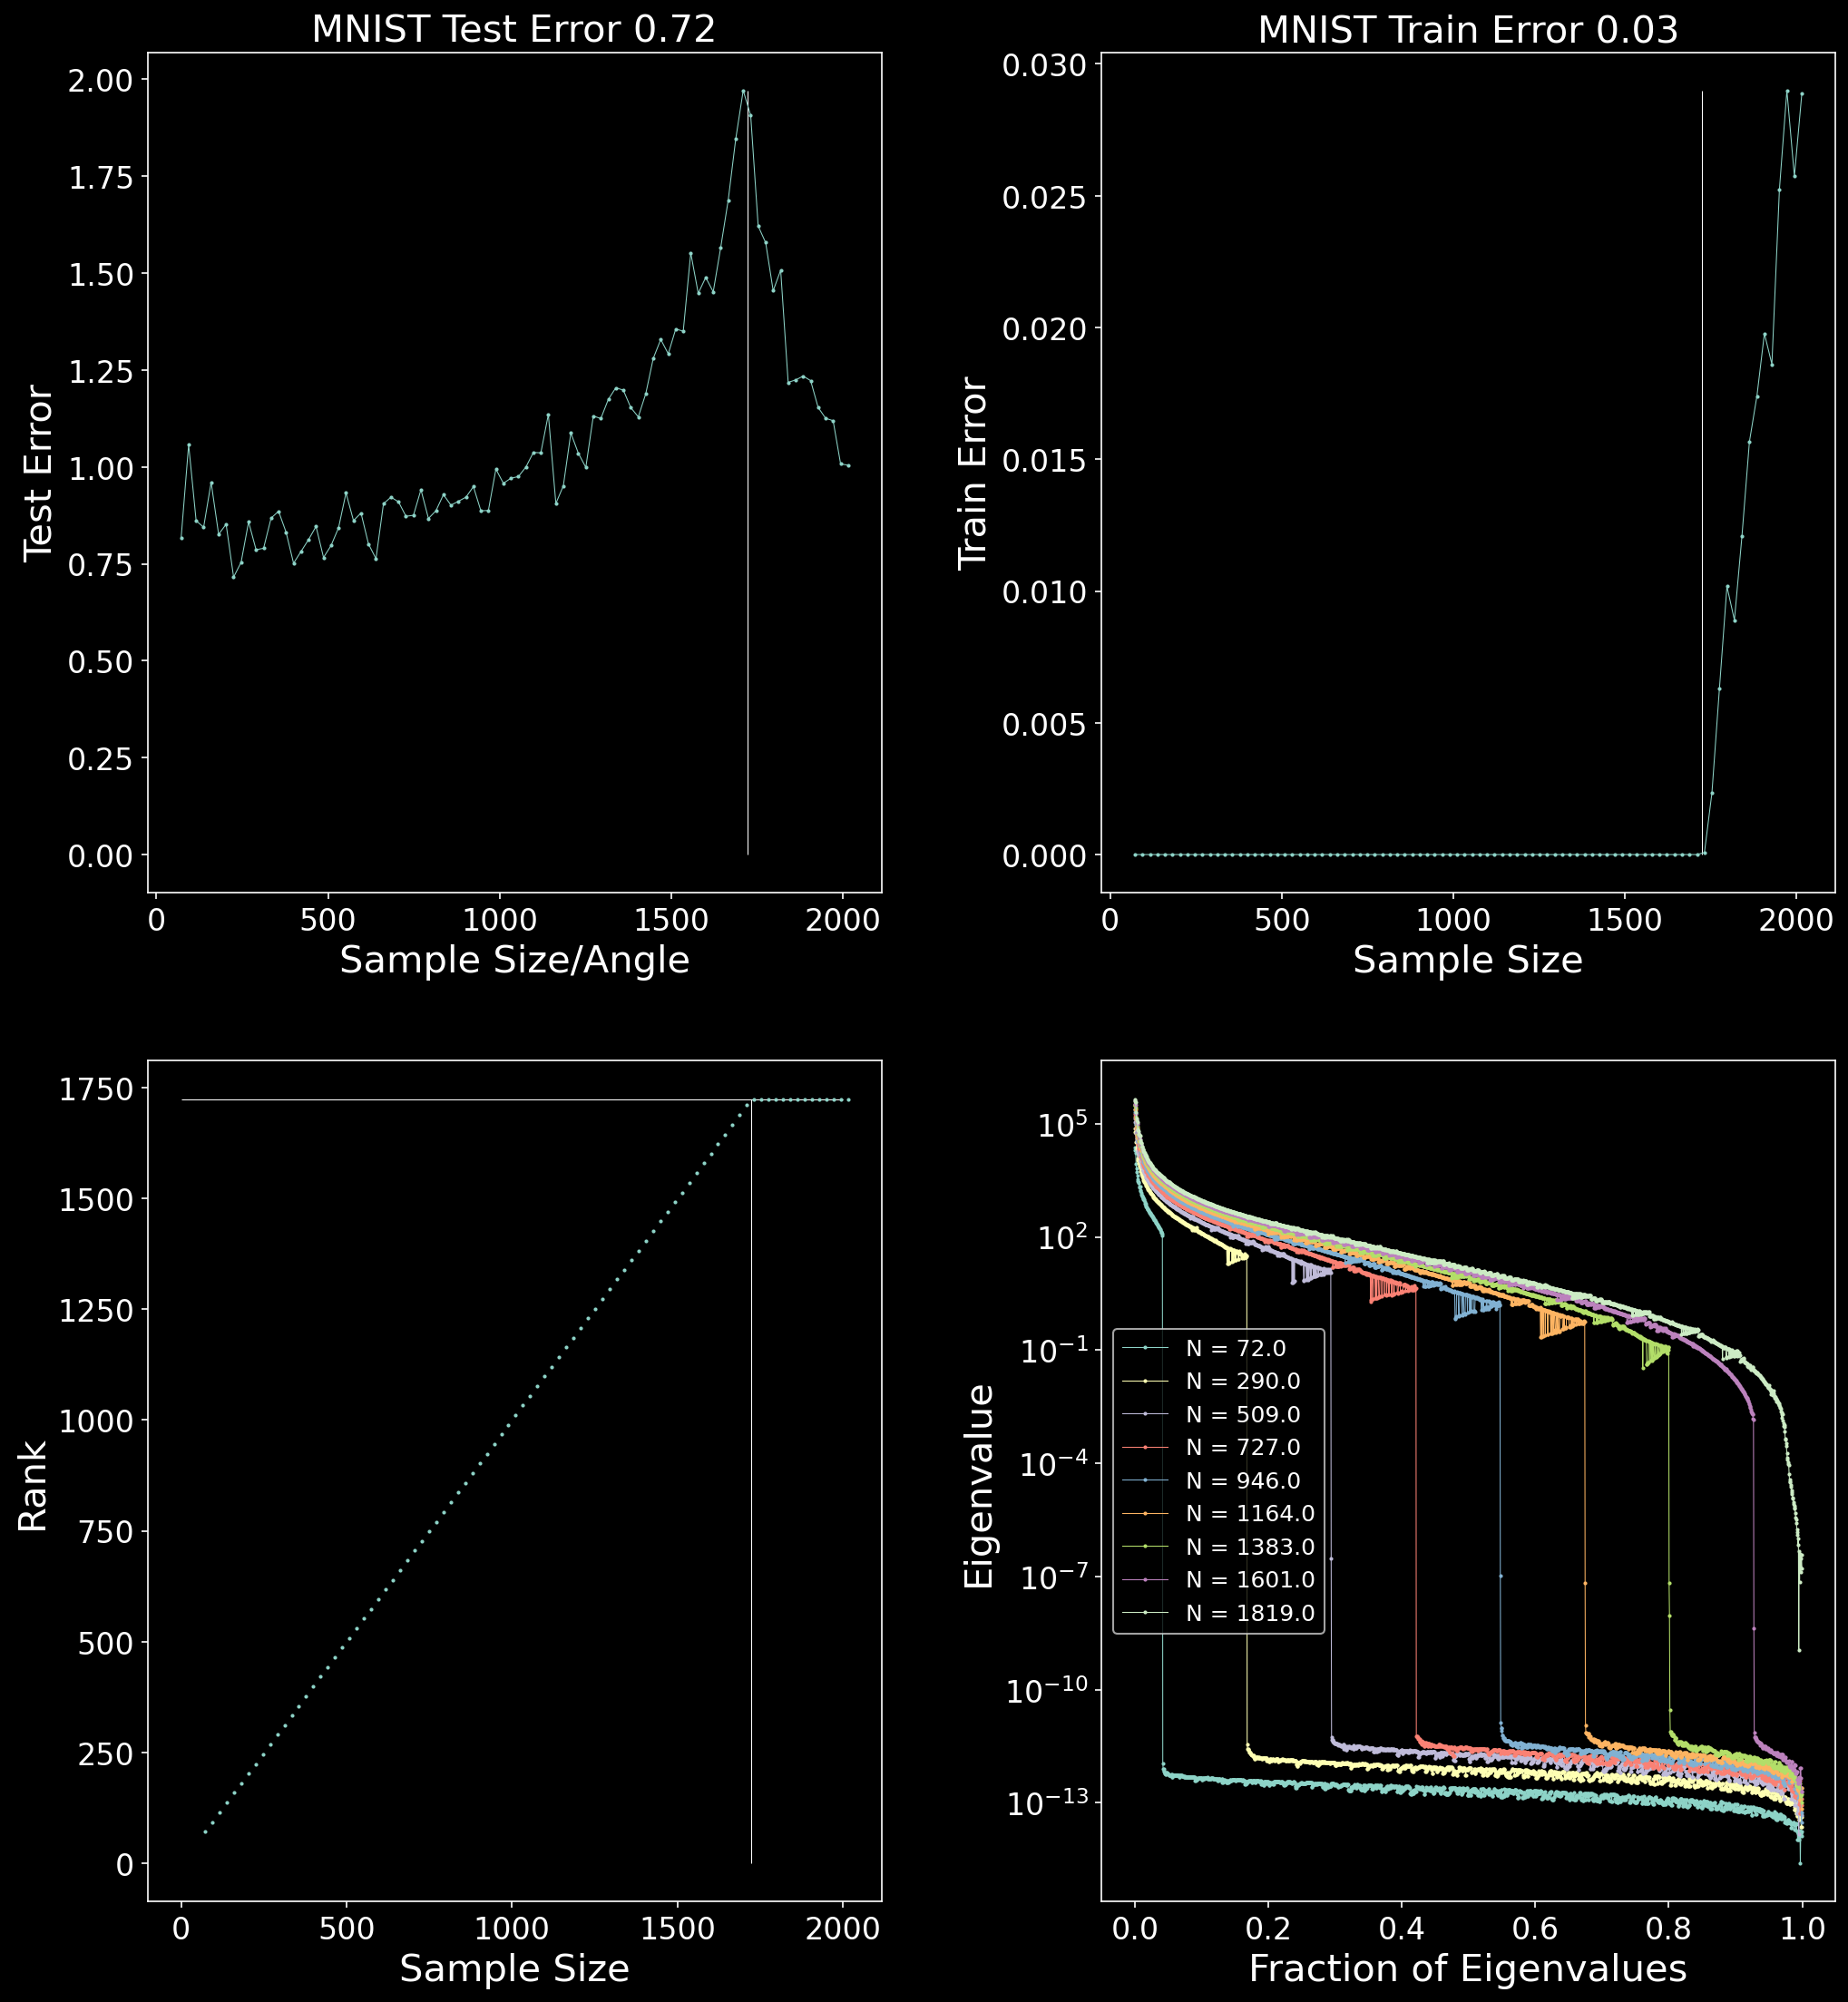

In [8]:
fig = plt.figure(figsize=(16,18),dpi=150)
n_coeff = 1724
x = np.linspace(0.0002,0.0056,90)

ax = fig.add_subplot(221) 
ax.plot(x*360000,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Sample Size/Angle')
plt.ylabel('Test Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(test_prec),'w',linewidth=0.5)
plt.title('MNIST Test Error {:.2f}'.format(np.min(test_prec)))


ax = fig.add_subplot(222) 
ax.plot(x*360000,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Train Error')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,np.max(train_prec),'w',linewidth=0.5)
plt.title('MNIST Train Error {:.2f}'.format(np.max(train_prec)))

ax = fig.add_subplot(223) 
ax.plot(x*360000,rank, 
        linestyle='', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Rank')
#plt.ylim([0, 50])
#plt.legend()
plt.vlines(n_coeff,0,n_coeff,'w',linewidth=0.5)
plt.hlines(n_coeff,0,2000,'w',linewidth=0.5)

ax = fig.add_subplot(224) 
for indx, n in enumerate(x*360000):
    if np.mod(indx,10)==0:
        ax.plot(np.arange(n_coeff)/n_coeff,np.abs(eval_list[indx]), 
                linestyle='-', 
                marker='o',
                label='N = {}'.format(np.round(n)),
                markersize=1,
                linewidth=0.5)
plt.xlabel('Fraction of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.yscale('log')
plt.legend()
fig.subplots_adjust(wspace=0.3, hspace=0.2)

In [9]:
X_tr = sc.fit_transform(np.log10(mnist_DHC_out_sizetrain))
Y_tr = (mnist_train_y  % 2) * 2.0 - 1 # odd/even --> +1/-1
Y_test = (mnist_test_y % 2) * 2.0 - 1 # odd/even --> +1/-1
X_test = sc.transform(np.log10(mnist_DHC_out_sizetest))

test_prec =[]
train_prec =[]
test_prec_class = []
prec = []

X_inv1 = np.linalg.pinv(X_tr)
est = np.matmul(X_inv1,np.repeat(Y_tr,6))
    
for i in range(100):
    vec = np.matmul(X_test[i::100,:],est)
    test_prec.append(np.mean(np.square(np.clip(vec,-1,1)-Y_test)))
    train_prec.append(np.mean(np.square(np.clip(np.matmul(X_tr,est),-1,1)-np.repeat(Y_tr,6))))
    vec[vec>0] = 1
    vec[vec<=0] = -1
    test_prec_class.append(np.mean(np.square(vec-Y_test)))
    prec.append(precision_score(Y_test, vec,average='micro'))

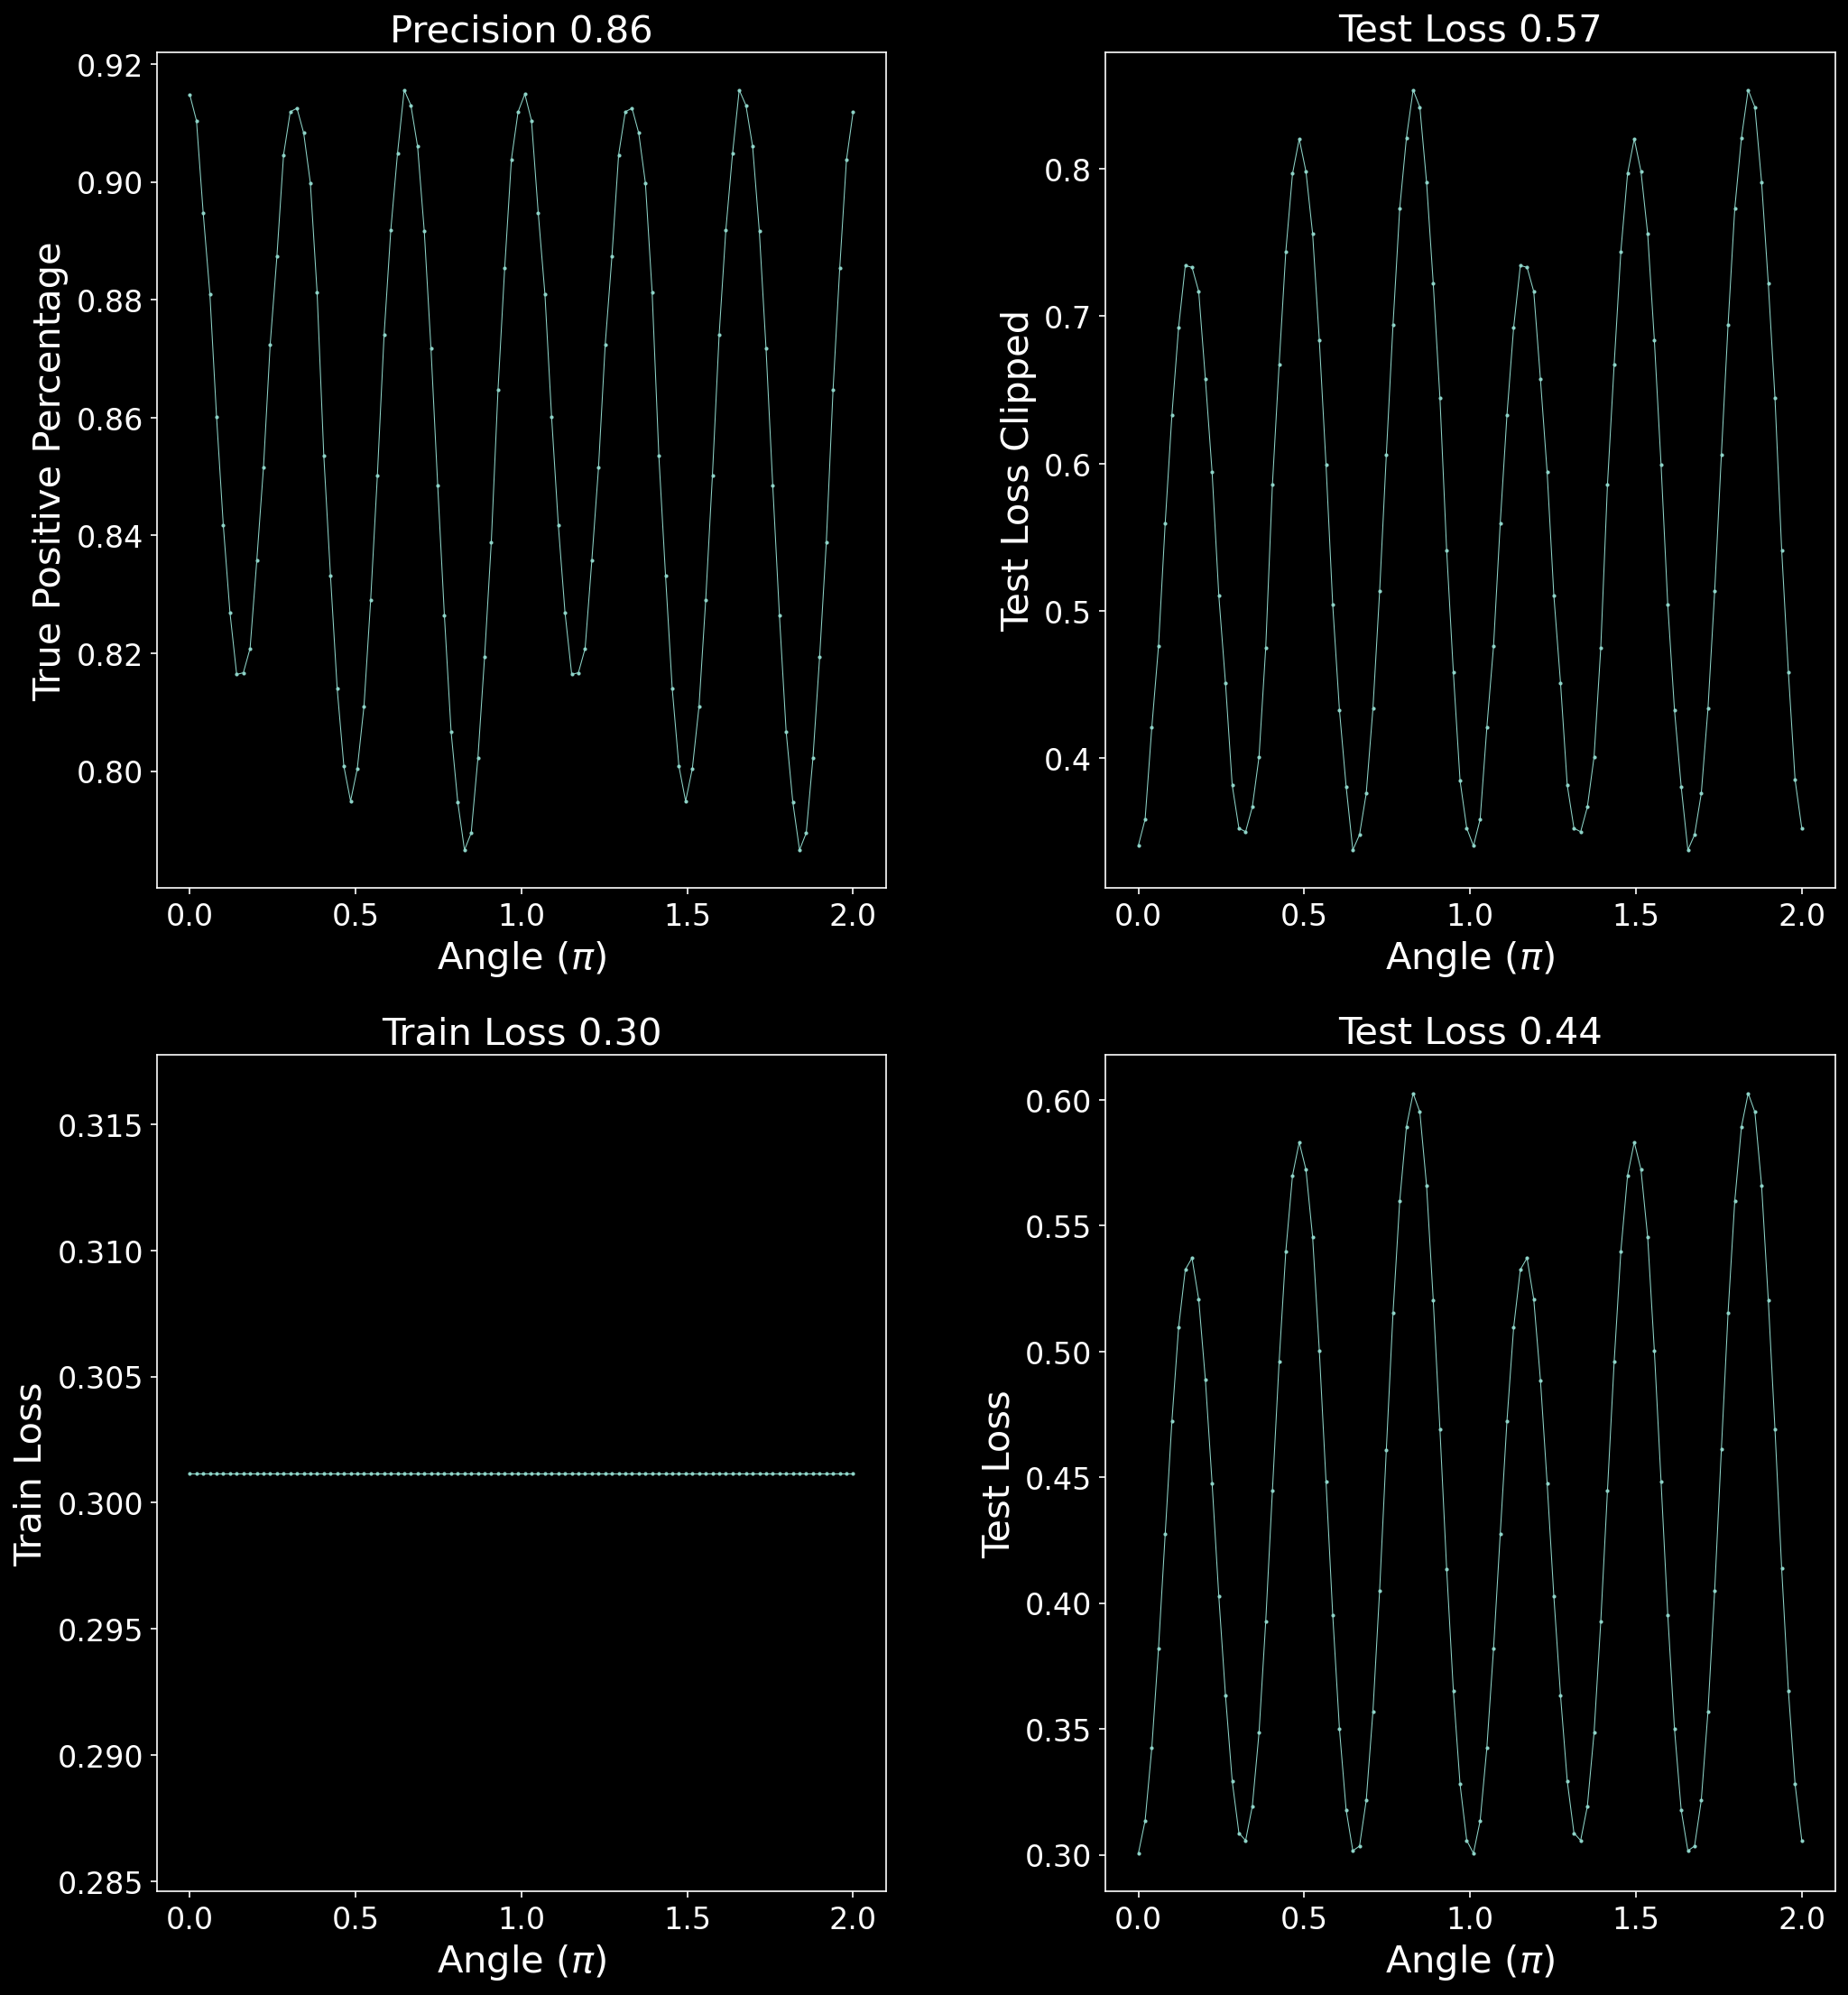

In [10]:
fig = plt.figure(figsize=(16,18),dpi=150)

ax = fig.add_subplot(221) 
ax.plot(angles,prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.title('Precision {:.2f}'.format(np.mean(prec)))

ax = fig.add_subplot(222) 
ax.plot(angles,test_prec_class, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Test Loss Clipped')
plt.title('Test Loss {:.2f}'.format(np.mean(test_prec_class)))

ax = fig.add_subplot(223) 
ax.plot(angles,train_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Train Loss')
plt.title('Train Loss {:.2f}'.format(np.mean(train_prec)))

ax = fig.add_subplot(224) 
ax.plot(angles,test_prec, 
        linestyle='-', 
        marker='o',
        label='test',
        markersize=1,
        linewidth=0.5)

plt.xlabel('Angle ($\pi$)')
plt.ylabel('Test Loss')
plt.title('Test Loss {:.2f}'.format(np.mean(test_prec)))

fig.subplots_adjust(wspace=0.3, hspace=0.2)